In [ ]:
! pip install rdkit
! pip install torch_geometric
! pip install transformers
! pip install biopython
! pip install numpy
! pip install suds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 961.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 7.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from os.path import join
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from rdkit import Chem
import rdkit
from rdkit.Chem import AllChem
from Bio.PDB import PDBList, PDBParser
import numpy as np
import requests
from sklearn.metrics import r2_score

# Define your inchi_to_graph function here
# and any other necessary functions or imports


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_train = pd.read_pickle(join("/content", "drive", "MyDrive", "data", "kcat_data", "splits", "train_df_kcat.pkl"))
data_test = pd.read_pickle(join("/content", "drive", "MyDrive", "data", "kcat_data", "splits", "test_df_kcat.pkl"))


data_train.rename(columns = {"geomean_kcat" :"log10_kcat"}, inplace = True)
data_test.rename(columns = {"geomean_kcat" :"log10_kcat"}, inplace = True)

data_train.keys()

Index(['Reaction ID', 'Sequence ID', 'kcat_values', 'Uniprot IDs',
       'from_BRENDA', 'from_Sabio', 'from_Uniprot', 'checked', 'Sequence',
       'substrates', 'products', 'MW_frac', 'max_kcat_for_UID',
       'max_kcat_for_RID', 'ECs', 'max_kcat_for_EC', 'structural_fp',
       'difference_fp', 'ESM1b', 'ESM1b_ts', 'log10_kcat', 'frac_of_max_UID',
       'frac_of_max_RID', 'frac_of_max_EC'],
      dtype='object')

In [ ]:
data_train = data_train[['substrates', 'products', 'Uniprot IDs', 'difference_fp', 'ESM1b', 'log10_kcat', 'difference_fp']]
data_test = data_test[['substrates', 'products', 'Uniprot IDs', 'difference_fp', 'ESM1b', 'log10_kcat', 'difference_fp']]


# Molecule to Graph Stucture

In [ ]:
# from rdkit import Chem
# from rdkit.Chem import AllChem
# import torch
# from torch_geometric.data import Data

# def inchi_to_graph(inchi):
#     try:
#         mol = Chem.MolFromInchi(inchi)
#         if mol is None:
#             raise ValueError("Invalid InChI string")

#         mol = Chem.AddHs(mol)  # Ensure hydrogen atoms are included
#         AllChem.EmbedMolecule(mol)
#         AllChem.UFFOptimizeMolecule(mol)

#         # Create node features
#         atom_features = []
#         for atom in mol.GetAtoms():
#             atom_features.append([atom.GetAtomicNum()])  # Simple atomic number feature

#         # Create edge indices and edge attributes
#         edge_index = []
#         edge_attr = []
#         for bond in mol.GetBonds():
#             i = bond.GetBeginAtomIdx()
#             j = bond.GetEndAtomIdx()
#             edge_index.append([i, j])
#             edge_index.append([j, i])  # Undirected graph
#             edge_attr.append([bond.GetBondTypeAsDouble()])
#             edge_attr.append([bond.GetBondTypeAsDouble()])

#         edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
#         atom_features = torch.tensor(atom_features, dtype=torch.float)
#         edge_attr = torch.tensor(edge_attr, dtype=torch.float)

#         return Data(x=atom_features, edge_index=edge_index, edge_attr=edge_attr)

#     except ValueError as ve:
#         print(f"ValueError: {ve}")
#     except RuntimeError as re:
#         print(f"RuntimeError: {re}")
#     except Exception as e:
#         print(f"An unexpected error occurred: {e}")

# # Example usage
# inchi_str = "InChI=1S/CH4/h1H4"  # Methane
# graph_data = inchi_to_graph(inchi_str)
# print(graph_data)


Data(x=[5, 1], edge_index=[2, 8], edge_attr=[8, 1])


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import torch
from torch_geometric.data import Data

def inchi_to_graph(inchi):
    try:
        mol = Chem.MolFromInchi(inchi)
        if mol is None:
            raise ValueError("Invalid InChI string")

        mol = Chem.AddHs(mol)  # Ensure hydrogen atoms are included
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)

        # Create node features
        atom_features = []
        for atom in mol.GetAtoms():
            atom_features.append([
                atom.GetAtomicNum(),  # Atomic number
                atom.GetTotalDegree(),  # Degree
                atom.GetFormalCharge(),  # Formal charge
                atom.GetNumImplicitHs(),  # Number of implicit hydrogens
                atom.GetIsAromatic(),  # Aromaticity
                atom.GetHybridization().real  # Hybridization
            ])

        # Create edge indices and edge attributes
        edge_index = []
        edge_attr = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_index.append([i, j])
            edge_index.append([j, i])  # Undirected graph
            edge_attr.append([
                bond.GetBondTypeAsDouble(),  # Bond type
                bond.GetIsConjugated(),  # Conjugation
                bond.IsInRing()  # Ring status
            ])
            edge_attr.append([
                bond.GetBondTypeAsDouble(),  # Bond type
                bond.GetIsConjugated(),  # Conjugation
                bond.IsInRing()  # Ring status
            ])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        atom_features = torch.tensor(atom_features, dtype=torch.float)
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)

        return Data(x=atom_features, edge_index=edge_index, edge_attr=edge_attr)

    except ValueError as ve:
        print(f"ValueError: {ve}")
    except RuntimeError as re:
        print(f"RuntimeError: {re}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Example usage
inchi_str = "InChI=1S/CH4/h1H4"  # Methane
graph_data = inchi_to_graph(inchi_str)
print(graph_data)


Data(x=[5, 6], edge_index=[2, 8], edge_attr=[8, 3])


In [ ]:
import torch
from torch_geometric.data import Data

def aggregate_graphs(graphs):
    # Combine node features
    combined_x = torch.cat([g.x for g in graphs], dim=0)

    # Combine edge indices and add offsets to account for the combined node indices
    edge_index_list = []
    edge_attr_list = []
    offset = 0
    for g in graphs:
        edge_index_list.append(g.edge_index + offset)
        if 'edge_attr' in g:
            edge_attr_list.append(g.edge_attr)
        offset += g.num_nodes
    combined_edge_index = torch.cat(edge_index_list, dim=1)
    combined_edge_attr = torch.cat(edge_attr_list, dim=0) if edge_attr_list else None

    return Data(x=combined_x, edge_index=combined_edge_index, edge_attr=combined_edge_attr)

# Example usage with multiple InChIs
inchi_list = ["InChI=1S/CH4/h1H4", "InChI=1S/H2O/h1H2"]
graphs = [inchi_to_graph(inchi) for inchi in inchi_list]
aggregated_graph = aggregate_graphs(graphs)
print(aggregated_graph)


Data(x=[8, 6], edge_index=[2, 12], edge_attr=[12, 3])


# Protein to Graph Structure

In [ ]:

# Function to map UniProt ID to PDB IDs
def map_uniprot_to_pdb(uniprot_id):
    url = "https://rest.uniprot.org/idmapping/run"
    data = {
        'from': 'UniProtKB_AC-ID',
        'to': 'PDB',
        'ids': uniprot_id
    }
    response = requests.post(url, data=data)
    job_id = response.json()['jobId']

    # Check the status of the job
    status_url = f"https://rest.uniprot.org/idmapping/status/{job_id}"

    status_response = requests.get(status_url)
    status = status_response.json()
    try:
          # Fetch the results
      results_url = f"https://rest.uniprot.org/idmapping/results/{job_id}"
      results_response = requests.get(results_url)
      results = results_response.json()
      pdb_ids = [item['to'] for item in results['results']]
      return pdb_ids

    except Exception as e:
      return ['none']




# Function to fetch protein sequence from UniProt
def fetch_protein_sequence(uniprot_id):
    url = f'https://www.uniprot.org/uniprot/{uniprot_id}.fasta'
    response = requests.get(url)
    fasta_data = response.text
    return ''.join(fasta_data.split('\n')[1:])




In [ ]:
# import torch
# import networkx as nx
# import numpy as np
# from Bio.PDB import PDBParser, PDBList, NeighborSearch
# from torch_geometric.data import Data
# import logging

# logging.basicConfig(level=logging.INFO)

# def fetch_protein_structure(pdb_id):
#     try:
#         pdbl = PDBList()
#         pdb_file = pdbl.retrieve_pdb_file(pdb_id, file_format="pdb")
#         parser = PDBParser(QUIET=True)
#         structure = parser.get_structure(pdb_id, pdb_file)
#         return structure
#     except Exception as e:
#         logging.error(f"Error fetching structure for PDB ID {pdb_id}: {e}")
#         return None

# def residue_to_feature(residue):
#     """Convert a residue to a feature vector."""
#     feature = []
#     # Add residue type as one-hot encoded vector
#     residue_types = ['ALA', 'CYS', 'ASP', 'GLU', 'PHE', 'GLY', 'HIS', 'ILE', 'LYS', 'LEU', 'MET', 'ASN', 'PRO', 'GLN', 'ARG', 'SER', 'THR', 'VAL', 'TRP', 'TYR']
#     residue_type_one_hot = [1 if residue.get_resname() == res_type else 0 for res_type in residue_types]
#     feature.extend(residue_type_one_hot)
#     # Add the 3D coordinates of the alpha carbon (CA) atom
#     ca_atom = residue['CA']
#     feature.extend(ca_atom.coord)
#     return feature

# def protein_structure_to_graph(structure, distance_threshold=5.0):
#     graph = nx.Graph()
#     residue_idx = {}
#     idx = 0

#     try:
#         for model in structure:
#             for chain in model:
#                 for residue in chain:
#                     if 'CA' in residue: # alpha carbon
#                         graph.add_node(idx, residue=residue, feature=residue_to_feature(residue))
#                         residue_idx[residue] = idx
#                         idx += 1

#         atoms = [atom for atom in structure.get_atoms() if atom.get_name() == 'CA']
#         ns = NeighborSearch(atoms)
#         for atom in atoms:
#             neighbors = ns.search(atom.coord, distance_threshold)
#             for neighbor in neighbors:
#                 res1 = atom.get_parent()
#                 res2 = neighbor.get_parent()
#                 if res1 != res2 and (residue_idx[res1], residue_idx[res2]) not in graph.edges:
#                     graph.add_edge(residue_idx[res1], residue_idx[res2])

#     except Exception as e:
#         logging.error(f"Error creating residue graph: {e}")

#     return graph_to_pyg_data(graph)

# def graph_to_pyg_data(graph):
#     try:
#         node_features = []
#         for _, data in graph.nodes(data=True):
#             node_features.append(data['feature'])

#         x = torch.tensor(node_features, dtype=torch.float)

#         edge_index = []
#         edge_attr = []
#         for edge in graph.edges:
#             edge_index.append([edge[0], edge[1]])
#             edge_index.append([edge[1], edge[0]])
#             distance = np.linalg.norm(x[edge[0], -3:].numpy() - x[edge[1], -3:].numpy())  # Using the last 3 values which are coordinates
#             edge_attr.append([distance])
#             edge_attr.append([distance])

#         edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
#         edge_attr = torch.tensor(edge_attr, dtype=torch.float)

#         data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
#         return data

#     except Exception as e:
#         logging.error(f"Error converting graph to PyG data: {e}")
#         return None

# # Example usage
# pdb_id = "1A8M"  # Example PDB ID
# structure = fetch_protein_structure(pdb_id)
# if structure:
#     graph = protein_structure_to_graph(structure)
#     print(graph)


Structure exists: '/content/a8/pdb1a8m.ent' 
Data(x=[456, 23], edge_index=[2, 1182], edge_attr=[1182, 1])


In [ ]:
import torch
import networkx as nx
import numpy as np
from Bio.PDB import PDBParser, PDBList, NeighborSearch
from torch_geometric.data import Data
from scipy.spatial import KDTree
import logging

logging.basicConfig(level=logging.INFO)

def fetch_protein_structure(pdb_id):
    try:
        pdbl = PDBList()
        pdb_file = pdbl.retrieve_pdb_file(pdb_id, file_format="pdb", pdir='/tmp')
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure(pdb_id, pdb_file)
        return structure
    except Exception as e:
        logging.error(f"Error fetching structure for PDB ID {pdb_id}: {e}")
        return None

def residue_to_feature(residue):
    """Convert a residue to a feature vector."""
    residue_types = ['ALA', 'CYS', 'ASP', 'GLU', 'PHE', 'GLY', 'HIS', 'ILE', 'LYS', 'LEU', 'MET', 'ASN', 'PRO', 'GLN', 'ARG', 'SER', 'THR', 'VAL', 'TRP', 'TYR']
    hydrophobicity = {'ALA': 1.8, 'CYS': 2.5, 'ASP': -3.5, 'GLU': -3.5, 'PHE': 2.8, 'GLY': -0.4, 'HIS': -3.2, 'ILE': 4.5, 'LYS': -3.9, 'LEU': 3.8, 'MET': 1.9, 'ASN': -3.5, 'PRO': -1.6, 'GLN': -3.5, 'ARG': -4.5, 'SER': -0.8, 'THR': -0.7, 'VAL': 4.2, 'TRP': -0.9, 'TYR': -1.3}
    polarity = {'ALA': 8.1, 'CYS': 5.5, 'ASP': 13.0, 'GLU': 12.3, 'PHE': 5.2, 'GLY': 9.0, 'HIS': 10.4, 'ILE': 5.2, 'LYS': 11.3, 'LEU': 4.9, 'MET': 5.7, 'ASN': 11.6, 'PRO': 8.0, 'GLN': 10.5, 'ARG': 10.5, 'SER': 9.2, 'THR': 8.6, 'VAL': 5.9, 'TRP': 5.4, 'TYR': 6.2}
    charge = {'ALA': 0, 'CYS': 0, 'ASP': -1, 'GLU': -1, 'PHE': 0, 'GLY': 0, 'HIS': 0.1, 'ILE': 0, 'LYS': 1, 'LEU': 0, 'MET': 0, 'ASN': 0, 'PRO': 0, 'GLN': 0, 'ARG': 1, 'SER': 0, 'THR': 0, 'VAL': 0, 'TRP': 0, 'TYR': 0}

    feature = []
    residue_type_one_hot = [1 if residue.get_resname() == res_type else 0 for res_type in residue_types]
    feature.extend(residue_type_one_hot)
    feature.append(hydrophobicity[residue.get_resname()])
    feature.append(polarity[residue.get_resname()])
    feature.append(charge[residue.get_resname()])
    ca_atom = residue['CA']
    feature.extend(ca_atom.coord.tolist())
    return feature

def protein_structure_to_graph(structure, distance_threshold=5.0):
    graph = nx.Graph()
    residue_idx = {}
    idx = 0

    try:
        for model in structure:
            for chain in model:
                for residue in chain:
                    if 'CA' in residue:
                        graph.add_node(idx, residue=residue, feature=residue_to_feature(residue))
                        residue_idx[residue] = idx
                        idx += 1

        ca_atoms = [residue['CA'] for residue in residue_idx.keys()]
        coordinates = [atom.coord for atom in ca_atoms]
        kdtree = KDTree(coordinates)

        for i, coord in enumerate(coordinates):
            indices = kdtree.query_ball_point(coord, distance_threshold)
            for j in indices:
                if i != j:
                    distance = np.linalg.norm(coord - coordinates[j])
                    graph.add_edge(i, j, weight=distance)

    except Exception as e:
        logging.error(f"Error creating residue graph: {e}")

    return graph_to_pyg_data(graph)

def create_default_protein_graph():
    """Create a default protein graph with predefined nodes and edges."""
    graph = nx.Graph()
    # Define a few nodes with arbitrary features
    default_features = [
        [1] * 20 + [1.8, 8.1, 0, 0, 0, 0],  # Node 0 (ALA)
        [0] * 20 + [2.5, 5.5, 0, 1, 1, 1],  # Node 1 (CYS)
        [0] * 20 + [-3.5, 13.0, -1, 2, 2, 2],  # Node 2 (ASP)
        [0] * 20 + [4.5, 5.2, 0, 3, 3, 3]  # Node 3 (ILE)
    ]
    for idx, features in enumerate(default_features):
        graph.add_node(idx, feature=features)

    # Add some edges with arbitrary distances
    graph.add_edge(0, 1, weight=4.0)
    graph.add_edge(1, 2, weight=5.0)
    graph.add_edge(2, 3, weight=6.0)
    graph.add_edge(3, 0, weight=4.5)

    return graph_to_pyg_data(graph)

def graph_to_pyg_data(graph):
    try:
        node_features = [data['feature'] for _, data in graph.nodes(data=True)]
        x = torch.tensor(node_features, dtype=torch.float)

        edge_index = []
        edge_attr = []
        for edge in graph.edges(data=True):
            edge_index.append([edge[0], edge[1]])
            edge_index.append([edge[1], edge[0]])
            edge_attr.append([edge[2]['weight']])
            edge_attr.append([edge[2]['weight']])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)

        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        return data

    except Exception as e:
        logging.error(f"Error converting graph to PyG data: {e}")
        return None

# Example usage
pdb_id = "1A8M"  # Example PDB ID
structure = fetch_protein_structure(pdb_id)
if structure:
    graph = protein_structure_to_graph(structure)
else:
    logging.info(f"PDB ID {pdb_id} not found. Using default protein graph.")
    graph = create_default_protein_graph()

print(graph)


Residue:  ARG Feature:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, -4.5, 10.5, 1, 32.11399841308594, 47.72800064086914, 65.34300231933594]
Residue:  THR Feature:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, -0.7, 8.6, 0, 32.39099884033203, 46.75699996948242, 61.64899826049805]
Residue:  PRO Feature:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1.6, 8.0, 0, 32.42499923706055, 43.24700164794922, 60.00899887084961]
Residue:  SER Feature:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, -0.8, 9.2, 0, 34.37200164794922, 41.25, 57.426998138427734]
Residue:  ASP Feature:  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -3.5, 13.0, -1, 38.013999938964844, 40.9010009765625, 56.49599838256836]
Residue:  LYS Feature:  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -3.9, 11.3, 1, 37.45800018310547, 42.58100128173828, 53.0880012512207]
Residue:  PRO Feature:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

# Data Engineering

In [ ]:
len(data_train)

3421

In [ ]:
def makedatasets(x):
  # Initialize an empty list to hold the processed data
  processed_data = []

  # Process each row in the DataFrame
  for index, row in data_train.iterrows():

    if index > x:
      break

    # Process substrates
    print("Index: ", index ," Out of ", len(data_train))
    substrate_graphs = [inchi_to_graph(inchi) for inchi in row['substrates']]
    for item in substrate_graphs:
      if item is None:
        substrate_graphs.remove(item)
    if substrate_graphs:
        aggregated_substrate_graph = aggregate_graphs(substrate_graphs)
    else:
        aggregated_substrate_graph = None

    # Process products
    product_graphs = [inchi_to_graph(inchi) for inchi in row['products']]
    for item in product_graphs:
      if item is None:
        product_graphs.remove(item)
    if product_graphs and substrate_graphs:
      aggregated_product_graph = aggregate_graphs(product_graphs)
    else:
      aggregated_product_graph = None

    # Process protein substrate
    uniprot_id = row['Uniprot IDs']
    embedding = row['ESM1b']
    pdb_ids = map_uniprot_to_pdb(uniprot_id)
    if pdb_ids:
        pdb_id = pdb_ids[0]
        protein_structure = fetch_protein_structure(pdb_id)
        protein_graph = protein_structure_to_graph(protein_structure, embedding)

    else:
        protein_graph = None

    aggregated_graph = aggregate_graphs([aggregated_substrate_graph, aggregated_product_graph])

    #
    # Ground truth label
    log10_kcat = row['log10_kcat']

    if protein_graph == None:
      continue

    # Append the processed data to the list
    processed_data.append({
        'aggregated_graph': aggregated_graph,
        'protein_graph': protein_graph,
        'log10_kcat': log10_kcat
    })
  # Define the path to save the processed data
  file_path = '/content/drive/My Drive/kcattraining_sets/' + str(x) + '100.pkl'

  # Save the list to the specified file
  with open(file_path, 'wb') as file:
      pickle.dump(processed_data, file)

  print(f"List saved to {file_path}")

In [ ]:
makedatasets(200)

Index:  0  Out of  3421
Structure exists: '/content/pr/pdb1pr9.ent' 
Index:  1  Out of  3421
Index:  2  Out of  3421
Index:  3  Out of  3421


KeyboardInterrupt: 

In [ ]:
import pickle
# Define the path to save the processed data
file_path = '/content/drive/My Drive/kcattrain_09_07_24.pkl'

# Save the list to the specified file
with open(file_path, 'wb') as file:
    pickle.dump(processed_data, file)

print(f"List saved to {file_path}")

In [ ]:
import pickle

In [ ]:
final_data = []
for item in processed_data:
  if item['aggregated_substrate_graph'] is not None and item['aggregated_product_graph'] is not None and item['protein_graph'] is not None:
    final_data.append(item)

In [ ]:
cleaned_data = []
for item in final_data:
  combined_graph = aggregate_graphs([item['aggregated_substrate_graph'], item['aggregated_product_graph']])
  cleaned_data.append({
      'combined': combined_graph,
      'protein_graph': item['protein_graph'],
      'log10_kcat': item['log10_kcat']
  })

In [ ]:
import pickle
# Define the path to save the processed data
file_path = '/content/drive/My Drive/cleaned500_kcat.pkl'

# Save the list to the specified file
with open(file_path, 'wb') as file:
    pickle.dump(cleaned_data, file)

print(f"List saved to {file_path}")

List saved to /content/drive/My Drive/cleaned500_kcat.pkl


In [ ]:
import pickle
# Define the path to the pickled file
file_path = '/content/drive/My Drive/kcattrain_08_07_24.pkl'

# Load the list from the specified file
with open(file_path, 'rb') as file:
    data_train = pickle.load(file)

In [ ]:
# combine substrates and products, remove null values

In [ ]:
def make_datasets(x, y):

  # Initialize an empty list to hold the processed data
  processed_data = []

  # Process each row in the DataFrame
  for index, row in data_test.iterrows():
      if index > y:
        break
      if index >= x:

        # Process substrates
        print("Index: ", index ," Out of ", len(data_test))
        substrate_graphs = [inchi_to_graph(inchi) for inchi in row['substrates']]
        for item in substrate_graphs:
          if item is None:
            substrate_graphs.remove(item)
        if substrate_graphs:
            aggregated_substrate_graph = aggregate_graphs(substrate_graphs)
        else:
            aggregated_substrate_graph = None

        # Process products
        product_graphs = [inchi_to_graph(inchi) for inchi in row['products']]
        for item in product_graphs:
          if item is None:
            product_graphs.remove(item)
        if product_graphs and substrate_graphs:
          aggregated_product_graph = aggregate_graphs(product_graphs)
        else:
          aggregated_product_graph = None

        # Process protein substrate
        uniprot_id = row['Uniprot IDs']

        pdb_ids = map_uniprot_to_pdb(uniprot_id)
        if pdb_ids:
            pdb_id = pdb_ids[0]
            protein_structure = fetch_protein_structure(pdb_id)
            protein_graph = protein_structure_to_graph(protein_structure)

        else:
            protein_graph = None


        # Ground truth label
        log10_kcat = row['log10_kcat']
        embedding = row['ESM1b']
        fingerprint = row['difference_fp']
        # Append the processed data to the list
        processed_data.append({
            'aggregated_substrate_graph': aggregated_substrate_graph,
            'aggregated_product_graph': aggregated_product_graph,
            'protein_graph': protein_graph,
            'esm_embedding': embedding,
            'log10_kcat': log10_kcat,
            'fingerprint': fingerprint
        })
  # Define the path to save the processed data
  file_path = '/content/drive/My Drive/kcat_minidatasets/testNew' + str(y) + '.pkl'

  # Save the list to the specified file
  with open(file_path, 'wb') as file:
      pickle.dump(processed_data, file)

  print(f"List saved to {file_path}")

In [ ]:
len(data_test)

850

In [ ]:
import pickle

In [ ]:
make_datasets(0, 200)
make_datasets(200, 400)
make_datasets(400, 600)
make_datasets(600, 800)
make_datasets(800, 849)



Index:  0  Out of  850
Structure exists: '/tmp/pdb2yor.ent' 
Index:  1  Out of  850
Structure exists: '/tmp/pdb6aym.ent' 
Index:  2  Out of  850


[11:34:41] WARNING: not removing hydrogen atom without neighbors
[11:34:41] WARNING: not removing hydrogen atom without neighbors


Index:  3  Out of  850


[11:34:43] WARNING: not removing hydrogen atom without neighbors
[11:34:43] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb6n2h.ent' 


ERROR:root:Error creating residue graph: 'LLP'


Index:  4  Out of  850
Structure exists: '/tmp/pdb3d4j.ent' 
Index:  5  Out of  850
Index:  6  Out of  850
Index:  7  Out of  850
Structure exists: '/tmp/pdb4fdx.ent' 
Index:  8  Out of  850
Structure exists: '/tmp/pdb1m41.ent' 
Index:  9  Out of  850


[11:34:54] WARNING: not removing hydrogen atom without neighbors
[11:34:54] WARNING: not removing hydrogen atom without neighbors


Index:  10  Out of  850
Index:  11  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb3emr.ent' 
Index:  12  Out of  850
Structure exists: '/tmp/pdb3nfz.ent' 
Index:  13  Out of  850
Structure exists: '/tmp/pdb3nx1.ent' 
Index:  14  Out of  850


[11:35:03] UFFTYPER: Unrecognized atom type: Fe5+2 (0)
[11:35:03] UFFTYPER: Unrecognized atom type: Fe5+2 (12)


Index:  15  Out of  850
Structure exists: '/tmp/pdb4s13.ent' 
Index:  16  Out of  850


[11:35:09] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[11:35:09] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[11:35:09] Cannot assign bond directions!
[11:35:09] WARNING: not removing hydrogen atom without neighbors
[11:35:09] WARNING: not removing hydrogen atom without neighbors
[11:35:09] Cannot assign bond directions!
[11:35:09] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[11:35:09] UFFTYPER: Unrecognized atom type: Fe2+2 (42)


Index:  17  Out of  850


[11:35:11] UFFTYPER: Unrecognized charge state for atom: 23
[11:35:11] UFFTYPER: Unrecognized charge state for atom: 23
[11:35:11] WARNING: not removing hydrogen atom without neighbors
[11:35:11] WARNING: not removing hydrogen atom without neighbors


Index:  18  Out of  850


[11:35:13] WARNING: not removing hydrogen atom without neighbors
[11:35:13] WARNING: not removing hydrogen atom without neighbors


Index:  19  Out of  850


[11:35:15] WARNING: not removing hydrogen atom without neighbors
[11:35:15] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MLZ'


Structure exists: '/tmp/pdb3uyi.ent' 
Index:  20  Out of  850


[11:35:18] WARNING: not removing hydrogen atom without neighbors
[11:35:18] WARNING: not removing hydrogen atom without neighbors


Index:  21  Out of  850
Index:  22  Out of  850
Index:  23  Out of  850
Index:  24  Out of  850
Index:  25  Out of  850
Structure exists: '/tmp/pdb1e2d.ent' 
Index:  26  Out of  850
Index:  27  Out of  850


ERROR:root:Error creating residue graph: 'A5A'


Structure exists: '/tmp/pdb3hxu.ent' 
Index:  28  Out of  850
Structure exists: '/tmp/pdb3hgi.ent' 
Index:  29  Out of  850
Index:  30  Out of  850


ERROR:root:Error creating residue graph: 'PCA'


Structure exists: '/tmp/pdb4zzq.ent' 
Index:  31  Out of  850


[11:35:38] WARNING: not removing hydrogen atom without neighbors
[11:35:38] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb6eeq.ent' 
Index:  32  Out of  850
Index:  33  Out of  850
Index:  34  Out of  850


[11:35:43] WARNING: not removing hydrogen atom without neighbors
[11:35:43] WARNING: not removing hydrogen atom without neighbors


Index:  35  Out of  850


[11:35:46] UFFTYPER: Unrecognized charge state for atom: 26
[11:35:46] UFFTYPER: Unrecognized charge state for atom: 26


Index:  36  Out of  850
Index:  37  Out of  850
Index:  38  Out of  850
Structure exists: '/tmp/pdb4zrm.ent' 
Index:  39  Out of  850
Structure exists: '/tmp/pdb1u5w.ent' 
Index:  40  Out of  850


[11:35:56] UFFTYPER: Unrecognized charge state for atom: 26
[11:35:57] UFFTYPER: Unrecognized charge state for atom: 26


Index:  41  Out of  850
Structure exists: '/tmp/pdb1zpd.ent' 
Index:  42  Out of  850
Index:  43  Out of  850
Index:  44  Out of  850
Index:  45  Out of  850
Structure exists: '/tmp/pdb1sja.ent' 


ERROR:root:Error creating residue graph: 'AME'


Index:  46  Out of  850
Structure exists: '/tmp/pdb4ae8.ent' 
Index:  47  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb3a9g.ent' 
Index:  48  Out of  850


[11:36:16] WARNING: not removing hydrogen atom without neighbors
[11:36:16] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2uz9.ent' 
Index:  49  Out of  850
Structure exists: '/tmp/pdb1jxa.ent' 
Index:  50  Out of  850
Index:  51  Out of  850


[11:36:23] UFFTYPER: Unrecognized charge state for atom: 26
[11:36:23] UFFTYPER: Unrecognized charge state for atom: 26


Index:  52  Out of  850


[11:36:25] WARNING: not removing hydrogen atom without neighbors
[11:36:25] WARNING: not removing hydrogen atom without neighbors


Index:  53  Out of  850
Structure exists: '/tmp/pdb7fip.ent' 
Index:  54  Out of  850
Structure exists: '/tmp/pdb2dxl.ent' 
Index:  55  Out of  850
Index:  56  Out of  850


ERROR:root:Error creating residue graph: 'OCS'


Structure exists: '/tmp/pdb1kcz.ent' 
Index:  57  Out of  850


[11:36:33] UFFTYPER: Unrecognized charge state for atom: 23
[11:36:34] UFFTYPER: Unrecognized charge state for atom: 23


Index:  58  Out of  850
Index:  59  Out of  850
Index:  60  Out of  850
Index:  61  Out of  850


[11:36:42] WARNING: not removing hydrogen atom without neighbors
[11:36:42] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2c31.ent' 
Index:  62  Out of  850
Index:  63  Out of  850
Structure exists: '/tmp/pdb2f98.ent' 
Index:  64  Out of  850
Structure exists: '/tmp/pdb1jys.ent' 
Index:  65  Out of  850


[11:36:50] WARNING: not removing hydrogen atom without neighbors
[11:36:50] WARNING: not removing hydrogen atom without neighbors


Index:  66  Out of  850
Structure exists: '/tmp/pdb5uv0.ent' 
Index:  67  Out of  850
Index:  68  Out of  850
Index:  69  Out of  850
Structure exists: '/tmp/pdb4s13.ent' 
Index:  70  Out of  850
Structure exists: '/tmp/pdb4zrm.ent' 
Index:  71  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb1jp3.ent' 
Index:  72  Out of  850
Structure exists: '/tmp/pdb2ggo.ent' 
Index:  73  Out of  850
Structure exists: '/tmp/pdb6vy9.ent' 
Index:  74  Out of  850
Index:  75  Out of  850
ValueError: Bad Conformer Id


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2gzr.ent' 
Index:  76  Out of  850
Structure exists: '/tmp/pdb1x74.ent' 
Index:  77  Out of  850
Index:  78  Out of  850


[11:37:24] WARNING: not removing hydrogen atom without neighbors
[11:37:24] WARNING: not removing hydrogen atom without neighbors


Index:  79  Out of  850
Structure exists: '/tmp/pdb6aym.ent' 
Index:  80  Out of  850
Index:  81  Out of  850
Structure exists: '/tmp/pdb5b0p.ent' 
Index:  82  Out of  850
Index:  83  Out of  850


[11:37:34] WARNING: not removing hydrogen atom without neighbors
[11:37:34] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb3bur.ent' 
Index:  84  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb5ms3.ent' 
Index:  85  Out of  850
Index:  86  Out of  850
Index:  87  Out of  850
Index:  88  Out of  850
Structure exists: '/tmp/pdb4lb0.ent' 


ERROR:root:Error creating residue graph: 'HYP'
[11:37:48] WARNING: not removing hydrogen atom without neighbors
[11:37:48] WARNING: not removing hydrogen atom without neighbors


Index:  89  Out of  850
Index:  90  Out of  850
Structure exists: '/tmp/pdb1q15.ent' 
Index:  91  Out of  850
Structure exists: '/tmp/pdb2rdn.ent' 
Index:  92  Out of  850
Structure exists: '/tmp/pdb4uav.ent' 
Index:  93  Out of  850


[11:37:56] WARNING: not removing hydrogen atom without neighbors
[11:37:56] WARNING: not removing hydrogen atom without neighbors


Index:  94  Out of  850


ERROR:root:Error creating residue graph: 'ABH'


Structure exists: '/tmp/pdb3mmr.ent' 
Index:  95  Out of  850
Structure exists: '/tmp/pdb3hgi.ent' 
Index:  96  Out of  850


[11:38:02] WARNING: not removing hydrogen atom without neighbors
[11:38:02] WARNING: not removing hydrogen atom without neighbors


Index:  97  Out of  850
Index:  98  Out of  850
Index:  99  Out of  850


[11:38:08] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[11:38:08] UFFTYPER: Unrecognized atom type: Fe2+2 (10)


Structure exists: '/tmp/pdb4h7u.ent' 
Index:  100  Out of  850


[11:38:10] UFFTYPER: Unrecognized charge state for atom: 26
[11:38:10] UFFTYPER: Unrecognized charge state for atom: 26
ERROR:root:Error creating residue graph: 'SAH'


Structure exists: '/tmp/pdb1hnn.ent' 
Index:  101  Out of  850
Index:  102  Out of  850


[11:38:13] WARNING: not removing hydrogen atom without neighbors
[11:38:13] WARNING: not removing hydrogen atom without neighbors


Index:  103  Out of  850


[11:38:17] WARNING: not removing hydrogen atom without neighbors
[11:38:17] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2j8m.ent' 
Index:  104  Out of  850


[11:38:19] WARNING: not removing hydrogen atom without neighbors
[11:38:19] WARNING: not removing hydrogen atom without neighbors


Index:  105  Out of  850
Index:  106  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb6fat.ent' 
Index:  107  Out of  850


[11:38:25] WARNING: not removing hydrogen atom without neighbors
[11:38:25] WARNING: not removing hydrogen atom without neighbors


Index:  108  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1v04.ent' 
Index:  109  Out of  850


[11:38:28] UFFTYPER: Unrecognized atom type: Mo1+6 (0)
[11:38:28] UFFTYPER: Unrecognized atom type: Mo1+6 (24)
[11:38:29] UFFTYPER: Unrecognized atom type: Mo1+6 (0)
[11:38:29] UFFTYPER: Unrecognized atom type: Mo1+6 (47)


Structure exists: '/tmp/pdb1e5k.ent' 
Index:  110  Out of  850


[11:38:32] WARNING: not removing hydrogen atom without neighbors
[11:38:32] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2hg2.ent' 
Index:  111  Out of  850
Index:  112  Out of  850
Structure exists: '/tmp/pdb2j5c.ent' 
Index:  113  Out of  850
Index:  114  Out of  850
Index:  115  Out of  850
Index:  116  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2paq.ent' 
Index:  117  Out of  850
Index:  118  Out of  850


[11:38:46] WARNING: not removing hydrogen atom without neighbors
[11:38:46] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb7cwx.ent' 
Index:  119  Out of  850
Structure exists: '/tmp/pdb1zmc.ent' 
Index:  120  Out of  850
Index:  121  Out of  850
Structure exists: '/tmp/pdb6vlb.ent' 
Index:  122  Out of  850


[11:38:56] WARNING: not removing hydrogen atom without neighbors
[11:38:56] WARNING: not removing hydrogen atom without neighbors


Index:  123  Out of  850
Structure exists: '/tmp/pdb4mtu.ent' 
Index:  124  Out of  850
Structure exists: '/tmp/pdb1qzm.ent' 
Index:  125  Out of  850
Structure exists: '/tmp/pdb1a3g.ent' 
Index:  126  Out of  850
Index:  127  Out of  850
Structure exists: '/tmp/pdb4zrm.ent' 
Index:  128  Out of  850
Index:  129  Out of  850
Index:  130  Out of  850
Index:  131  Out of  850
Index:  132  Out of  850


[11:39:17] UFFTYPER: Unrecognized atom type: Fe5+2 (0)
[11:39:17] UFFTYPER: Unrecognized atom type: Fe5+2 (12)


Index:  133  Out of  850
Index:  134  Out of  850


[11:39:21] WARNING: not removing hydrogen atom without neighbors
[11:39:21] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1oah.ent' 
Index:  135  Out of  850
Index:  136  Out of  850
Index:  137  Out of  850
Index:  138  Out of  850


[11:39:31] WARNING: not removing hydrogen atom without neighbors
[11:39:31] WARNING: not removing hydrogen atom without neighbors


Index:  139  Out of  850
Structure exists: '/tmp/pdb6jvv.ent' 
Index:  140  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1v04.ent' 
Index:  141  Out of  850
Index:  142  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1v04.ent' 
Index:  143  Out of  850
Structure exists: '/tmp/pdb3qt5.ent' 
Index:  144  Out of  850


[11:39:48] WARNING: not removing hydrogen atom without neighbors
[11:39:48] WARNING: not removing hydrogen atom without neighbors


Index:  145  Out of  850
Structure exists: '/tmp/pdb1tdj.ent' 
Index:  146  Out of  850


[11:39:52] WARNING: not removing hydrogen atom without neighbors
[11:39:52] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb5hzx.ent' 
Index:  147  Out of  850
Structure exists: '/tmp/pdb5uv0.ent' 
Index:  148  Out of  850
Structure exists: '/tmp/pdb5zl6.ent' 
Index:  149  Out of  850
Index:  150  Out of  850


[11:40:00] WARNING: not removing hydrogen atom without neighbors
[11:40:00] WARNING: not removing hydrogen atom without neighbors


Index:  151  Out of  850
ValueError: Bad Conformer Id


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2gzr.ent' 
Index:  152  Out of  850
Index:  153  Out of  850
Structure exists: '/tmp/pdb2dxl.ent' 
Index:  154  Out of  850
Structure exists: '/tmp/pdb2yor.ent' 
Index:  155  Out of  850
Structure exists: '/tmp/pdb1xtz.ent' 
Index:  156  Out of  850
Structure exists: '/tmp/pdb1vpx.ent' 
Index:  157  Out of  850


[11:40:16] WARNING: not removing hydrogen atom without neighbors
[11:40:16] WARNING: not removing hydrogen atom without neighbors


Index:  158  Out of  850
Index:  159  Out of  850
Structure exists: '/tmp/pdb7vpc.ent' 
Index:  160  Out of  850


[11:40:22] UFFTYPER: Unrecognized charge state for atom: 26
[11:40:22] UFFTYPER: Unrecognized charge state for atom: 26
ERROR:root:Error creating residue graph: 'SAH'


Structure exists: '/tmp/pdb1hnn.ent' 
Index:  161  Out of  850


[11:40:24] WARNING: not removing hydrogen atom without neighbors
[11:40:24] WARNING: not removing hydrogen atom without neighbors


Index:  162  Out of  850


[11:40:26] WARNING: not removing hydrogen atom without neighbors
[11:40:26] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1u2e.ent' 
Index:  163  Out of  850
Index:  164  Out of  850


ERROR:root:Error creating residue graph: 'CSX'


Structure exists: '/tmp/pdb1f8w.ent' 
Index:  165  Out of  850
Structure exists: '/tmp/pdb1dxe.ent' 
Index:  166  Out of  850


[11:40:34] WARNING: not removing hydrogen atom without neighbors
[11:40:34] WARNING: not removing hydrogen atom without neighbors


Index:  167  Out of  850
Structure exists: '/tmp/pdb3nfz.ent' 
Index:  168  Out of  850
Index:  169  Out of  850


[11:40:42] WARNING: not removing hydrogen atom without neighbors
[11:40:42] WARNING: not removing hydrogen atom without neighbors


Index:  170  Out of  850
Index:  171  Out of  850
Structure exists: '/tmp/pdb3nm4.ent' 
Index:  172  Out of  850
Structure exists: '/tmp/pdb2dsb.ent' 
Index:  173  Out of  850
Structure exists: '/tmp/pdb4h7u.ent' 
Index:  174  Out of  850
Index:  175  Out of  850


[11:40:54] WARNING: not removing hydrogen atom without neighbors
[11:40:54] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2v6b.ent' 
Index:  176  Out of  850
Index:  177  Out of  850
Index:  178  Out of  850


[11:41:04] WARNING: not removing hydrogen atom without neighbors
[11:41:04] WARNING: not removing hydrogen atom without neighbors


Index:  179  Out of  850
Structure exists: '/tmp/pdb1dud.ent' 
Index:  180  Out of  850
Structure exists: '/tmp/pdb1vlq.ent' 


ERROR:root:Error creating residue graph: 'MSE'


Index:  181  Out of  850
Index:  182  Out of  850


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb1y4i.ent' 
Index:  183  Out of  850


[11:41:12] WARNING: not removing hydrogen atom without neighbors
[11:41:12] WARNING: not removing hydrogen atom without neighbors


Index:  184  Out of  850
Structure exists: '/tmp/pdb4huz.ent' 
Index:  185  Out of  850
Structure exists: '/tmp/pdb1a3g.ent' 
Index:  186  Out of  850
Index:  187  Out of  850
Index:  188  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb1jp3.ent' 
Index:  189  Out of  850
Structure exists: '/tmp/pdb5zl6.ent' 
Index:  190  Out of  850
Index:  191  Out of  850
Index:  192  Out of  850


[11:41:31] WARNING: not removing hydrogen atom without neighbors
[11:41:31] WARNING: not removing hydrogen atom without neighbors


Index:  193  Out of  850


[11:41:34] WARNING: not removing hydrogen atom without neighbors
[11:41:34] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1zem.ent' 
Index:  194  Out of  850
Structure exists: '/tmp/pdb5uzp.ent' 
Index:  195  Out of  850
Structure exists: '/tmp/pdb1bx4.ent' 
Index:  196  Out of  850
Index:  197  Out of  850


[11:41:44] WARNING: not removing hydrogen atom without neighbors
[11:41:44] WARNING: not removing hydrogen atom without neighbors
[11:41:44] UFFTYPER: Unrecognized charge state for atom: 0
[11:41:44] UFFTYPER: Unrecognized charge state for atom: 0


Index:  198  Out of  850
Structure exists: '/tmp/pdb2a7m.ent' 
Index:  199  Out of  850
Structure exists: '/tmp/pdb1h3m.ent' 
Index:  200  Out of  850
List saved to /content/drive/My Drive/kcat_minidatasets/testNew200.pkl
Index:  200  Out of  850
Index:  201  Out of  850


[11:41:54] WARNING: not removing hydrogen atom without neighbors
[11:41:54] WARNING: not removing hydrogen atom without neighbors


Index:  202  Out of  850
Structure exists: '/tmp/pdb3nm4.ent' 
Index:  203  Out of  850
Index:  204  Out of  850
Index:  205  Out of  850
Index:  206  Out of  850
Index:  207  Out of  850
Index:  208  Out of  850


[11:42:07] WARNING: not removing hydrogen atom without neighbors
[11:42:07] WARNING: not removing hydrogen atom without neighbors


Index:  209  Out of  850


[11:42:09] WARNING: not removing hydrogen atom without neighbors
[11:42:09] WARNING: not removing hydrogen atom without neighbors


Index:  210  Out of  850
Index:  211  Out of  850
Structure exists: '/tmp/pdb4ae8.ent' 
Index:  212  Out of  850
Index:  213  Out of  850


[11:42:20] WARNING: not removing hydrogen atom without neighbors
[11:42:20] WARNING: not removing hydrogen atom without neighbors


Index:  214  Out of  850


[11:42:24] WARNING: not removing hydrogen atom without neighbors
[11:42:24] WARNING: not removing hydrogen atom without neighbors


Index:  215  Out of  850


ERROR:root:Error creating residue graph: 'PYR'


Index:  216  Out of  850
Index:  217  Out of  850


ERROR:root:Error creating residue graph: 'KCX'


Index:  218  Out of  850
Index:  219  Out of  850
Index:  220  Out of  850


[11:42:36] WARNING: not removing hydrogen atom without neighbors
[11:42:36] WARNING: not removing hydrogen atom without neighbors


Index:  221  Out of  850
Index:  222  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Index:  223  Out of  850
Index:  224  Out of  850


[11:42:46] WARNING: not removing hydrogen atom without neighbors
[11:42:46] WARNING: not removing hydrogen atom without neighbors


Index:  225  Out of  850


[11:42:49] UFFTYPER: Unrecognized charge state for atom: 26
[11:42:49] UFFTYPER: Unrecognized charge state for atom: 26
ERROR:root:Error creating residue graph: 'SAH'


Structure exists: '/tmp/pdb1hnn.ent' 
Index:  226  Out of  850
Index:  227  Out of  850


[11:42:53] WARNING: not removing hydrogen atom without neighbors
[11:42:53] WARNING: not removing hydrogen atom without neighbors


Index:  228  Out of  850
Index:  229  Out of  850


[11:42:57] WARNING: not removing hydrogen atom without neighbors
[11:42:57] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2hg2.ent' 
Index:  230  Out of  850
Index:  231  Out of  850


[11:43:02] WARNING: not removing hydrogen atom without neighbors
[11:43:02] WARNING: not removing hydrogen atom without neighbors


Index:  232  Out of  850


[11:43:05] WARNING: not removing hydrogen atom without neighbors
[11:43:05] WARNING: not removing hydrogen atom without neighbors


Index:  233  Out of  850
Index:  234  Out of  850


ERROR:root:Error creating residue graph: 'NLG'


Index:  235  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Index:  236  Out of  850


[11:43:15] WARNING: not removing hydrogen atom without neighbors
[11:43:15] WARNING: not removing hydrogen atom without neighbors


Index:  237  Out of  850


[11:43:18] WARNING: not removing hydrogen atom without neighbors
[11:43:18] WARNING: not removing hydrogen atom without neighbors


Index:  238  Out of  850


ERROR:root:Error creating residue graph: 'MSE'
[11:43:23] UFFTYPER: Unrecognized charge state for atom: 26
[11:43:23] UFFTYPER: Unrecognized charge state for atom: 26


Index:  239  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Index:  240  Out of  850


[11:43:26] WARNING: not removing hydrogen atom without neighbors
[11:43:26] WARNING: not removing hydrogen atom without neighbors


Index:  241  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Index:  242  Out of  850
Index:  243  Out of  850
Index:  244  Out of  850
Index:  245  Out of  850


[11:43:38] WARNING: not removing hydrogen atom without neighbors
[11:43:38] WARNING: not removing hydrogen atom without neighbors


Index:  246  Out of  850


ERROR:root:Error creating residue graph: 'LLP'


Index:  247  Out of  850
Index:  248  Out of  850
Index:  249  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb3emr.ent' 
Index:  250  Out of  850
Index:  251  Out of  850


[11:43:53] WARNING: not removing hydrogen atom without neighbors
[11:43:53] WARNING: not removing hydrogen atom without neighbors


Index:  252  Out of  850
Structure exists: '/tmp/pdb6aym.ent' 
Index:  253  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Index:  254  Out of  850
Index:  255  Out of  850
Index:  256  Out of  850
Index:  257  Out of  850
Index:  258  Out of  850


[11:44:07] WARNING: not removing hydrogen atom without neighbors
[11:44:07] WARNING: not removing hydrogen atom without neighbors


Index:  259  Out of  850


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb1y4i.ent' 
Index:  260  Out of  850
Structure exists: '/tmp/pdb1u5w.ent' 
Index:  261  Out of  850
Index:  262  Out of  850


[11:44:19] WARNING: not removing hydrogen atom without neighbors
[11:44:19] WARNING: not removing hydrogen atom without neighbors


Index:  263  Out of  850
Index:  264  Out of  850


[11:44:23] WARNING: not removing hydrogen atom without neighbors
[11:44:23] WARNING: not removing hydrogen atom without neighbors


Index:  265  Out of  850


[11:44:25] WARNING: not removing hydrogen atom without neighbors
[11:44:25] WARNING: not removing hydrogen atom without neighbors


Index:  266  Out of  850
Index:  267  Out of  850
Index:  268  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Index:  269  Out of  850
Index:  270  Out of  850


[11:44:38] WARNING: not removing hydrogen atom without neighbors
[11:44:38] WARNING: not removing hydrogen atom without neighbors


Index:  271  Out of  850
Index:  272  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb6fat.ent' 
Index:  273  Out of  850
Index:  274  Out of  850
Structure exists: '/tmp/pdb1u5w.ent' 
Index:  275  Out of  850


[11:44:47] WARNING: not removing hydrogen atom without neighbors
[11:44:47] WARNING: not removing hydrogen atom without neighbors


Index:  276  Out of  850
Structure exists: '/tmp/pdb4s13.ent' 
Index:  277  Out of  850
Index:  278  Out of  850
Index:  279  Out of  850
Index:  280  Out of  850
Index:  281  Out of  850
Index:  282  Out of  850
Index:  283  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb3msr.ent' 
Index:  284  Out of  850


ERROR:root:Error creating residue graph: 'CA'
[11:45:10] WARNING: not removing hydrogen atom without neighbors
[11:45:10] WARNING: not removing hydrogen atom without neighbors


Index:  285  Out of  850
Index:  286  Out of  850
Index:  287  Out of  850


[11:45:18] WARNING: not removing hydrogen atom without neighbors
[11:45:18] WARNING: not removing hydrogen atom without neighbors


Index:  288  Out of  850
Index:  289  Out of  850
Index:  290  Out of  850
Index:  291  Out of  850


[11:45:32] WARNING: not removing hydrogen atom without neighbors
[11:45:32] WARNING: not removing hydrogen atom without neighbors


Index:  292  Out of  850
Index:  293  Out of  850


[11:45:37] WARNING: not removing hydrogen atom without neighbors
[11:45:37] WARNING: not removing hydrogen atom without neighbors


Index:  294  Out of  850


[11:45:40] WARNING: not removing hydrogen atom without neighbors
[11:45:40] WARNING: not removing hydrogen atom without neighbors


Index:  295  Out of  850
Index:  296  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2gzr.ent' 
Index:  297  Out of  850
Structure exists: '/tmp/pdb2dxl.ent' 
Index:  298  Out of  850


[11:45:50] WARNING: not removing hydrogen atom without neighbors
[11:45:50] WARNING: not removing hydrogen atom without neighbors


Index:  299  Out of  850


ERROR:root:Error creating residue graph: 'CSX'
[11:45:54] WARNING: not removing hydrogen atom without neighbors
[11:45:54] WARNING: not removing hydrogen atom without neighbors


Index:  300  Out of  850
Index:  301  Out of  850
Index:  302  Out of  850
Index:  303  Out of  850


[11:46:04] WARNING: not removing hydrogen atom without neighbors
[11:46:04] WARNING: not removing hydrogen atom without neighbors


Index:  304  Out of  850
Index:  305  Out of  850


[11:46:10] WARNING: not removing hydrogen atom without neighbors
[11:46:10] WARNING: not removing hydrogen atom without neighbors


Index:  306  Out of  850
Index:  307  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Index:  308  Out of  850


[11:46:20] WARNING: not removing hydrogen atom without neighbors
[11:46:20] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2ggo.ent' 
Index:  309  Out of  850
Index:  310  Out of  850
Index:  311  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb1vmi.ent' 
Index:  312  Out of  850
Index:  313  Out of  850


[11:46:31] UFFTYPER: Unrecognized charge state for atom: 26
[11:46:31] UFFTYPER: Unrecognized charge state for atom: 26


Index:  314  Out of  850


[11:46:33] UFFTYPER: Unrecognized charge state for atom: 26
[11:46:33] UFFTYPER: Unrecognized charge state for atom: 26


Index:  315  Out of  850


[11:46:35] WARNING: not removing hydrogen atom without neighbors
[11:46:35] WARNING: not removing hydrogen atom without neighbors


Index:  316  Out of  850
Index:  317  Out of  850
Index:  318  Out of  850
Index:  319  Out of  850


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  320  Out of  850
Index:  321  Out of  850
Index:  322  Out of  850


[11:46:52] WARNING: not removing hydrogen atom without neighbors
[11:46:52] WARNING: not removing hydrogen atom without neighbors


Index:  323  Out of  850


[11:46:56] WARNING: not removing hydrogen atom without neighbors
[11:46:56] WARNING: not removing hydrogen atom without neighbors


Index:  324  Out of  850
Structure exists: '/tmp/pdb7rt0.ent' 
Index:  325  Out of  850


[11:47:00] WARNING: not removing hydrogen atom without neighbors
[11:47:00] WARNING: not removing hydrogen atom without neighbors


Index:  326  Out of  850
Index:  327  Out of  850


ERROR:root:Error creating residue graph: 'LYX'


Index:  328  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Index:  329  Out of  850
Index:  330  Out of  850


[11:47:10] UFFTYPER: Unrecognized charge state for atom: 0
[11:47:10] UFFTYPER: Unrecognized charge state for atom: 0
[11:47:10] WARNING: not removing hydrogen atom without neighbors
[11:47:10] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'LLP'


Index:  331  Out of  850
Index:  332  Out of  850


[11:47:16] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[11:47:16] UFFTYPER: Unrecognized atom type: Fe2+2 (10)


Structure exists: '/tmp/pdb4h7u.ent' 
Index:  333  Out of  850


[11:47:18] WARNING: not removing hydrogen atom without neighbors
[11:47:18] WARNING: not removing hydrogen atom without neighbors


Index:  334  Out of  850


[11:47:19] UFFTYPER: Unrecognized charge state for atom: 0
[11:47:19] UFFTYPER: Unrecognized charge state for atom: 0


Index:  335  Out of  850


ERROR:root:Error creating residue graph: 'KCX'


Index:  336  Out of  850
Structure exists: '/tmp/pdb2dsb.ent' 
Index:  337  Out of  850
Index:  338  Out of  850
Index:  339  Out of  850


[11:47:34] WARNING: not removing hydrogen atom without neighbors
[11:47:34] WARNING: not removing hydrogen atom without neighbors


Index:  340  Out of  850


[11:47:36] WARNING: not removing hydrogen atom without neighbors
[11:47:36] WARNING: not removing hydrogen atom without neighbors


Index:  341  Out of  850
Index:  342  Out of  850


ERROR:root:Error creating residue graph: 'KCX'


Structure exists: '/tmp/pdb4rdy.ent' 
Index:  343  Out of  850


[11:47:43] WARNING: not removing hydrogen atom without neighbors
[11:47:43] WARNING: not removing hydrogen atom without neighbors


Index:  344  Out of  850


[11:47:46] WARNING: not removing hydrogen atom without neighbors
[11:47:46] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'
[11:47:48] WARNING: not removing hydrogen atom without neighbors
[11:47:48] WARNING: not removing hydrogen atom without neighbors


Index:  345  Out of  850
Index:  346  Out of  850
Index:  347  Out of  850
Structure exists: '/tmp/pdb6fat.ent' 


ERROR:root:Error creating residue graph: 'CA'


Index:  348  Out of  850
Structure exists: '/tmp/pdb3hgi.ent' 
Index:  349  Out of  850
Index:  350  Out of  850
Index:  351  Out of  850
Index:  352  Out of  850
Index:  353  Out of  850
Index:  354  Out of  850
Index:  355  Out of  850
Index:  356  Out of  850


[11:48:08] WARNING: not removing hydrogen atom without neighbors
[11:48:08] WARNING: not removing hydrogen atom without neighbors


Index:  357  Out of  850


[11:48:13] WARNING: not removing hydrogen atom without neighbors
[11:48:13] WARNING: not removing hydrogen atom without neighbors


Index:  358  Out of  850
Structure exists: '/tmp/pdb5bvu.ent' 


ERROR:root:Error creating residue graph: 'CA'


Index:  359  Out of  850
Index:  360  Out of  850
Structure exists: '/tmp/pdb1jys.ent' 
Index:  361  Out of  850
Index:  362  Out of  850


[11:48:24] WARNING: not removing hydrogen atom without neighbors
[11:48:24] WARNING: not removing hydrogen atom without neighbors


Index:  363  Out of  850


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  364  Out of  850
Index:  365  Out of  850


[11:48:29] WARNING: not removing hydrogen atom without neighbors
[11:48:29] WARNING: not removing hydrogen atom without neighbors


Index:  366  Out of  850
Index:  367  Out of  850
Structure exists: '/tmp/pdb6aym.ent' 
Index:  368  Out of  850


[11:48:38] WARNING: not removing hydrogen atom without neighbors
[11:48:38] WARNING: not removing hydrogen atom without neighbors


Index:  369  Out of  850
Index:  370  Out of  850
Index:  371  Out of  850


[11:48:47] WARNING: not removing hydrogen atom without neighbors
[11:48:47] WARNING: not removing hydrogen atom without neighbors


Index:  372  Out of  850
Index:  373  Out of  850


[11:48:54] WARNING: not removing hydrogen atom without neighbors
[11:48:54] WARNING: not removing hydrogen atom without neighbors


Index:  374  Out of  850


[11:48:56] WARNING: not removing hydrogen atom without neighbors
[11:48:56] WARNING: not removing hydrogen atom without neighbors


Index:  375  Out of  850


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb1y4i.ent' 
Index:  376  Out of  850
Index:  377  Out of  850
Index:  378  Out of  850
Structure exists: '/tmp/pdb1e2d.ent' 
Index:  379  Out of  850


[11:49:10] WARNING: not removing hydrogen atom without neighbors
[11:49:10] WARNING: not removing hydrogen atom without neighbors


Index:  380  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb3a9g.ent' 
Index:  381  Out of  850
Index:  382  Out of  850
Index:  383  Out of  850
Index:  384  Out of  850


ERROR:root:Error creating residue graph: 'LLP'
[11:49:23] UFFTYPER: Unrecognized charge state for atom: 26
[11:49:23] UFFTYPER: Unrecognized charge state for atom: 26


Index:  385  Out of  850
Index:  386  Out of  850
Index:  387  Out of  850
Index:  388  Out of  850


[11:49:31] WARNING: not removing hydrogen atom without neighbors
[11:49:31] WARNING: not removing hydrogen atom without neighbors


Index:  389  Out of  850


[11:49:34] WARNING: not removing hydrogen atom without neighbors
[11:49:34] WARNING: not removing hydrogen atom without neighbors


Index:  390  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Index:  391  Out of  850


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb1y4i.ent' 
Index:  392  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2gzr.ent' 
Index:  393  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Index:  394  Out of  850
Index:  395  Out of  850
Index:  396  Out of  850
Structure exists: '/tmp/pdb6aym.ent' 
Index:  397  Out of  850
Index:  398  Out of  850
Index:  399  Out of  850
Structure exists: '/tmp/pdb1jxa.ent' 
Index:  400  Out of  850
Structure exists: '/tmp/pdb1a3g.ent' 
List saved to /content/drive/My Drive/kcat_minidatasets/testNew400.pkl
Index:  400  Out of  850
Structure exists: '/tmp/pdb1a3g.ent' 
Index:  401  Out of  850
Index:  402  Out of  850
Index:  403  Out of  850
Index:  404  Out of  850
Index:  405  Out of  850
Index:  406  Out of  850


[11:50:10] WARNING: not removing hydrogen atom without neighbors
[11:50:10] WARNING: not removing hydrogen atom without neighbors


Index:  407  Out of  850
Index:  408  Out of  850


[11:50:17] WARNING: not removing hydrogen atom without neighbors
[11:50:17] WARNING: not removing hydrogen atom without neighbors


Index:  409  Out of  850


[11:50:20] WARNING: not removing hydrogen atom without neighbors
[11:50:20] WARNING: not removing hydrogen atom without neighbors


Index:  410  Out of  850
Index:  411  Out of  850
Index:  412  Out of  850


[11:50:27] WARNING: not removing hydrogen atom without neighbors
[11:50:27] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  413  Out of  850
Index:  414  Out of  850
Index:  415  Out of  850
Index:  416  Out of  850
Index:  417  Out of  850
Index:  418  Out of  850
Structure exists: '/tmp/pdb3hgi.ent' 
Index:  419  Out of  850
Index:  420  Out of  850
Index:  421  Out of  850
Index:  422  Out of  850
Index:  423  Out of  850
Index:  424  Out of  850


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb4dza.ent' 
Index:  425  Out of  850


[11:50:53] WARNING: not removing hydrogen atom without neighbors
[11:50:53] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2nlo.ent' 
Index:  426  Out of  850
Structure exists: '/tmp/pdb6r73.ent' 
Index:  427  Out of  850


[11:50:58] UFFTYPER: Unrecognized charge state for atom: 26
[11:50:58] UFFTYPER: Unrecognized charge state for atom: 26


ERROR:root:Error creating residue graph: 'SAH'


Index:  428  Out of  850
Index:  429  Out of  850


[11:51:01] WARNING: not removing hydrogen atom without neighbors
[11:51:01] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'LLP'
[11:51:03] UFFTYPER: Unrecognized charge state for atom: 26
[11:51:03] UFFTYPER: Unrecognized charge state for atom: 26


Index:  430  Out of  850
Index:  431  Out of  850


[11:51:05] WARNING: not removing hydrogen atom without neighbors
[11:51:05] WARNING: not removing hydrogen atom without neighbors


Index:  432  Out of  850


[11:51:07] UFFTYPER: Unrecognized charge state for atom: 26
[11:51:07] UFFTYPER: Unrecognized charge state for atom: 26
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  433  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Index:  434  Out of  850
Index:  435  Out of  850


[11:51:15] WARNING: not removing hydrogen atom without neighbors
[11:51:15] WARNING: not removing hydrogen atom without neighbors
[11:51:15] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  436  Out of  850


[11:51:17] WARNING: not removing hydrogen atom without neighbors
[11:51:17] WARNING: not removing hydrogen atom without neighbors


Index:  437  Out of  850
Structure exists: '/tmp/pdb2ggo.ent' 
Index:  438  Out of  850
Index:  439  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb5ms3.ent' 
Index:  440  Out of  850


[11:51:27] UFFTYPER: Unrecognized charge state for atom: 26
[11:51:27] UFFTYPER: Unrecognized charge state for atom: 26
ERROR:root:Error creating residue graph: 'SAH'


Structure exists: '/tmp/pdb1hnn.ent' 
Index:  441  Out of  850


[11:51:29] WARNING: not removing hydrogen atom without neighbors
[11:51:29] WARNING: not removing hydrogen atom without neighbors


Index:  442  Out of  850


[11:51:33] WARNING: not removing hydrogen atom without neighbors
[11:51:33] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2j8m.ent' 
Index:  443  Out of  850
Index:  444  Out of  850


[11:51:38] WARNING: not removing hydrogen atom without neighbors
[11:51:38] WARNING: not removing hydrogen atom without neighbors


Index:  445  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Index:  446  Out of  850
Index:  447  Out of  850


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb1y4i.ent' 
Index:  448  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Index:  449  Out of  850
Index:  450  Out of  850


[11:51:55] WARNING: not removing hydrogen atom without neighbors
[11:51:55] WARNING: not removing hydrogen atom without neighbors


Index:  451  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb3a9g.ent' 
Index:  452  Out of  850
Index:  453  Out of  850
Index:  454  Out of  850


[11:52:03] WARNING: not removing hydrogen atom without neighbors
[11:52:03] WARNING: not removing hydrogen atom without neighbors


Index:  455  Out of  850
Structure exists: '/tmp/pdb1zpd.ent' 
Index:  456  Out of  850
Index:  457  Out of  850


ERROR:root:Error creating residue graph: 'KCX'


Structure exists: '/tmp/pdb4rdy.ent' 
Index:  458  Out of  850
Index:  459  Out of  850


[11:52:15] WARNING: not removing hydrogen atom without neighbors
[11:52:15] WARNING: not removing hydrogen atom without neighbors


Index:  460  Out of  850
Index:  461  Out of  850
Index:  462  Out of  850


[11:52:21] UFFTYPER: Unrecognized charge state for atom: 23
[11:52:21] UFFTYPER: Unrecognized charge state for atom: 23
[11:52:21] WARNING: not removing hydrogen atom without neighbors
[11:52:21] WARNING: not removing hydrogen atom without neighbors


Index:  463  Out of  850
Structure exists: '/tmp/pdb6aym.ent' 
Index:  464  Out of  850


[11:52:24] WARNING: not removing hydrogen atom without neighbors
[11:52:24] WARNING: not removing hydrogen atom without neighbors


Index:  465  Out of  850
Index:  466  Out of  850
Index:  467  Out of  850


[11:52:31] WARNING: not removing hydrogen atom without neighbors
[11:52:31] WARNING: not removing hydrogen atom without neighbors


Index:  468  Out of  850


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb1gc0.ent' 
Index:  469  Out of  850


[11:52:35] WARNING: not removing hydrogen atom without neighbors
[11:52:35] WARNING: not removing hydrogen atom without neighbors


Index:  470  Out of  850
Index:  471  Out of  850
Index:  472  Out of  850


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb1y4i.ent' 
Index:  473  Out of  850
Index:  474  Out of  850
Index:  475  Out of  850
Index:  476  Out of  850
Index:  477  Out of  850


[11:52:50] WARNING: not removing hydrogen atom without neighbors
[11:52:50] WARNING: not removing hydrogen atom without neighbors


Index:  478  Out of  850


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb1y4i.ent' 
Index:  479  Out of  850
Index:  480  Out of  850


[11:52:56] WARNING: not removing hydrogen atom without neighbors
[11:52:56] WARNING: not removing hydrogen atom without neighbors


Index:  481  Out of  850
Index:  482  Out of  850
Structure exists: '/tmp/pdb3qt5.ent' 
Index:  483  Out of  850
Index:  484  Out of  850
Index:  485  Out of  850
Structure exists: '/tmp/pdb4ae8.ent' 
Index:  486  Out of  850


[11:53:12] WARNING: not removing hydrogen atom without neighbors
[11:53:12] WARNING: not removing hydrogen atom without neighbors


Index:  487  Out of  850


[11:53:15] WARNING: not removing hydrogen atom without neighbors
[11:53:15] WARNING: not removing hydrogen atom without neighbors


Index:  488  Out of  850


ERROR:root:Error creating residue graph: 'KCX'


Index:  489  Out of  850
Index:  490  Out of  850


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb1gc0.ent' 
Index:  491  Out of  850


[11:53:23] WARNING: not removing hydrogen atom without neighbors
[11:53:23] WARNING: not removing hydrogen atom without neighbors


Index:  492  Out of  850


[11:53:24] WARNING: not removing hydrogen atom without neighbors
[11:53:24] WARNING: not removing hydrogen atom without neighbors


Index:  493  Out of  850


[11:53:28] WARNING: not removing hydrogen atom without neighbors
[11:53:28] WARNING: not removing hydrogen atom without neighbors


Index:  494  Out of  850
Structure exists: '/tmp/pdb1m41.ent' 
Index:  495  Out of  850
Index:  496  Out of  850
Index:  497  Out of  850


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  498  Out of  850


[11:53:37] WARNING: not removing hydrogen atom without neighbors
[11:53:37] WARNING: not removing hydrogen atom without neighbors


Index:  499  Out of  850
Structure exists: '/tmp/pdb5gjm.ent' 
Index:  500  Out of  850
Index:  501  Out of  850
Structure exists: '/tmp/pdb3si1.ent' 
Index:  502  Out of  850
Index:  503  Out of  850


[11:53:47] WARNING: not removing hydrogen atom without neighbors
[11:53:47] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2ggo.ent' 
Index:  504  Out of  850
Index:  505  Out of  850
Index:  506  Out of  850
Index:  507  Out of  850


ERROR:root:Error creating residue graph: 'NEP'


Index:  508  Out of  850
Index:  509  Out of  850


[11:54:02] WARNING: not removing hydrogen atom without neighbors
[11:54:02] WARNING: not removing hydrogen atom without neighbors


Index:  510  Out of  850


[11:54:05] UFFTYPER: Unrecognized charge state for atom: 26
[11:54:05] UFFTYPER: Unrecognized charge state for atom: 26
[11:54:05] WARNING: not removing hydrogen atom without neighbors
[11:54:05] WARNING: not removing hydrogen atom without neighbors


Index:  511  Out of  850
Index:  512  Out of  850


[11:54:09] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[11:54:09] UFFTYPER: Unrecognized atom type: Fe2+2 (10)


Structure exists: '/tmp/pdb4h7u.ent' 
Index:  513  Out of  850
Index:  514  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Index:  515  Out of  850
Index:  516  Out of  850


[11:54:17] WARNING: not removing hydrogen atom without neighbors
[11:54:17] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID 7AE4: [Errno 2] No such file or directory: '/tmp/pdb7ae4.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  517  Out of  850


[11:54:18] WARNING: not removing hydrogen atom without neighbors
[11:54:18] WARNING: not removing hydrogen atom without neighbors


Index:  518  Out of  850
Index:  519  Out of  850
Structure exists: '/tmp/pdb1zpd.ent' 
Index:  520  Out of  850


[11:54:25] WARNING: not removing hydrogen atom without neighbors
[11:54:25] WARNING: not removing hydrogen atom without neighbors
[11:54:25] UFFTYPER: Unrecognized charge state for atom: 0
[11:54:25] UFFTYPER: Unrecognized charge state for atom: 0
[11:54:25] UFFTYPER: Unrecognized charge state for atom: 2
[11:54:25] UFFTYPER: Unrecognized charge state for atom: 3
[11:54:26] UFFTYPER: Unrecognized charge state for atom: 0
[11:54:26] UFFTYPER: Unrecognized charge state for atom: 0
[11:54:26] UFFTYPER: Unrecognized charge state for atom: 2
[11:54:26] UFFTYPER: Unrecognized charge state for atom: 3


Index:  521  Out of  850
Index:  522  Out of  850
Index:  523  Out of  850
Index:  524  Out of  850
Index:  525  Out of  850
Index:  526  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1v04.ent' 
Index:  527  Out of  850


[11:54:39] WARNING: not removing hydrogen atom without neighbors
[11:54:39] WARNING: not removing hydrogen atom without neighbors


Index:  528  Out of  850
Index:  529  Out of  850


[11:54:42] WARNING: not removing hydrogen atom without neighbors
[11:54:42] WARNING: not removing hydrogen atom without neighbors


Index:  530  Out of  850
Index:  531  Out of  850


[11:54:46] WARNING: not removing hydrogen atom without neighbors
[11:54:46] WARNING: not removing hydrogen atom without neighbors


Index:  532  Out of  850
Index:  533  Out of  850
Structure exists: '/tmp/pdb4mhr.ent' 
Index:  534  Out of  850
Structure exists: '/tmp/pdb1zpd.ent' 
Index:  535  Out of  850


[11:54:54] WARNING: not removing hydrogen atom without neighbors
[11:54:54] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb3bur.ent' 
Index:  536  Out of  850
Index:  537  Out of  850


ERROR:root:Error creating residue graph: 'PCA'


Index:  538  Out of  850
Index:  539  Out of  850


[11:55:04] UFFTYPER: Unrecognized charge state for atom: 26
[11:55:04] UFFTYPER: Unrecognized charge state for atom: 26
[11:55:04] WARNING: not removing hydrogen atom without neighbors
[11:55:04] WARNING: not removing hydrogen atom without neighbors


Index:  540  Out of  850


[11:55:06] WARNING: not removing hydrogen atom without neighbors
[11:55:06] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb3bur.ent' 
Index:  541  Out of  850
Index:  542  Out of  850


[11:55:13] WARNING: not removing hydrogen atom without neighbors
[11:55:13] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb6n2h.ent' 


ERROR:root:Error creating residue graph: 'LLP'


Index:  543  Out of  850
Structure exists: '/tmp/pdb4huz.ent' 
Index:  544  Out of  850


[11:55:16] WARNING: not removing hydrogen atom without neighbors
[11:55:16] WARNING: not removing hydrogen atom without neighbors


Index:  545  Out of  850
Index:  546  Out of  850


ERROR:root:Error creating residue graph: 'OCS'


Structure exists: '/tmp/pdb1kcz.ent' 
Index:  547  Out of  850
Structure exists: '/tmp/pdb3si1.ent' 
Index:  548  Out of  850
Index:  549  Out of  850
Index:  550  Out of  850
Index:  551  Out of  850


[11:55:30] WARNING: not removing hydrogen atom without neighbors
[11:55:30] WARNING: not removing hydrogen atom without neighbors
[11:55:30] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  552  Out of  850


[11:55:32] WARNING: not removing hydrogen atom without neighbors
[11:55:32] WARNING: not removing hydrogen atom without neighbors
[11:55:32] UFFTYPER: Unrecognized charge state for atom: 0
[11:55:32] UFFTYPER: Unrecognized charge state for atom: 0
[11:55:32] UFFTYPER: Unrecognized charge state for atom: 2
[11:55:32] UFFTYPER: Unrecognized charge state for atom: 3
[11:55:32] UFFTYPER: Unrecognized charge state for atom: 0
[11:55:32] UFFTYPER: Unrecognized charge state for atom: 0
[11:55:32] UFFTYPER: Unrecognized charge state for atom: 2
[11:55:32] UFFTYPER: Unrecognized charge state for atom: 3


Structure exists: '/tmp/pdb6m7x.ent' 
Index:  553  Out of  850
Index:  554  Out of  850
Index:  555  Out of  850
Index:  556  Out of  850
Index:  557  Out of  850
Index:  558  Out of  850
Index:  559  Out of  850


[11:55:47] WARNING: not removing hydrogen atom without neighbors
[11:55:47] WARNING: not removing hydrogen atom without neighbors


Index:  560  Out of  850
Structure exists: '/tmp/pdb1ho3.ent' 
Index:  561  Out of  850
Index:  562  Out of  850
Index:  563  Out of  850


[11:55:56] WARNING: not removing hydrogen atom without neighbors
[11:55:56] WARNING: not removing hydrogen atom without neighbors


Index:  564  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Index:  565  Out of  850
Index:  566  Out of  850
Structure exists: '/tmp/pdb2yor.ent' 
Index:  567  Out of  850


[11:56:04] WARNING: not removing hydrogen atom without neighbors
[11:56:04] WARNING: not removing hydrogen atom without neighbors


Index:  568  Out of  850


[11:56:06] UFFTYPER: Unrecognized charge state for atom: 26
[11:56:06] UFFTYPER: Unrecognized charge state for atom: 26
ERROR:root:Error creating residue graph: 'SAH'


Structure exists: '/tmp/pdb1hnn.ent' 
Index:  569  Out of  850


ERROR:root:Error creating residue graph: 'S2C'


Index:  570  Out of  850
Structure exists: '/tmp/pdb2paq.ent' 


ERROR:root:Error creating residue graph: 'MSE'
[11:56:13] WARNING: not removing hydrogen atom without neighbors
[11:56:13] WARNING: not removing hydrogen atom without neighbors


Index:  571  Out of  850
Index:  572  Out of  850
Index:  573  Out of  850


ERROR:root:Error creating residue graph: 'KCX'


Structure exists: '/tmp/pdb4rdy.ent' 
Index:  574  Out of  850


[11:56:19] WARNING: not removing hydrogen atom without neighbors
[11:56:19] WARNING: not removing hydrogen atom without neighbors


Index:  575  Out of  850


[11:56:21] WARNING: not removing hydrogen atom without neighbors
[11:56:21] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'CSX'


Structure exists: '/tmp/pdb1f8w.ent' 
Index:  576  Out of  850


[11:56:25] WARNING: not removing hydrogen atom without neighbors
[11:56:25] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'CME'


Index:  577  Out of  850
Index:  578  Out of  850
Index:  579  Out of  850
Structure exists: '/tmp/pdb3si1.ent' 
Index:  580  Out of  850
Index:  581  Out of  850


[11:56:35] WARNING: not removing hydrogen atom without neighbors
[11:56:35] WARNING: not removing hydrogen atom without neighbors


Index:  582  Out of  850


ERROR:root:Error creating residue graph: 'CSD'
[11:56:41] WARNING: not removing hydrogen atom without neighbors
[11:56:41] WARNING: not removing hydrogen atom without neighbors


Index:  583  Out of  850
Index:  584  Out of  850
Structure exists: '/tmp/pdb1jys.ent' 
Index:  585  Out of  850


[11:56:46] WARNING: not removing hydrogen atom without neighbors
[11:56:46] WARNING: not removing hydrogen atom without neighbors


Index:  586  Out of  850
Index:  587  Out of  850
Index:  588  Out of  850


[11:56:54] WARNING: not removing hydrogen atom without neighbors
[11:56:54] WARNING: not removing hydrogen atom without neighbors


Index:  589  Out of  850
Index:  590  Out of  850


[11:56:58] WARNING: not removing hydrogen atom without neighbors
[11:56:58] WARNING: not removing hydrogen atom without neighbors


Index:  591  Out of  850
Index:  592  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb3a9g.ent' 
Index:  593  Out of  850


[11:57:05] WARNING: not removing hydrogen atom without neighbors
[11:57:05] WARNING: not removing hydrogen atom without neighbors


Index:  594  Out of  850
Index:  595  Out of  850
Index:  596  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Index:  597  Out of  850
Structure exists: '/tmp/pdb1jxa.ent' 
Index:  598  Out of  850
Structure exists: '/tmp/pdb1sja.ent' 


ERROR:root:Error creating residue graph: 'AME'
[11:57:19] UFFTYPER: Unrecognized charge state for atom: 26
[11:57:19] UFFTYPER: Unrecognized charge state for atom: 26


Index:  599  Out of  850
Index:  600  Out of  850
List saved to /content/drive/My Drive/kcat_minidatasets/testNew600.pkl
Index:  600  Out of  850
Index:  601  Out of  850
Index:  602  Out of  850


[11:57:26] WARNING: not removing hydrogen atom without neighbors
[11:57:26] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb3bur.ent' 
Index:  603  Out of  850


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  604  Out of  850


[11:57:30] WARNING: not removing hydrogen atom without neighbors
[11:57:30] WARNING: not removing hydrogen atom without neighbors


Index:  605  Out of  850
ValueError: Bad Conformer Id
Index:  606  Out of  850


[11:57:37] WARNING: not removing hydrogen atom without neighbors
[11:57:37] WARNING: not removing hydrogen atom without neighbors
[11:57:37] Cannot assign bond directions!
[11:57:38] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[11:57:38] UFFTYPER: Unrecognized atom type: Fe2+2 (48)
[11:57:38] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[11:57:38] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[11:57:38] Cannot assign bond directions!


Index:  607  Out of  850


[11:57:40] WARNING: not removing hydrogen atom without neighbors
[11:57:40] WARNING: not removing hydrogen atom without neighbors


Index:  608  Out of  850
Structure exists: '/tmp/pdb2dxl.ent' 
Index:  609  Out of  850
ValueError: Bad Conformer Id
Structure exists: '/tmp/pdb4ae8.ent' 
Index:  610  Out of  850
Index:  611  Out of  850
Index:  612  Out of  850
Index:  613  Out of  850
Index:  614  Out of  850
Structure exists: '/tmp/pdb4j5f.ent' 
Index:  615  Out of  850
Index:  616  Out of  850
Index:  617  Out of  850


[11:58:02] WARNING: not removing hydrogen atom without neighbors
[11:58:02] WARNING: not removing hydrogen atom without neighbors


Index:  618  Out of  850


[11:58:05] WARNING: not removing hydrogen atom without neighbors
[11:58:05] WARNING: not removing hydrogen atom without neighbors


Index:  619  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Index:  620  Out of  850


[11:58:09] WARNING: not removing hydrogen atom without neighbors
[11:58:09] WARNING: not removing hydrogen atom without neighbors


Index:  621  Out of  850
Index:  622  Out of  850


[11:58:14] WARNING: not removing hydrogen atom without neighbors
[11:58:14] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1tfu.ent' 
Index:  623  Out of  850


[11:58:17] WARNING: not removing hydrogen atom without neighbors
[11:58:17] WARNING: not removing hydrogen atom without neighbors


Index:  624  Out of  850
Index:  625  Out of  850
Index:  626  Out of  850
Index:  627  Out of  850


[11:58:24] WARNING: not removing hydrogen atom without neighbors
[11:58:24] WARNING: not removing hydrogen atom without neighbors


Index:  628  Out of  850
Structure exists: '/tmp/pdb4dyk.ent' 
Index:  629  Out of  850
Index:  630  Out of  850
Index:  631  Out of  850
Index:  632  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1v04.ent' 
Index:  633  Out of  850
Index:  634  Out of  850


[11:58:38] UFFTYPER: Unrecognized charge state for atom: 26
[11:58:38] UFFTYPER: Unrecognized charge state for atom: 26
[11:58:38] WARNING: not removing hydrogen atom without neighbors
[11:58:38] WARNING: not removing hydrogen atom without neighbors


Index:  635  Out of  850
Index:  636  Out of  850
Index:  637  Out of  850
Index:  638  Out of  850
Index:  639  Out of  850
Index:  640  Out of  850


[11:58:53] UFFTYPER: Unrecognized charge state for atom: 26
[11:58:53] UFFTYPER: Unrecognized charge state for atom: 26


Index:  641  Out of  850
Index:  642  Out of  850


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb4dyj.ent' 
Index:  643  Out of  850
Index:  644  Out of  850
Index:  645  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Index:  646  Out of  850
Index:  647  Out of  850


[11:59:07] WARNING: not removing hydrogen atom without neighbors
[11:59:07] WARNING: not removing hydrogen atom without neighbors


Index:  648  Out of  850
Index:  649  Out of  850


[11:59:11] WARNING: not removing hydrogen atom without neighbors
[11:59:11] WARNING: not removing hydrogen atom without neighbors
[11:59:11] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  650  Out of  850


[11:59:14] WARNING: not removing hydrogen atom without neighbors
[11:59:14] WARNING: not removing hydrogen atom without neighbors


Index:  651  Out of  850
Index:  652  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Index:  653  Out of  850
Structure exists: '/tmp/pdb4i9g.ent' 
Index:  654  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Index:  655  Out of  850


ERROR:root:Error creating residue graph: 'PYR'


Structure exists: '/tmp/pdb3noj.ent' 
Index:  656  Out of  850
Index:  657  Out of  850


[11:59:29] WARNING: not removing hydrogen atom without neighbors
[11:59:29] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1fjh.ent' 
Index:  658  Out of  850
Index:  659  Out of  850
Index:  660  Out of  850
Index:  661  Out of  850
Index:  662  Out of  850


[11:59:39] Cannot assign bond directions!
[11:59:41] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[11:59:41] UFFTYPER: Unrecognized atom type: Fe2+2 (59)


Index:  663  Out of  850
Index:  664  Out of  850


[11:59:46] WARNING: not removing hydrogen atom without neighbors
[11:59:46] WARNING: not removing hydrogen atom without neighbors


Index:  665  Out of  850


[11:59:49] WARNING: not removing hydrogen atom without neighbors
[11:59:49] WARNING: not removing hydrogen atom without neighbors


Index:  666  Out of  850
Index:  667  Out of  850
Index:  668  Out of  850


[11:59:57] WARNING: not removing hydrogen atom without neighbors
[11:59:57] WARNING: not removing hydrogen atom without neighbors


Index:  669  Out of  850
Index:  670  Out of  850
Index:  671  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Index:  672  Out of  850
Index:  673  Out of  850
Index:  674  Out of  850
Index:  675  Out of  850
Index:  676  Out of  850


[12:00:16] WARNING: not removing hydrogen atom without neighbors
[12:00:16] WARNING: not removing hydrogen atom without neighbors


Index:  677  Out of  850
Structure exists: '/tmp/pdb6vlb.ent' 
Index:  678  Out of  850
Index:  679  Out of  850


[12:00:22] WARNING: not removing hydrogen atom without neighbors
[12:00:22] WARNING: not removing hydrogen atom without neighbors


Index:  680  Out of  850


[12:00:24] UFFTYPER: Unrecognized charge state for atom: 26
[12:00:24] UFFTYPER: Unrecognized charge state for atom: 26
[12:00:24] WARNING: not removing hydrogen atom without neighbors
[12:00:24] WARNING: not removing hydrogen atom without neighbors


Index:  681  Out of  850
Index:  682  Out of  850
Index:  683  Out of  850
Index:  684  Out of  850
Index:  685  Out of  850
Index:  686  Out of  850
Structure exists: '/tmp/pdb1y4i.ent' 


ERROR:root:Error creating residue graph: 'LLP'


Index:  687  Out of  850


ERROR:root:Error creating residue graph: 'FLC'
[12:00:42] WARNING: not removing hydrogen atom without neighbors
[12:00:42] WARNING: not removing hydrogen atom without neighbors


Index:  688  Out of  850
Index:  689  Out of  850
Index:  690  Out of  850


[12:00:47] WARNING: not removing hydrogen atom without neighbors
[12:00:47] WARNING: not removing hydrogen atom without neighbors


Index:  691  Out of  850
Index:  692  Out of  850


[12:00:52] WARNING: not removing hydrogen atom without neighbors
[12:00:52] WARNING: not removing hydrogen atom without neighbors


Index:  693  Out of  850


[12:00:55] WARNING: not removing hydrogen atom without neighbors
[12:00:55] WARNING: not removing hydrogen atom without neighbors


Index:  694  Out of  850
Index:  695  Out of  850


[12:01:00] WARNING: not removing hydrogen atom without neighbors
[12:01:00] WARNING: not removing hydrogen atom without neighbors


Index:  696  Out of  850


[12:01:02] WARNING: not removing hydrogen atom without neighbors
[12:01:02] WARNING: not removing hydrogen atom without neighbors


Index:  697  Out of  850
Index:  698  Out of  850
Index:  699  Out of  850
Index:  700  Out of  850
Structure exists: '/tmp/pdb2yor.ent' 
Index:  701  Out of  850
Index:  702  Out of  850


[12:01:14] UFFTYPER: Unrecognized charge state for atom: 26
[12:01:14] UFFTYPER: Unrecognized charge state for atom: 26


Index:  703  Out of  850


[12:01:16] WARNING: not removing hydrogen atom without neighbors
[12:01:16] WARNING: not removing hydrogen atom without neighbors


Index:  704  Out of  850


[12:01:18] WARNING: not removing hydrogen atom without neighbors
[12:01:18] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MLY'


Index:  705  Out of  850
Index:  706  Out of  850


[12:01:23] WARNING: not removing hydrogen atom without neighbors
[12:01:23] WARNING: not removing hydrogen atom without neighbors


Index:  707  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2g5c.ent' 
Index:  708  Out of  850


[12:01:28] WARNING: not removing hydrogen atom without neighbors
[12:01:28] WARNING: not removing hydrogen atom without neighbors


Index:  709  Out of  850


[12:01:31] WARNING: not removing hydrogen atom without neighbors
[12:01:31] WARNING: not removing hydrogen atom without neighbors


Index:  710  Out of  850
Index:  711  Out of  850


[12:01:35] WARNING: not removing hydrogen atom without neighbors
[12:01:35] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'
[12:01:37] WARNING: not removing hydrogen atom without neighbors
[12:01:37] WARNING: not removing hydrogen atom without neighbors


Index:  712  Out of  850
Structure exists: '/tmp/pdb3bur.ent' 
Index:  713  Out of  850


[12:01:41] WARNING: not removing hydrogen atom without neighbors
[12:01:41] WARNING: not removing hydrogen atom without neighbors


Index:  714  Out of  850


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb1y4i.ent' 
Index:  715  Out of  850
Index:  716  Out of  850


[12:01:46] WARNING: not removing hydrogen atom without neighbors
[12:01:46] WARNING: not removing hydrogen atom without neighbors


Index:  717  Out of  850
Index:  718  Out of  850


[12:01:52] WARNING: not removing hydrogen atom without neighbors
[12:01:52] WARNING: not removing hydrogen atom without neighbors


Index:  719  Out of  850


[12:01:54] WARNING: not removing hydrogen atom without neighbors
[12:01:54] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4s13.ent' 
Index:  720  Out of  850
Index:  721  Out of  850
Index:  722  Out of  850


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb4dyj.ent' 
Index:  723  Out of  850
Index:  724  Out of  850


[12:02:06] WARNING: not removing hydrogen atom without neighbors
[12:02:06] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID 7AE4: [Errno 2] No such file or directory: '/tmp/pdb7ae4.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  725  Out of  850
Index:  726  Out of  850
Structure exists: '/tmp/pdb3nm4.ent' 
Index:  727  Out of  850
Index:  728  Out of  850
Index:  729  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1v04.ent' 
Index:  730  Out of  850
Index:  731  Out of  850
Index:  732  Out of  850


[12:02:20] UFFTYPER: Unrecognized charge state for atom: 26
[12:02:20] UFFTYPER: Unrecognized charge state for atom: 26
[12:02:21] UFFTYPER: Unrecognized charge state for atom: 23
[12:02:21] UFFTYPER: Unrecognized charge state for atom: 23


Index:  733  Out of  850


[12:02:23] WARNING: not removing hydrogen atom without neighbors
[12:02:23] WARNING: not removing hydrogen atom without neighbors


Index:  734  Out of  850
Index:  735  Out of  850


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  736  Out of  850
Index:  737  Out of  850


[12:02:30] WARNING: not removing hydrogen atom without neighbors
[12:02:30] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2nlo.ent' 
Index:  738  Out of  850
Index:  739  Out of  850
Index:  740  Out of  850
Index:  741  Out of  850
Structure exists: '/tmp/pdb3cqd.ent' 
Index:  742  Out of  850


ERROR:root:Error creating residue graph: 'KCX'


Index:  743  Out of  850
Index:  744  Out of  850
Structure exists: '/tmp/pdb4ae8.ent' 
Index:  745  Out of  850


[12:02:55] WARNING: not removing hydrogen atom without neighbors
[12:02:55] WARNING: not removing hydrogen atom without neighbors


Index:  746  Out of  850
Index:  747  Out of  850
Structure exists: '/tmp/pdb3si1.ent' 
Index:  748  Out of  850
Index:  749  Out of  850


[12:03:05] WARNING: not removing hydrogen atom without neighbors
[12:03:05] WARNING: not removing hydrogen atom without neighbors


Index:  750  Out of  850
Index:  751  Out of  850
Index:  752  Out of  850


[12:03:13] WARNING: not removing hydrogen atom without neighbors
[12:03:13] WARNING: not removing hydrogen atom without neighbors


Index:  753  Out of  850


[12:03:16] WARNING: not removing hydrogen atom without neighbors
[12:03:16] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  754  Out of  850
Index:  755  Out of  850
Index:  756  Out of  850
Index:  757  Out of  850


ERROR:root:Error creating residue graph: 'TRQ'


Index:  758  Out of  850
Index:  759  Out of  850
Index:  760  Out of  850
Structure exists: '/tmp/pdb3si1.ent' 
Index:  761  Out of  850
Index:  762  Out of  850
Index:  763  Out of  850


[12:03:35] WARNING: not removing hydrogen atom without neighbors
[12:03:35] WARNING: not removing hydrogen atom without neighbors


Index:  764  Out of  850
Index:  765  Out of  850


[12:03:42] WARNING: not removing hydrogen atom without neighbors
[12:03:42] WARNING: not removing hydrogen atom without neighbors


Index:  766  Out of  850
Index:  767  Out of  850
Index:  768  Out of  850


[12:03:48] WARNING: not removing hydrogen atom without neighbors
[12:03:48] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb3bur.ent' 
Index:  769  Out of  850


[12:03:51] WARNING: not removing hydrogen atom without neighbors
[12:03:51] WARNING: not removing hydrogen atom without neighbors


Index:  770  Out of  850
Index:  771  Out of  850
Structure exists: '/tmp/pdb5hxn.ent' 
Index:  772  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1v04.ent' 
Index:  773  Out of  850


[12:03:59] WARNING: not removing hydrogen atom without neighbors
[12:03:59] WARNING: not removing hydrogen atom without neighbors


Index:  774  Out of  850
Structure exists: '/tmp/pdb1cd5.ent' 
Index:  775  Out of  850
Structure exists: '/tmp/pdb1gc0.ent' 


ERROR:root:Error creating residue graph: 'LLP'


Index:  776  Out of  850
Index:  777  Out of  850


[12:04:07] WARNING: not removing hydrogen atom without neighbors
[12:04:07] WARNING: not removing hydrogen atom without neighbors


Index:  778  Out of  850
Index:  779  Out of  850
Index:  780  Out of  850
Index:  781  Out of  850
Index:  782  Out of  850


[12:04:19] WARNING: not removing hydrogen atom without neighbors
[12:04:19] WARNING: not removing hydrogen atom without neighbors


Index:  783  Out of  850
Index:  784  Out of  850
Structure exists: '/tmp/pdb1su1.ent' 
Index:  785  Out of  850
Index:  786  Out of  850


[12:04:31] WARNING: not removing hydrogen atom without neighbors
[12:04:31] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb3bur.ent' 
Index:  787  Out of  850
Index:  788  Out of  850
Index:  789  Out of  850


ERROR:root:Error creating residue graph: 'NEP'


Structure exists: '/tmp/pdb1e58.ent' 
Index:  790  Out of  850
Index:  791  Out of  850
Index:  792  Out of  850


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  793  Out of  850


[12:04:46] WARNING: not removing hydrogen atom without neighbors
[12:04:46] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  794  Out of  850


[12:04:48] Cannot assign bond directions!
[12:04:48] UFFTYPER: Unrecognized atom type: Fe+2 (0)
[12:04:48] UFFTYPER: Unrecognized atom type: Fe+2 (42)
[12:04:49] WARNING: not removing hydrogen atom without neighbors
[12:04:49] WARNING: not removing hydrogen atom without neighbors
[12:04:49] Cannot assign bond directions!
[12:04:49] UFFTYPER: Unrecognized atom type: Fe+2 (0)
[12:04:49] UFFTYPER: Unrecognized atom type: Fe+2 (42)
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  795  Out of  850
Index:  796  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Index:  797  Out of  850


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  798  Out of  850


[12:04:59] WARNING: not removing hydrogen atom without neighbors
[12:04:59] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb7cwx.ent' 
Index:  799  Out of  850


[12:05:01] WARNING: not removing hydrogen atom without neighbors
[12:05:01] WARNING: not removing hydrogen atom without neighbors


Index:  800  Out of  850


[12:05:04] WARNING: not removing hydrogen atom without neighbors
[12:05:04] WARNING: not removing hydrogen atom without neighbors


List saved to /content/drive/My Drive/kcat_minidatasets/testNew800.pkl
Index:  800  Out of  850


[12:05:09] WARNING: not removing hydrogen atom without neighbors
[12:05:09] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2e4g.ent' 
Index:  801  Out of  850


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb1y4i.ent' 
Index:  802  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb4ocj.ent' 
Index:  803  Out of  850
Index:  804  Out of  850
Index:  805  Out of  850
Index:  806  Out of  850


ERROR:root:Error creating residue graph: 'MSE'


Index:  807  Out of  850
Index:  808  Out of  850
Index:  809  Out of  850
Index:  810  Out of  850
Index:  811  Out of  850


ERROR:root:Error creating residue graph: 'FLC'


Index:  812  Out of  850
Index:  813  Out of  850
Index:  814  Out of  850
Index:  815  Out of  850


ERROR:root:Error creating residue graph: 'KCX'


Structure exists: '/tmp/pdb1onw.ent' 
Index:  816  Out of  850


[12:05:43] WARNING: not removing hydrogen atom without neighbors
[12:05:43] WARNING: not removing hydrogen atom without neighbors


Index:  817  Out of  850
Structure exists: '/tmp/pdb1tv5.ent' 
Index:  818  Out of  850


[12:05:47] WARNING: not removing hydrogen atom without neighbors
[12:05:47] WARNING: not removing hydrogen atom without neighbors


Index:  819  Out of  850
Index:  820  Out of  850


[12:05:53] WARNING: not removing hydrogen atom without neighbors
[12:05:53] WARNING: not removing hydrogen atom without neighbors


Index:  821  Out of  850
Structure exists: '/tmp/pdb1tfu.ent' 
Index:  822  Out of  850
Index:  823  Out of  850


[12:06:00] WARNING: not removing hydrogen atom without neighbors
[12:06:00] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4tsk.ent' 
Index:  824  Out of  850
Index:  825  Out of  850


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb5bvu.ent' 
Index:  826  Out of  850
Index:  827  Out of  850
Index:  828  Out of  850
Index:  829  Out of  850


[12:06:11] WARNING: not removing hydrogen atom without neighbors
[12:06:11] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1afr.ent' 
Index:  830  Out of  850
Index:  831  Out of  850
Index:  832  Out of  850


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb1y4i.ent' 
Index:  833  Out of  850
Index:  834  Out of  850


[12:06:23] WARNING: not removing hydrogen atom without neighbors
[12:06:23] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb5hzx.ent' 
Index:  835  Out of  850
Index:  836  Out of  850
Index:  837  Out of  850
Index:  838  Out of  850
Structure exists: '/tmp/pdb2dxl.ent' 
Index:  839  Out of  850
Index:  840  Out of  850


[12:06:37] WARNING: not removing hydrogen atom without neighbors
[12:06:37] WARNING: not removing hydrogen atom without neighbors


Index:  841  Out of  850
Index:  842  Out of  850


[12:06:41] WARNING: not removing hydrogen atom without neighbors
[12:06:41] WARNING: not removing hydrogen atom without neighbors
[12:06:41] WARNING: not removing hydrogen atom without neighbors
[12:06:41] WARNING: not removing hydrogen atom without neighbors


Index:  843  Out of  850
Index:  844  Out of  850
Structure exists: '/tmp/pdb4zrm.ent' 
Index:  845  Out of  850


[12:06:48] WARNING: not removing hydrogen atom without neighbors
[12:06:48] WARNING: not removing hydrogen atom without neighbors


Index:  846  Out of  850
Index:  847  Out of  850
Index:  848  Out of  850


ERROR:root:Error creating residue graph: 'MSE'
[12:06:58] UFFTYPER: Unrecognized atom type: Fe5+2 (0)
[12:06:58] UFFTYPER: Unrecognized atom type: Fe5+2 (12)


Index:  849  Out of  850


[12:06:59] WARNING: not removing hydrogen atom without neighbors
[12:06:59] WARNING: not removing hydrogen atom without neighbors


List saved to /content/drive/My Drive/kcat_minidatasets/testNew849.pkl


In [ ]:
def make_datasets_train(x, y):

  # Initialize an empty list to hold the processed data
  processed_data = []

  # Process each row in the DataFrame
  for index, row in data_train.iterrows():
      if index > y:
        break
      if index >= x:

        # Process substrates
        print("Index: ", index ," Out of ", len(data_train))
        substrate_graphs = [inchi_to_graph(inchi) for inchi in row['substrates']]
        for item in substrate_graphs:
          if item is None:
            substrate_graphs.remove(item)
        if substrate_graphs:
            aggregated_substrate_graph = aggregate_graphs(substrate_graphs)
        else:
            aggregated_substrate_graph = None

        # Process products
        product_graphs = [inchi_to_graph(inchi) for inchi in row['products']]
        for item in product_graphs:
          if item is None:
            product_graphs.remove(item)
        if product_graphs and substrate_graphs:
          aggregated_product_graph = aggregate_graphs(product_graphs)
        else:
          aggregated_product_graph = None

        # Process protein substrate
        uniprot_id = row['Uniprot IDs']

        pdb_ids = map_uniprot_to_pdb(uniprot_id)
        if pdb_ids:
            pdb_id = pdb_ids[0]
            protein_structure = fetch_protein_structure(pdb_id)
            protein_graph = protein_structure_to_graph(protein_structure)

        else:
            protein_graph = None


        # Ground truth label
        log10_kcat = row['log10_kcat']
        embedding = row['ESM1b']
        fingerprint = row['difference_fp']
        # Append the processed data to the list
        processed_data.append({
            'aggregated_substrate_graph': aggregated_substrate_graph,
            'aggregated_product_graph': aggregated_product_graph,
            'protein_graph': protein_graph,
            'esm_embedding': embedding,
            'log10_kcat': log10_kcat,
            'fingerprint': fingerprint
        })
  # Define the path to save the processed data
  file_path = '/content/drive/My Drive/kcat_minidatasets/trainNew' + str(y) + '.pkl'

  # Save the list to the specified file
  with open(file_path, 'wb') as file:
      pickle.dump(processed_data, file)

  print(f"List saved to {file_path}")

In [ ]:
make_datasets_train(0, 200)
make_datasets_train(200, 400)
make_datasets_train(400, 600)
make_datasets_train(600, 800)
make_datasets_train(800, 1000)
make_datasets_train(1000, 1200)
make_datasets_train(1200, 1400)
make_datasets_train(1400, 1600)
make_datasets_train(1600, 1800)
make_datasets_train(1800, 2000)
make_datasets_train(2000, 2200)
make_datasets_train(2200, 2400)
make_datasets_train(2400, 2600)
make_datasets_train(2600, 2800)
make_datasets_train(2800, 3000)
make_datasets_train(3000, 3200)
make_datasets_train(3200, 3400)



Index:  0  Out of  3421
Index:  1  Out of  3421
Index:  2  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  3  Out of  3421
Index:  4  Out of  3421


[12:07:09] WARNING: not removing hydrogen atom without neighbors
[12:07:09] WARNING: not removing hydrogen atom without neighbors


Index:  5  Out of  3421
Index:  6  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  7  Out of  3421


[12:07:17] WARNING: not removing hydrogen atom without neighbors
[12:07:17] WARNING: not removing hydrogen atom without neighbors


Index:  8  Out of  3421
Index:  9  Out of  3421


[12:07:21] WARNING: not removing hydrogen atom without neighbors
[12:07:21] WARNING: not removing hydrogen atom without neighbors


Index:  10  Out of  3421
Index:  11  Out of  3421
Index:  12  Out of  3421
Index:  13  Out of  3421
Index:  14  Out of  3421


ERROR:root:Error creating residue graph: 'ABH'


Index:  15  Out of  3421
Index:  16  Out of  3421
Index:  17  Out of  3421
Index:  18  Out of  3421


[12:07:40] WARNING: not removing hydrogen atom without neighbors
[12:07:40] WARNING: not removing hydrogen atom without neighbors


Index:  19  Out of  3421
Index:  20  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  21  Out of  3421


[12:07:49] WARNING: not removing hydrogen atom without neighbors
[12:07:49] WARNING: not removing hydrogen atom without neighbors


Index:  22  Out of  3421
Index:  23  Out of  3421


[12:07:55] WARNING: not removing hydrogen atom without neighbors
[12:07:56] WARNING: not removing hydrogen atom without neighbors


Index:  24  Out of  3421


[12:07:59] WARNING: not removing hydrogen atom without neighbors
[12:07:59] WARNING: not removing hydrogen atom without neighbors


Index:  25  Out of  3421


[12:08:01] WARNING: not removing hydrogen atom without neighbors
[12:08:01] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'
[12:08:04] UFFTYPER: Unrecognized charge state for atom: 26
[12:08:04] UFFTYPER: Unrecognized charge state for atom: 26


Index:  26  Out of  3421
Index:  27  Out of  3421


[12:08:06] WARNING: not removing hydrogen atom without neighbors
[12:08:06] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  28  Out of  3421
Index:  29  Out of  3421


[12:08:10] UFFTYPER: Unrecognized charge state for atom: 26
[12:08:10] UFFTYPER: Unrecognized charge state for atom: 26
[12:08:10] WARNING: not removing hydrogen atom without neighbors
[12:08:10] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'SAH'


Index:  30  Out of  3421
Index:  31  Out of  3421


[12:08:15] UFFTYPER: Unrecognized charge state for atom: 23
[12:08:15] UFFTYPER: Unrecognized charge state for atom: 23
[12:08:15] WARNING: not removing hydrogen atom without neighbors
[12:08:15] WARNING: not removing hydrogen atom without neighbors


Index:  32  Out of  3421
Index:  33  Out of  3421
Index:  34  Out of  3421
Index:  35  Out of  3421
Index:  36  Out of  3421
Index:  37  Out of  3421
Index:  38  Out of  3421
Index:  39  Out of  3421


[12:08:32] WARNING: not removing hydrogen atom without neighbors
[12:08:32] WARNING: not removing hydrogen atom without neighbors


Index:  40  Out of  3421
Index:  41  Out of  3421
Index:  42  Out of  3421
Index:  43  Out of  3421


[12:08:48] WARNING: not removing hydrogen atom without neighbors
[12:08:48] WARNING: not removing hydrogen atom without neighbors


Index:  44  Out of  3421
Index:  45  Out of  3421
Index:  46  Out of  3421


[12:08:54] WARNING: not removing hydrogen atom without neighbors
[12:08:54] WARNING: not removing hydrogen atom without neighbors


Index:  47  Out of  3421


ERROR:root:Error creating residue graph: 'KCX'
[12:08:58] UFFTYPER: Unrecognized charge state for atom: 0
[12:08:58] UFFTYPER: Unrecognized charge state for atom: 0


Index:  48  Out of  3421
Index:  49  Out of  3421
Index:  50  Out of  3421
Index:  51  Out of  3421
Index:  52  Out of  3421
Index:  53  Out of  3421
Index:  54  Out of  3421
Index:  55  Out of  3421
Index:  56  Out of  3421
Index:  57  Out of  3421


[12:09:17] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:09:17] UFFTYPER: Unrecognized atom type: Fe2+2 (10)


Index:  58  Out of  3421


[12:09:19] WARNING: not removing hydrogen atom without neighbors
[12:09:19] WARNING: not removing hydrogen atom without neighbors
[12:09:19] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  59  Out of  3421
Index:  60  Out of  3421
Index:  61  Out of  3421
Index:  62  Out of  3421
Index:  63  Out of  3421


[12:09:30] WARNING: not removing hydrogen atom without neighbors
[12:09:30] WARNING: not removing hydrogen atom without neighbors


Index:  64  Out of  3421
Index:  65  Out of  3421
Index:  66  Out of  3421
Index:  67  Out of  3421
Index:  68  Out of  3421


[12:09:40] WARNING: not removing hydrogen atom without neighbors
[12:09:40] WARNING: not removing hydrogen atom without neighbors


Index:  69  Out of  3421


[12:09:43] WARNING: not removing hydrogen atom without neighbors
[12:09:43] WARNING: not removing hydrogen atom without neighbors


Index:  70  Out of  3421
Index:  71  Out of  3421


[12:09:47] WARNING: not removing hydrogen atom without neighbors
[12:09:47] WARNING: not removing hydrogen atom without neighbors


Index:  72  Out of  3421


[12:09:51] WARNING: not removing hydrogen atom without neighbors
[12:09:51] WARNING: not removing hydrogen atom without neighbors


Index:  73  Out of  3421
Index:  74  Out of  3421
Index:  75  Out of  3421
Index:  76  Out of  3421
Index:  77  Out of  3421


[12:10:02] WARNING: not removing hydrogen atom without neighbors
[12:10:02] WARNING: not removing hydrogen atom without neighbors


Index:  78  Out of  3421
Index:  79  Out of  3421


[12:10:06] UFFTYPER: Unrecognized charge state for atom: 26
[12:10:06] UFFTYPER: Unrecognized charge state for atom: 26


ERROR:root:Error creating residue graph: 'SAH'
[12:10:09] WARNING: not removing hydrogen atom without neighbors
[12:10:09] WARNING: not removing hydrogen atom without neighbors


Index:  80  Out of  3421
Index:  81  Out of  3421


[12:10:11] WARNING: not removing hydrogen atom without neighbors
[12:10:11] WARNING: not removing hydrogen atom without neighbors


Index:  82  Out of  3421


[12:10:14] WARNING: not removing hydrogen atom without neighbors
[12:10:14] WARNING: not removing hydrogen atom without neighbors


Index:  83  Out of  3421


ERROR:root:Error creating residue graph: 'TOX'
[12:10:21] WARNING: not removing hydrogen atom without neighbors
[12:10:21] WARNING: not removing hydrogen atom without neighbors


Index:  84  Out of  3421
Index:  85  Out of  3421
Index:  86  Out of  3421


[12:10:25] WARNING: not removing hydrogen atom without neighbors
[12:10:25] WARNING: not removing hydrogen atom without neighbors


Index:  87  Out of  3421
Index:  88  Out of  3421


[12:10:31] WARNING: not removing hydrogen atom without neighbors
[12:10:31] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'
[12:10:33] WARNING: not removing hydrogen atom without neighbors
[12:10:33] WARNING: not removing hydrogen atom without neighbors


Index:  89  Out of  3421
Index:  90  Out of  3421
Index:  91  Out of  3421
Index:  92  Out of  3421
Index:  93  Out of  3421
Index:  94  Out of  3421
Index:  95  Out of  3421
Index:  96  Out of  3421
Index:  97  Out of  3421


[12:10:53] Cannot assign bond directions!


Index:  98  Out of  3421


[12:10:55] WARNING: not removing hydrogen atom without neighbors
[12:10:55] WARNING: not removing hydrogen atom without neighbors


Index:  99  Out of  3421


[12:10:59] WARNING: not removing hydrogen atom without neighbors
[12:10:59] WARNING: not removing hydrogen atom without neighbors


Index:  100  Out of  3421
Index:  101  Out of  3421


ERROR:root:Error fetching structure for PDB ID 7PB3: [Errno 2] No such file or directory: '/tmp/pdb7pb3.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  102  Out of  3421


[12:11:06] WARNING: not removing hydrogen atom without neighbors
[12:11:06] WARNING: not removing hydrogen atom without neighbors


Index:  103  Out of  3421


[12:11:08] WARNING: not removing hydrogen atom without neighbors
[12:11:08] WARNING: not removing hydrogen atom without neighbors


Index:  104  Out of  3421
Index:  105  Out of  3421
Index:  106  Out of  3421
Index:  107  Out of  3421
Index:  108  Out of  3421
Index:  109  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  110  Out of  3421
Index:  111  Out of  3421


[12:11:26] UFFTYPER: Unrecognized atom type: Fe5+2 (0)
[12:11:26] UFFTYPER: Unrecognized atom type: Fe5+2 (12)


Index:  112  Out of  3421
Index:  113  Out of  3421
Index:  114  Out of  3421


[12:11:32] WARNING: not removing hydrogen atom without neighbors
[12:11:32] WARNING: not removing hydrogen atom without neighbors


Index:  115  Out of  3421
Index:  116  Out of  3421
Index:  117  Out of  3421
Index:  118  Out of  3421
Index:  119  Out of  3421
Index:  120  Out of  3421
Index:  121  Out of  3421


[12:12:00] WARNING: not removing hydrogen atom without neighbors
[12:12:00] WARNING: not removing hydrogen atom without neighbors


Index:  122  Out of  3421
Index:  123  Out of  3421
Index:  124  Out of  3421
Index:  125  Out of  3421
Index:  126  Out of  3421


[12:12:09] WARNING: not removing hydrogen atom without neighbors
[12:12:09] WARNING: not removing hydrogen atom without neighbors


Index:  127  Out of  3421
Index:  128  Out of  3421


[12:12:14] WARNING: not removing hydrogen atom without neighbors
[12:12:14] WARNING: not removing hydrogen atom without neighbors


Index:  129  Out of  3421


[12:12:17] WARNING: not removing hydrogen atom without neighbors
[12:12:17] WARNING: not removing hydrogen atom without neighbors


Index:  130  Out of  3421


[12:12:19] WARNING: not removing hydrogen atom without neighbors
[12:12:19] WARNING: not removing hydrogen atom without neighbors


Index:  131  Out of  3421
Index:  132  Out of  3421
Index:  133  Out of  3421


[12:12:25] WARNING: not removing hydrogen atom without neighbors
[12:12:25] WARNING: not removing hydrogen atom without neighbors


Index:  134  Out of  3421
Index:  135  Out of  3421
Index:  136  Out of  3421
Index:  137  Out of  3421
Index:  138  Out of  3421


ERROR:root:Error creating residue graph: 'BE2'


Index:  139  Out of  3421
Index:  140  Out of  3421
Index:  141  Out of  3421
Index:  142  Out of  3421


[12:12:45] WARNING: not removing hydrogen atom without neighbors
[12:12:45] WARNING: not removing hydrogen atom without neighbors


Index:  143  Out of  3421


ERROR:root:Error creating residue graph: 'PBC'


Index:  144  Out of  3421
Index:  145  Out of  3421


[12:12:51] WARNING: not removing hydrogen atom without neighbors
[12:12:51] WARNING: not removing hydrogen atom without neighbors


Index:  146  Out of  3421
Index:  147  Out of  3421
Index:  148  Out of  3421
ValueError: Bad Conformer Id
Index:  149  Out of  3421


[12:13:07] WARNING: not removing hydrogen atom without neighbors
[12:13:07] WARNING: not removing hydrogen atom without neighbors


Index:  150  Out of  3421


[12:13:09] WARNING: not removing hydrogen atom without neighbors
[12:13:09] WARNING: not removing hydrogen atom without neighbors


Index:  151  Out of  3421


[12:13:12] WARNING: not removing hydrogen atom without neighbors
[12:13:12] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  152  Out of  3421
Index:  153  Out of  3421


[12:13:16] WARNING: not removing hydrogen atom without neighbors
[12:13:16] WARNING: not removing hydrogen atom without neighbors


Index:  154  Out of  3421
Index:  155  Out of  3421


[12:13:20] UFFTYPER: Unrecognized charge state for atom: 26
[12:13:20] UFFTYPER: Unrecognized charge state for atom: 26
[12:13:20] WARNING: not removing hydrogen atom without neighbors
[12:13:20] WARNING: not removing hydrogen atom without neighbors


Index:  156  Out of  3421
Index:  157  Out of  3421
Index:  158  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  159  Out of  3421
Index:  160  Out of  3421
Index:  161  Out of  3421
Index:  162  Out of  3421
Index:  163  Out of  3421
Index:  164  Out of  3421
Index:  165  Out of  3421
Index:  166  Out of  3421


[12:13:46] WARNING: not removing hydrogen atom without neighbors
[12:13:46] WARNING: not removing hydrogen atom without neighbors


Index:  167  Out of  3421


[12:13:48] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:13:48] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:13:48] WARNING: not removing hydrogen atom without neighbors
[12:13:48] WARNING: not removing hydrogen atom without neighbors
[12:13:48] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:13:48] UFFTYPER: Unrecognized atom type: Fe2+2 (0)


Index:  168  Out of  3421
Index:  169  Out of  3421
Index:  170  Out of  3421
Index:  171  Out of  3421
Index:  172  Out of  3421
Index:  173  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  174  Out of  3421
Index:  175  Out of  3421
Index:  176  Out of  3421


[12:14:10] WARNING: not removing hydrogen atom without neighbors
[12:14:10] WARNING: not removing hydrogen atom without neighbors


Index:  177  Out of  3421


[12:14:13] WARNING: not removing hydrogen atom without neighbors
[12:14:13] WARNING: not removing hydrogen atom without neighbors
[12:14:13] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  178  Out of  3421
Index:  179  Out of  3421


ERROR:root:Error creating residue graph: 'KCX'


Index:  180  Out of  3421


[12:14:20] WARNING: not removing hydrogen atom without neighbors
[12:14:20] WARNING: not removing hydrogen atom without neighbors


Index:  181  Out of  3421
Index:  182  Out of  3421


[12:14:26] WARNING: not removing hydrogen atom without neighbors
[12:14:26] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1iry.ent' 
Index:  183  Out of  3421


[12:14:37] WARNING: not removing hydrogen atom without neighbors
[12:14:37] WARNING: not removing hydrogen atom without neighbors


Index:  184  Out of  3421
Index:  185  Out of  3421


[12:14:43] UFFTYPER: Unrecognized charge state for atom: 23
[12:14:43] UFFTYPER: Unrecognized charge state for atom: 23


Index:  186  Out of  3421
Index:  187  Out of  3421
Index:  188  Out of  3421
Index:  189  Out of  3421
Index:  190  Out of  3421
Index:  191  Out of  3421
Index:  192  Out of  3421
Index:  193  Out of  3421
Index:  194  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  195  Out of  3421


[12:15:05] WARNING: not removing hydrogen atom without neighbors
[12:15:05] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  196  Out of  3421
Index:  197  Out of  3421


ERROR:root:Error creating residue graph: 'TPQ'


Index:  198  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  199  Out of  3421
Index:  200  Out of  3421
List saved to /content/drive/My Drive/kcat_minidatasets/trainNew200.pkl
Index:  200  Out of  3421
Index:  201  Out of  3421
Index:  202  Out of  3421
Index:  203  Out of  3421
Index:  204  Out of  3421


[12:15:26] WARNING: not removing hydrogen atom without neighbors
[12:15:26] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1pr9.ent' 
Index:  205  Out of  3421
Index:  206  Out of  3421
Index:  207  Out of  3421


[12:15:33] WARNING: not removing hydrogen atom without neighbors
[12:15:33] WARNING: not removing hydrogen atom without neighbors


Index:  208  Out of  3421
Index:  209  Out of  3421
Index:  210  Out of  3421


[12:15:40] WARNING: not removing hydrogen atom without neighbors
[12:15:40] WARNING: not removing hydrogen atom without neighbors


Index:  211  Out of  3421


[12:15:42] WARNING: not removing hydrogen atom without neighbors
[12:15:42] WARNING: not removing hydrogen atom without neighbors


Index:  212  Out of  3421


[12:15:45] UFFTYPER: Unrecognized charge state for atom: 26
[12:15:45] UFFTYPER: Unrecognized charge state for atom: 26
[12:15:45] WARNING: not removing hydrogen atom without neighbors
[12:15:45] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'SAH'


Index:  213  Out of  3421
Index:  214  Out of  3421
Index:  215  Out of  3421


[12:15:51] WARNING: not removing hydrogen atom without neighbors
[12:15:51] WARNING: not removing hydrogen atom without neighbors


Index:  216  Out of  3421
Index:  217  Out of  3421
Index:  218  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  219  Out of  3421
Index:  220  Out of  3421
Index:  221  Out of  3421
Index:  222  Out of  3421
Structure exists: '/tmp/pdb2rrk.ent' 
Index:  223  Out of  3421
Index:  224  Out of  3421
Index:  225  Out of  3421
Index:  226  Out of  3421
Index:  227  Out of  3421
Index:  228  Out of  3421


[12:16:24] WARNING: not removing hydrogen atom without neighbors
[12:16:24] WARNING: not removing hydrogen atom without neighbors


Index:  229  Out of  3421


[12:16:28] UFFTYPER: Unrecognized charge state for atom: 26
[12:16:28] UFFTYPER: Unrecognized charge state for atom: 26


Index:  230  Out of  3421


[12:16:30] WARNING: not removing hydrogen atom without neighbors
[12:16:30] WARNING: not removing hydrogen atom without neighbors


Index:  231  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  232  Out of  3421
Index:  233  Out of  3421


[12:16:36] WARNING: not removing hydrogen atom without neighbors
[12:16:36] WARNING: not removing hydrogen atom without neighbors


Index:  234  Out of  3421
Index:  235  Out of  3421
Index:  236  Out of  3421
Index:  237  Out of  3421
Index:  238  Out of  3421


ERROR:root:Error creating residue graph: 'TPQ'


Index:  239  Out of  3421
Index:  240  Out of  3421


[12:16:50] WARNING: not removing hydrogen atom without neighbors
[12:16:50] WARNING: not removing hydrogen atom without neighbors
[12:16:50] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:16:50] UFFTYPER: Unrecognized atom type: Fe2+2 (12)
[12:16:51] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:16:51] UFFTYPER: Unrecognized atom type: Fe2+2 (12)


Index:  241  Out of  3421
Index:  242  Out of  3421


[12:16:55] WARNING: not removing hydrogen atom without neighbors
[12:16:55] WARNING: not removing hydrogen atom without neighbors
[12:16:55] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  243  Out of  3421


[12:17:00] WARNING: not removing hydrogen atom without neighbors
[12:17:00] WARNING: not removing hydrogen atom without neighbors


Index:  244  Out of  3421


[12:17:02] WARNING: not removing hydrogen atom without neighbors
[12:17:02] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'CSO'


Index:  245  Out of  3421
Index:  246  Out of  3421
Index:  247  Out of  3421
Index:  248  Out of  3421
Index:  249  Out of  3421
Index:  250  Out of  3421
Index:  251  Out of  3421


[12:17:20] WARNING: not removing hydrogen atom without neighbors
[12:17:20] WARNING: not removing hydrogen atom without neighbors


Index:  252  Out of  3421
Index:  253  Out of  3421
Structure exists: '/tmp/pdb1v4s.ent' 
Index:  254  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  255  Out of  3421


[12:17:27] WARNING: not removing hydrogen atom without neighbors
[12:17:27] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  256  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  257  Out of  3421
Index:  258  Out of  3421
Index:  259  Out of  3421


[12:17:34] WARNING: not removing hydrogen atom without neighbors
[12:17:34] WARNING: not removing hydrogen atom without neighbors


Index:  260  Out of  3421
Index:  261  Out of  3421


[12:17:39] WARNING: not removing hydrogen atom without neighbors
[12:17:39] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  262  Out of  3421


[12:17:41] WARNING: not removing hydrogen atom without neighbors
[12:17:41] WARNING: not removing hydrogen atom without neighbors


Index:  263  Out of  3421
Index:  264  Out of  3421
Index:  265  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1hoz.ent' 
Index:  266  Out of  3421
Index:  267  Out of  3421
Index:  268  Out of  3421
Index:  269  Out of  3421
Index:  270  Out of  3421
Index:  271  Out of  3421
Index:  272  Out of  3421


[12:18:04] WARNING: not removing hydrogen atom without neighbors
[12:18:04] WARNING: not removing hydrogen atom without neighbors


Index:  273  Out of  3421
Index:  274  Out of  3421


ERROR:root:Error creating residue graph: 'CSO'


Index:  275  Out of  3421
Index:  276  Out of  3421


[12:18:20] WARNING: not removing hydrogen atom without neighbors
[12:18:20] WARNING: not removing hydrogen atom without neighbors


Index:  277  Out of  3421
Index:  278  Out of  3421
Index:  279  Out of  3421


[12:18:26] WARNING: not removing hydrogen atom without neighbors
[12:18:26] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  280  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  281  Out of  3421


ERROR:root:Error creating residue graph: 'DGL'


Index:  282  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  283  Out of  3421


[12:18:36] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[12:18:36] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[12:18:36] WARNING: not removing hydrogen atom without neighbors
[12:18:36] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4e5k.ent' 
Index:  284  Out of  3421
Index:  285  Out of  3421
Index:  286  Out of  3421


[12:18:44] WARNING: not removing hydrogen atom without neighbors
[12:18:44] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  287  Out of  3421
Index:  288  Out of  3421


[12:18:48] WARNING: not removing hydrogen atom without neighbors
[12:18:48] WARNING: not removing hydrogen atom without neighbors


Index:  289  Out of  3421
Index:  290  Out of  3421
Structure exists: '/tmp/pdb1v4s.ent' 
Index:  291  Out of  3421
Index:  292  Out of  3421
ValueError: Bad Conformer Id


ERROR:root:Error creating residue graph: 'CA'
[12:19:02] WARNING: not removing hydrogen atom without neighbors
[12:19:02] WARNING: not removing hydrogen atom without neighbors


Index:  293  Out of  3421
Index:  294  Out of  3421


[12:19:06] WARNING: not removing hydrogen atom without neighbors
[12:19:06] WARNING: not removing hydrogen atom without neighbors


Index:  295  Out of  3421
Index:  296  Out of  3421


[12:19:10] WARNING: not removing hydrogen atom without neighbors
[12:19:10] WARNING: not removing hydrogen atom without neighbors


Index:  297  Out of  3421
Index:  298  Out of  3421
Index:  299  Out of  3421
Index:  300  Out of  3421
Index:  301  Out of  3421


ERROR:root:Error creating residue graph: 'LLP'


Index:  302  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  303  Out of  3421


[12:19:26] WARNING: not removing hydrogen atom without neighbors
[12:19:26] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'
[12:19:28] WARNING: not removing hydrogen atom without neighbors
[12:19:28] WARNING: not removing hydrogen atom without neighbors


Index:  304  Out of  3421


[12:19:30] WARNING: not removing hydrogen atom without neighbors


Index:  305  Out of  3421


[12:19:32] WARNING: not removing hydrogen atom without neighbors
[12:19:32] WARNING: not removing hydrogen atom without neighbors


Index:  306  Out of  3421


[12:19:35] WARNING: not removing hydrogen atom without neighbors
[12:19:35] WARNING: not removing hydrogen atom without neighbors


Index:  307  Out of  3421
Index:  308  Out of  3421
Index:  309  Out of  3421
Index:  310  Out of  3421
Index:  311  Out of  3421
Index:  312  Out of  3421
Index:  313  Out of  3421
Index:  314  Out of  3421


[12:19:53] WARNING: not removing hydrogen atom without neighbors
[12:19:53] WARNING: not removing hydrogen atom without neighbors


Index:  315  Out of  3421
Structure exists: '/tmp/pdb5hrm.ent' 
Index:  316  Out of  3421


[12:19:58] UFFTYPER: Unrecognized charge state for atom: 26
[12:19:58] UFFTYPER: Unrecognized charge state for atom: 26


Index:  317  Out of  3421
Index:  318  Out of  3421
Index:  319  Out of  3421
Index:  320  Out of  3421
Index:  321  Out of  3421


[12:20:13] WARNING: not removing hydrogen atom without neighbors
[12:20:13] WARNING: not removing hydrogen atom without neighbors


Index:  322  Out of  3421


[12:20:15] WARNING: not removing hydrogen atom without neighbors
[12:20:15] WARNING: not removing hydrogen atom without neighbors


Index:  323  Out of  3421
Index:  324  Out of  3421
Index:  325  Out of  3421
Index:  326  Out of  3421
Index:  327  Out of  3421
Index:  328  Out of  3421


[12:20:27] WARNING: not removing hydrogen atom without neighbors
[12:20:27] WARNING: not removing hydrogen atom without neighbors


Index:  329  Out of  3421


[12:20:29] WARNING: not removing hydrogen atom without neighbors
[12:20:29] WARNING: not removing hydrogen atom without neighbors


Index:  330  Out of  3421
Index:  331  Out of  3421


[12:20:34] WARNING: not removing hydrogen atom without neighbors
[12:20:34] WARNING: not removing hydrogen atom without neighbors


Index:  332  Out of  3421


[12:20:39] WARNING: not removing hydrogen atom without neighbors
[12:20:39] WARNING: not removing hydrogen atom without neighbors


Index:  333  Out of  3421
Index:  334  Out of  3421
Index:  335  Out of  3421
Index:  336  Out of  3421
Index:  337  Out of  3421
Index:  338  Out of  3421


[12:21:02] WARNING: not removing hydrogen atom without neighbors
[12:21:02] WARNING: not removing hydrogen atom without neighbors


Index:  339  Out of  3421
Index:  340  Out of  3421
Index:  341  Out of  3421
Index:  342  Out of  3421
Index:  343  Out of  3421


[12:21:13] WARNING: not removing hydrogen atom without neighbors
[12:21:13] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  344  Out of  3421
Index:  345  Out of  3421
Index:  346  Out of  3421
Index:  347  Out of  3421
Index:  348  Out of  3421
Index:  349  Out of  3421


[12:21:31] UFFTYPER: Unrecognized charge state for atom: 0
[12:21:31] UFFTYPER: Unrecognized charge state for atom: 0


Index:  350  Out of  3421


[12:21:33] WARNING: not removing hydrogen atom without neighbors
[12:21:33] WARNING: not removing hydrogen atom without neighbors


Index:  351  Out of  3421
Index:  352  Out of  3421
Index:  353  Out of  3421


[12:21:41] WARNING: not removing hydrogen atom without neighbors
[12:21:41] WARNING: not removing hydrogen atom without neighbors


Index:  354  Out of  3421
Index:  355  Out of  3421
Index:  356  Out of  3421
Index:  357  Out of  3421
Index:  358  Out of  3421
Index:  359  Out of  3421


[12:21:54] WARNING: not removing hydrogen atom without neighbors
[12:21:54] WARNING: not removing hydrogen atom without neighbors


Index:  360  Out of  3421


ERROR:root:Error creating residue graph: '0IW'


Index:  361  Out of  3421
Index:  362  Out of  3421
Index:  363  Out of  3421


[12:22:03] WARNING: not removing hydrogen atom without neighbors
[12:22:03] WARNING: not removing hydrogen atom without neighbors


Index:  364  Out of  3421


[12:22:06] WARNING: not removing hydrogen atom without neighbors
[12:22:06] WARNING: not removing hydrogen atom without neighbors


Index:  365  Out of  3421
Index:  366  Out of  3421
Index:  367  Out of  3421


[12:22:14] WARNING: not removing hydrogen atom without neighbors
[12:22:14] WARNING: not removing hydrogen atom without neighbors


Index:  368  Out of  3421


[12:22:16] WARNING: not removing hydrogen atom without neighbors
[12:22:16] WARNING: not removing hydrogen atom without neighbors


Index:  369  Out of  3421
Index:  370  Out of  3421


[12:22:21] WARNING: not removing hydrogen atom without neighbors
[12:22:21] WARNING: not removing hydrogen atom without neighbors


Index:  371  Out of  3421
Index:  372  Out of  3421
Index:  373  Out of  3421
Index:  374  Out of  3421
Index:  375  Out of  3421
Index:  376  Out of  3421
Index:  377  Out of  3421
Index:  378  Out of  3421


[12:22:36] WARNING: not removing hydrogen atom without neighbors
[12:22:36] WARNING: not removing hydrogen atom without neighbors


Index:  379  Out of  3421


[12:22:38] WARNING: not removing hydrogen atom without neighbors
[12:22:38] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb8hap.ent' 
Index:  380  Out of  3421


[12:22:41] WARNING: not removing hydrogen atom without neighbors
[12:22:41] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4e5k.ent' 
Index:  381  Out of  3421


[12:22:43] WARNING: not removing hydrogen atom without neighbors
[12:22:43] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'CSD'


Index:  382  Out of  3421
Index:  383  Out of  3421
Index:  384  Out of  3421
Index:  385  Out of  3421
Index:  386  Out of  3421


[12:23:02] WARNING: not removing hydrogen atom without neighbors
[12:23:02] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1ahh.ent' 
Index:  387  Out of  3421
Index:  388  Out of  3421


[12:23:08] WARNING: not removing hydrogen atom without neighbors
[12:23:08] WARNING: not removing hydrogen atom without neighbors


Index:  389  Out of  3421


[12:23:10] WARNING: not removing hydrogen atom without neighbors
[12:23:10] WARNING: not removing hydrogen atom without neighbors


Index:  390  Out of  3421
Index:  391  Out of  3421
Index:  392  Out of  3421
Index:  393  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  394  Out of  3421


[12:23:21] WARNING: not removing hydrogen atom without neighbors
[12:23:21] WARNING: not removing hydrogen atom without neighbors


Index:  395  Out of  3421
Index:  396  Out of  3421
Index:  397  Out of  3421
Index:  398  Out of  3421
Index:  399  Out of  3421


[12:23:35] WARNING: not removing hydrogen atom without neighbors
[12:23:35] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MSE'


[12:23:37] WARNING: not removing hydrogen atom without neighbors
[12:23:37] WARNING: not removing hydrogen atom without neighbors


Index:  400  Out of  3421
List saved to /content/drive/My Drive/kcat_minidatasets/trainNew400.pkl
Index:  400  Out of  3421


[12:23:40] WARNING: not removing hydrogen atom without neighbors
[12:23:40] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4fn4.ent' 
Index:  401  Out of  3421
Index:  402  Out of  3421
Index:  403  Out of  3421
Index:  404  Out of  3421
Index:  405  Out of  3421
Index:  406  Out of  3421


[12:23:53] UFFTYPER: Unrecognized charge state for atom: 26
[12:23:53] UFFTYPER: Unrecognized charge state for atom: 26
[12:23:53] WARNING: not removing hydrogen atom without neighbors
[12:23:53] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  407  Out of  3421
Structure exists: '/tmp/pdb1gu6.ent' 


ERROR:root:Error creating residue graph: 'CA'
[12:23:58] WARNING: not removing hydrogen atom without neighbors
[12:23:58] WARNING: not removing hydrogen atom without neighbors


Index:  408  Out of  3421
Index:  409  Out of  3421


[12:24:00] UFFTYPER: Unrecognized charge state for atom: 26
[12:24:00] UFFTYPER: Unrecognized charge state for atom: 26
[12:24:00] WARNING: not removing hydrogen atom without neighbors
[12:24:00] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  410  Out of  3421
Index:  411  Out of  3421
Index:  412  Out of  3421
Index:  413  Out of  3421
Index:  414  Out of  3421
Index:  415  Out of  3421
Index:  416  Out of  3421
Index:  417  Out of  3421
Index:  418  Out of  3421
Index:  419  Out of  3421


ERROR:root:Error creating residue graph: 'TFB'
[12:24:24] WARNING: not removing hydrogen atom without neighbors
[12:24:24] WARNING: not removing hydrogen atom without neighbors


Index:  420  Out of  3421
Structure exists: '/tmp/pdb1pr9.ent' 
Index:  421  Out of  3421


[12:24:27] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:24:27] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:24:27] WARNING: not removing hydrogen atom without neighbors
[12:24:27] WARNING: not removing hydrogen atom without neighbors
[12:24:27] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:24:27] UFFTYPER: Unrecognized atom type: Fe2+2 (0)


ERROR:root:Error creating residue graph: 'PYR'


Index:  422  Out of  3421
Index:  423  Out of  3421


ERROR:root:Error creating residue graph: 'CME'


Index:  424  Out of  3421
Index:  425  Out of  3421
Structure exists: '/tmp/pdb1sij.ent' 
Index:  426  Out of  3421
Structure exists: '/tmp/pdb3apg.ent' 
Index:  427  Out of  3421


ERROR:root:Error creating residue graph: 'BE2'


Index:  428  Out of  3421
Index:  429  Out of  3421
Index:  430  Out of  3421


[12:24:45] WARNING: not removing hydrogen atom without neighbors
[12:24:45] WARNING: not removing hydrogen atom without neighbors


Index:  431  Out of  3421
Index:  432  Out of  3421


[12:24:52] WARNING: not removing hydrogen atom without neighbors
[12:24:52] WARNING: not removing hydrogen atom without neighbors


Index:  433  Out of  3421
Index:  434  Out of  3421


[12:24:58] WARNING: not removing hydrogen atom without neighbors
[12:24:58] WARNING: not removing hydrogen atom without neighbors


Index:  435  Out of  3421
Index:  436  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  437  Out of  3421


[12:25:04] UFFTYPER: Unrecognized atom type: Fe5+2 (0)
[12:25:04] UFFTYPER: Unrecognized atom type: Fe5+2 (12)


ERROR:root:Error creating residue graph: 'CA'
[12:25:07] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:25:07] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:25:07] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:25:07] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:25:07] WARNING: not removing hydrogen atom without neighbors
[12:25:07] WARNING: not removing hydrogen atom without neighbors


Index:  438  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  439  Out of  3421
Index:  440  Out of  3421
Index:  441  Out of  3421
Index:  442  Out of  3421


[12:25:17] WARNING: not removing hydrogen atom without neighbors
[12:25:17] WARNING: not removing hydrogen atom without neighbors


Index:  443  Out of  3421
Index:  444  Out of  3421
Index:  445  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb1psu.ent' 
Index:  446  Out of  3421
Index:  447  Out of  3421
Index:  448  Out of  3421
Index:  449  Out of  3421
Index:  450  Out of  3421


ERROR:root:Error creating residue graph: 'CSD'
[12:25:37] WARNING: not removing hydrogen atom without neighbors
[12:25:37] WARNING: not removing hydrogen atom without neighbors


Index:  451  Out of  3421
Index:  452  Out of  3421
Index:  453  Out of  3421
Index:  454  Out of  3421
Index:  455  Out of  3421


[12:25:47] WARNING: not removing hydrogen atom without neighbors
[12:25:47] WARNING: not removing hydrogen atom without neighbors


Index:  456  Out of  3421
Index:  457  Out of  3421


[12:25:52] UFFTYPER: Unrecognized charge state for atom: 26
[12:25:52] UFFTYPER: Unrecognized charge state for atom: 26
[12:25:52] WARNING: not removing hydrogen atom without neighbors
[12:25:52] WARNING: not removing hydrogen atom without neighbors


Index:  458  Out of  3421
Index:  459  Out of  3421


[12:25:56] WARNING: not removing hydrogen atom without neighbors
[12:25:56] WARNING: not removing hydrogen atom without neighbors


Index:  460  Out of  3421


[12:25:59] WARNING: not removing hydrogen atom without neighbors
[12:25:59] WARNING: not removing hydrogen atom without neighbors


Index:  461  Out of  3421
Index:  462  Out of  3421


[12:26:03] UFFTYPER: Unrecognized charge state for atom: 26
[12:26:03] UFFTYPER: Unrecognized charge state for atom: 26


ERROR:root:Error creating residue graph: 'SAH'


Index:  463  Out of  3421
Index:  464  Out of  3421


[12:26:06] WARNING: not removing hydrogen atom without neighbors
[12:26:06] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  465  Out of  3421
Index:  466  Out of  3421
Index:  467  Out of  3421
Index:  468  Out of  3421
Index:  469  Out of  3421


[12:26:19] WARNING: not removing hydrogen atom without neighbors
[12:26:19] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  470  Out of  3421


ERROR:root:Error creating residue graph: 'SFE'


Index:  471  Out of  3421


ERROR:root:Error creating residue graph: 'BE2'


Structure exists: '/tmp/pdb1c0i.ent' 
Index:  472  Out of  3421
Index:  473  Out of  3421
Index:  474  Out of  3421
Index:  475  Out of  3421


ERROR:root:Error creating residue graph: 'LLP'


Index:  476  Out of  3421
Index:  477  Out of  3421
Index:  478  Out of  3421


[12:26:41] WARNING: not removing hydrogen atom without neighbors
[12:26:41] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb7cbf.ent' 
Index:  479  Out of  3421
Index:  480  Out of  3421
Index:  481  Out of  3421


[12:26:50] WARNING: not removing hydrogen atom without neighbors
[12:26:50] WARNING: not removing hydrogen atom without neighbors


Index:  482  Out of  3421


[12:26:52] WARNING: not removing hydrogen atom without neighbors
[12:26:52] WARNING: not removing hydrogen atom without neighbors


Index:  483  Out of  3421


[12:26:54] WARNING: not removing hydrogen atom without neighbors
[12:26:54] WARNING: not removing hydrogen atom without neighbors


Index:  484  Out of  3421
Index:  485  Out of  3421


[12:27:00] UFFTYPER: Unrecognized charge state for atom: 26
[12:27:00] UFFTYPER: Unrecognized charge state for atom: 26
ERROR:root:Error creating residue graph: 'SAH'


Structure exists: '/tmp/pdb5f2k.ent' 
Index:  486  Out of  3421
Index:  487  Out of  3421
Index:  488  Out of  3421


[12:27:08] WARNING: not removing hydrogen atom without neighbors
[12:27:08] WARNING: not removing hydrogen atom without neighbors


Index:  489  Out of  3421
Index:  490  Out of  3421
Structure exists: '/tmp/pdb1mff.ent' 
Index:  491  Out of  3421
Index:  492  Out of  3421
Index:  493  Out of  3421
Index:  494  Out of  3421


[12:27:20] WARNING: not removing hydrogen atom without neighbors
[12:27:20] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  495  Out of  3421
Index:  496  Out of  3421
Index:  497  Out of  3421
Index:  498  Out of  3421
Index:  499  Out of  3421
Index:  500  Out of  3421
Index:  501  Out of  3421
Index:  502  Out of  3421
Index:  503  Out of  3421


[12:27:48] WARNING: not removing hydrogen atom without neighbors
[12:27:48] WARNING: not removing hydrogen atom without neighbors


Index:  504  Out of  3421
Index:  505  Out of  3421
Index:  506  Out of  3421
Index:  507  Out of  3421
Index:  508  Out of  3421
Index:  509  Out of  3421


[12:28:00] WARNING: not removing hydrogen atom without neighbors
[12:28:00] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1v4s.ent' 
Index:  510  Out of  3421
Index:  511  Out of  3421
Index:  512  Out of  3421
Index:  513  Out of  3421


ERROR:root:Error creating residue graph: 'L2O'


Index:  514  Out of  3421
Index:  515  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  516  Out of  3421
Index:  517  Out of  3421


[12:28:16] WARNING: not removing hydrogen atom without neighbors
[12:28:16] WARNING: not removing hydrogen atom without neighbors


Index:  518  Out of  3421
Index:  519  Out of  3421
Index:  520  Out of  3421
Index:  521  Out of  3421


[12:28:24] WARNING: not removing hydrogen atom without neighbors
[12:28:24] WARNING: not removing hydrogen atom without neighbors


Index:  522  Out of  3421
Index:  523  Out of  3421
Index:  524  Out of  3421
Index:  525  Out of  3421


[12:28:34] WARNING: not removing hydrogen atom without neighbors
[12:28:34] WARNING: not removing hydrogen atom without neighbors


Index:  526  Out of  3421


[12:28:39] WARNING: not removing hydrogen atom without neighbors
[12:28:39] WARNING: not removing hydrogen atom without neighbors


Index:  527  Out of  3421
Index:  528  Out of  3421


[12:28:43] WARNING: not removing hydrogen atom without neighbors
[12:28:43] WARNING: not removing hydrogen atom without neighbors


Index:  529  Out of  3421
Index:  530  Out of  3421
Index:  531  Out of  3421
Index:  532  Out of  3421
Index:  533  Out of  3421


[12:28:56] WARNING: not removing hydrogen atom without neighbors
[12:28:56] WARNING: not removing hydrogen atom without neighbors


Index:  534  Out of  3421
Index:  535  Out of  3421


[12:29:00] WARNING: not removing hydrogen atom without neighbors
[12:29:00] WARNING: not removing hydrogen atom without neighbors


Index:  536  Out of  3421


[12:29:02] WARNING: not removing hydrogen atom without neighbors
[12:29:02] WARNING: not removing hydrogen atom without neighbors


Index:  537  Out of  3421


[12:29:04] WARNING: not removing hydrogen atom without neighbors
[12:29:04] WARNING: not removing hydrogen atom without neighbors


Index:  538  Out of  3421
Index:  539  Out of  3421
Index:  540  Out of  3421
Structure exists: '/tmp/pdb3apg.ent' 
Index:  541  Out of  3421
Index:  542  Out of  3421
Index:  543  Out of  3421


[12:29:20] WARNING: not removing hydrogen atom without neighbors
[12:29:20] WARNING: not removing hydrogen atom without neighbors
[12:29:21] Cannot assign bond directions!
[12:29:21] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[12:29:21] UFFTYPER: Unrecognized charge state for atom: 0
[12:29:21] UFFTYPER: Warning: hybridization set to SP3 for atom 44
[12:29:21] UFFTYPER: Unrecognized charge state for atom: 44
[12:29:21] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[12:29:21] UFFTYPER: Unrecognized charge state for atom: 0
[12:29:21] UFFTYPER: Warning: hybridization set to SP3 for atom 44
[12:29:21] UFFTYPER: Unrecognized charge state for atom: 44


Index:  544  Out of  3421
Index:  545  Out of  3421
Index:  546  Out of  3421
Index:  547  Out of  3421
Index:  548  Out of  3421
Index:  549  Out of  3421
Index:  550  Out of  3421
Structure exists: '/tmp/pdb6brg.ent' 
Index:  551  Out of  3421
Index:  552  Out of  3421
Index:  553  Out of  3421
Index:  554  Out of  3421
Index:  555  Out of  3421
Index:  556  Out of  3421


[12:29:51] WARNING: not removing hydrogen atom without neighbors
[12:29:51] WARNING: not removing hydrogen atom without neighbors


Index:  557  Out of  3421
Index:  558  Out of  3421


[12:29:55] UFFTYPER: Unrecognized charge state for atom: 26
[12:29:55] UFFTYPER: Unrecognized charge state for atom: 26


ERROR:root:Error creating residue graph: 'SAH'
[12:29:57] UFFTYPER: Unrecognized charge state for atom: 26
[12:29:57] UFFTYPER: Unrecognized charge state for atom: 26
[12:29:57] WARNING: not removing hydrogen atom without neighbors
[12:29:57] WARNING: not removing hydrogen atom without neighbors


Index:  559  Out of  3421
Index:  560  Out of  3421
Index:  561  Out of  3421


[12:30:02] WARNING: not removing hydrogen atom without neighbors
[12:30:02] WARNING: not removing hydrogen atom without neighbors


Index:  562  Out of  3421
Index:  563  Out of  3421
Index:  564  Out of  3421
Index:  565  Out of  3421
Index:  566  Out of  3421


[12:30:14] WARNING: not removing hydrogen atom without neighbors
[12:30:14] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  567  Out of  3421
Index:  568  Out of  3421
Index:  569  Out of  3421
Index:  570  Out of  3421
Index:  571  Out of  3421
Index:  572  Out of  3421
Index:  573  Out of  3421
Index:  574  Out of  3421
Index:  575  Out of  3421
Index:  576  Out of  3421
Index:  577  Out of  3421
Index:  578  Out of  3421
Index:  579  Out of  3421


ERROR:root:Error creating residue graph: 'PCA'


Index:  580  Out of  3421
Index:  581  Out of  3421
Index:  582  Out of  3421
Index:  583  Out of  3421
Index:  584  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb5mj7.ent' 


[12:30:54] WARNING: not removing hydrogen atom without neighbors
[12:30:54] WARNING: not removing hydrogen atom without neighbors


Index:  585  Out of  3421
Index:  586  Out of  3421


[12:30:56] WARNING: not removing hydrogen atom without neighbors
[12:30:56] WARNING: not removing hydrogen atom without neighbors


Index:  587  Out of  3421


[12:31:01] WARNING: not removing hydrogen atom without neighbors
[12:31:01] WARNING: not removing hydrogen atom without neighbors


Index:  588  Out of  3421


[12:31:03] UFFTYPER: Unrecognized atom type: Fe5+2 (0)
[12:31:03] UFFTYPER: Unrecognized atom type: Fe5+2 (12)
[12:31:04] WARNING: not removing hydrogen atom without neighbors
[12:31:04] WARNING: not removing hydrogen atom without neighbors


Index:  589  Out of  3421
Index:  590  Out of  3421


ERROR:root:Error creating residue graph: 'UNK'


Index:  591  Out of  3421


ERROR:root:Error creating residue graph: 'FLC'


Index:  592  Out of  3421
Index:  593  Out of  3421
Index:  594  Out of  3421
Index:  595  Out of  3421


[12:31:17] WARNING: not removing hydrogen atom without neighbors
[12:31:17] WARNING: not removing hydrogen atom without neighbors


Index:  596  Out of  3421
Index:  597  Out of  3421
Index:  598  Out of  3421


[12:31:24] WARNING: not removing hydrogen atom without neighbors
[12:31:24] WARNING: not removing hydrogen atom without neighbors


Index:  599  Out of  3421
Index:  600  Out of  3421
List saved to /content/drive/My Drive/kcat_minidatasets/trainNew600.pkl
Index:  600  Out of  3421
Index:  601  Out of  3421


[12:31:33] UFFTYPER: Unrecognized charge state for atom: 26
[12:31:33] UFFTYPER: Unrecognized charge state for atom: 26
ERROR:root:Error creating residue graph: 'SAH'


Structure exists: '/tmp/pdb5f2k.ent' 
Index:  602  Out of  3421
Index:  603  Out of  3421
Index:  604  Out of  3421


ERROR:root:Error creating residue graph: 'KPI'


Index:  605  Out of  3421
Index:  606  Out of  3421
Structure exists: '/tmp/pdb4gaa.ent' 
Index:  607  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  608  Out of  3421
Index:  609  Out of  3421
Index:  610  Out of  3421
Structure exists: '/tmp/pdb4ga4.ent' 
Index:  611  Out of  3421
Index:  612  Out of  3421
Index:  613  Out of  3421


[12:31:56] WARNING: not removing hydrogen atom without neighbors
[12:31:56] WARNING: not removing hydrogen atom without neighbors


Index:  614  Out of  3421
Index:  615  Out of  3421


[12:32:01] WARNING: not removing hydrogen atom without neighbors
[12:32:01] WARNING: not removing hydrogen atom without neighbors


Index:  616  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'
[12:32:05] WARNING: not removing hydrogen atom without neighbors
[12:32:05] WARNING: not removing hydrogen atom without neighbors


Index:  617  Out of  3421
Index:  618  Out of  3421
Structure exists: '/tmp/pdb5xgw.ent' 
Index:  619  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  620  Out of  3421
Structure exists: '/tmp/pdb1z10.ent' 
Index:  621  Out of  3421


[12:32:16] UFFTYPER: Unrecognized charge state for atom: 26
[12:32:16] UFFTYPER: Unrecognized charge state for atom: 26
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  622  Out of  3421
Index:  623  Out of  3421


[12:32:22] WARNING: not removing hydrogen atom without neighbors
[12:32:22] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'
[12:32:30] WARNING: not removing hydrogen atom without neighbors
[12:32:30] WARNING: not removing hydrogen atom without neighbors


Index:  624  Out of  3421
Index:  625  Out of  3421
Index:  626  Out of  3421
Index:  627  Out of  3421
Index:  628  Out of  3421
Index:  629  Out of  3421


[12:32:40] WARNING: not removing hydrogen atom without neighbors
[12:32:40] WARNING: not removing hydrogen atom without neighbors


Index:  630  Out of  3421
Index:  631  Out of  3421
Index:  632  Out of  3421


ERROR:root:Error creating residue graph: 'L2O'


Structure exists: '/tmp/pdb1bll.ent' 
Index:  633  Out of  3421
Index:  634  Out of  3421


ERROR:root:Error creating residue graph: 'SEB'


Index:  635  Out of  3421
Index:  636  Out of  3421
Index:  637  Out of  3421
Index:  638  Out of  3421
Structure exists: '/tmp/pdb1bzy.ent' 
Index:  639  Out of  3421
Index:  640  Out of  3421


ERROR:root:Error creating residue graph: 'CSO'


Index:  641  Out of  3421
Index:  642  Out of  3421
Index:  643  Out of  3421


[12:33:07] WARNING: not removing hydrogen atom without neighbors
[12:33:07] WARNING: not removing hydrogen atom without neighbors


Index:  644  Out of  3421
Index:  645  Out of  3421
Index:  646  Out of  3421


[12:33:12] UFFTYPER: Unrecognized charge state for atom: 26
[12:33:12] UFFTYPER: Unrecognized charge state for atom: 26


Index:  647  Out of  3421


[12:33:14] UFFTYPER: Unrecognized charge state for atom: 23
[12:33:14] UFFTYPER: Unrecognized charge state for atom: 23
[12:33:14] WARNING: not removing hydrogen atom without neighbors
[12:33:14] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1uir.ent' 
Index:  648  Out of  3421


[12:33:16] WARNING: not removing hydrogen atom without neighbors
[12:33:16] WARNING: not removing hydrogen atom without neighbors


Index:  649  Out of  3421
Index:  650  Out of  3421
Structure exists: '/tmp/pdb3igy.ent' 
Index:  651  Out of  3421


[12:33:23] WARNING: not removing hydrogen atom without neighbors
[12:33:23] WARNING: not removing hydrogen atom without neighbors


Index:  652  Out of  3421
Index:  653  Out of  3421
Index:  654  Out of  3421
Index:  655  Out of  3421
Index:  656  Out of  3421
Index:  657  Out of  3421
Index:  658  Out of  3421
Index:  659  Out of  3421
Index:  660  Out of  3421


[12:33:42] WARNING: not removing hydrogen atom without neighbors
[12:33:42] WARNING: not removing hydrogen atom without neighbors


Index:  661  Out of  3421


[12:33:44] UFFTYPER: Unrecognized charge state for atom: 26
[12:33:44] UFFTYPER: Unrecognized charge state for atom: 26
[12:33:45] UFFTYPER: Unrecognized charge state for atom: 23
[12:33:45] UFFTYPER: Unrecognized charge state for atom: 23


Index:  662  Out of  3421
Index:  663  Out of  3421


[12:33:48] WARNING: not removing hydrogen atom without neighbors
[12:33:48] WARNING: not removing hydrogen atom without neighbors


Index:  664  Out of  3421
Index:  665  Out of  3421
Index:  666  Out of  3421
Index:  667  Out of  3421


[12:33:58] WARNING: not removing hydrogen atom without neighbors
[12:33:58] WARNING: not removing hydrogen atom without neighbors


Index:  668  Out of  3421


[12:34:01] WARNING: not removing hydrogen atom without neighbors
[12:34:01] WARNING: not removing hydrogen atom without neighbors


Index:  669  Out of  3421


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb1bw0.ent' 
Index:  670  Out of  3421
Structure exists: '/tmp/pdb3jyh.ent' 
Index:  671  Out of  3421
Index:  672  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  673  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  674  Out of  3421
Index:  675  Out of  3421
Index:  676  Out of  3421
Structure exists: '/tmp/pdb5uqo.ent' 
Index:  677  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  678  Out of  3421
Index:  679  Out of  3421
Index:  680  Out of  3421


ERROR:root:Error creating residue graph: 'KCX'


Index:  681  Out of  3421
Index:  682  Out of  3421
Index:  683  Out of  3421
Index:  684  Out of  3421


[12:34:35] WARNING: not removing hydrogen atom without neighbors
[12:34:35] WARNING: not removing hydrogen atom without neighbors


Index:  685  Out of  3421
Index:  686  Out of  3421


[12:34:40] WARNING: not removing hydrogen atom without neighbors
[12:34:40] WARNING: not removing hydrogen atom without neighbors


Index:  687  Out of  3421
Structure exists: '/tmp/pdb1b78.ent' 
Index:  688  Out of  3421


[12:34:45] WARNING: not removing hydrogen atom without neighbors
[12:34:45] WARNING: not removing hydrogen atom without neighbors


Index:  689  Out of  3421


[12:34:47] WARNING: not removing hydrogen atom without neighbors
[12:34:47] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1zua.ent' 
Index:  690  Out of  3421


[12:34:50] WARNING: not removing hydrogen atom without neighbors
[12:34:50] WARNING: not removing hydrogen atom without neighbors


Index:  691  Out of  3421
Index:  692  Out of  3421
Index:  693  Out of  3421
Index:  694  Out of  3421


ERROR:root:Error creating residue graph: 'CA'
[12:35:00] WARNING: not removing hydrogen atom without neighbors
[12:35:00] WARNING: not removing hydrogen atom without neighbors


Index:  695  Out of  3421
Index:  696  Out of  3421


[12:35:03] WARNING: not removing hydrogen atom without neighbors
[12:35:03] WARNING: not removing hydrogen atom without neighbors


Index:  697  Out of  3421


[12:35:05] UFFTYPER: Unrecognized charge state for atom: 26
[12:35:05] UFFTYPER: Unrecognized charge state for atom: 26


Index:  698  Out of  3421
Index:  699  Out of  3421


[12:35:09] WARNING: not removing hydrogen atom without neighbors
[12:35:09] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4e5k.ent' 
Index:  700  Out of  3421
Index:  701  Out of  3421
Index:  702  Out of  3421


[12:35:29] WARNING: not removing hydrogen atom without neighbors
[12:35:29] WARNING: not removing hydrogen atom without neighbors


Index:  703  Out of  3421
Index:  704  Out of  3421


[12:35:36] WARNING: not removing hydrogen atom without neighbors
[12:35:36] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb6vsp.ent' 
Index:  705  Out of  3421
Index:  706  Out of  3421


[12:35:41] WARNING: not removing hydrogen atom without neighbors
[12:35:41] WARNING: not removing hydrogen atom without neighbors


Index:  707  Out of  3421
Index:  708  Out of  3421


[12:35:44] WARNING: not removing hydrogen atom without neighbors
[12:35:44] WARNING: not removing hydrogen atom without neighbors


Index:  709  Out of  3421
Structure exists: '/tmp/pdb1l7j.ent' 
Index:  710  Out of  3421
Index:  711  Out of  3421
Index:  712  Out of  3421
Index:  713  Out of  3421
Index:  714  Out of  3421
Index:  715  Out of  3421
Index:  716  Out of  3421
Index:  717  Out of  3421


[12:36:10] WARNING: not removing hydrogen atom without neighbors
[12:36:10] WARNING: not removing hydrogen atom without neighbors


Index:  718  Out of  3421
Index:  719  Out of  3421
Index:  720  Out of  3421


[12:36:15] WARNING: not removing hydrogen atom without neighbors
[12:36:15] WARNING: not removing hydrogen atom without neighbors


Index:  721  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'
[12:36:20] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:36:20] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:36:20] Cannot assign bond directions!


Index:  722  Out of  3421


[12:36:21] WARNING: not removing hydrogen atom without neighbors
[12:36:21] WARNING: not removing hydrogen atom without neighbors
[12:36:21] Cannot assign bond directions!
[12:36:21] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:36:21] UFFTYPER: Unrecognized atom type: Fe2+2 (42)


Index:  723  Out of  3421
Index:  724  Out of  3421


ERROR:root:Error creating residue graph: 'LLP'


Index:  725  Out of  3421


[12:36:27] WARNING: not removing hydrogen atom without neighbors
[12:36:27] WARNING: not removing hydrogen atom without neighbors


Index:  726  Out of  3421


[12:36:29] WARNING: not removing hydrogen atom without neighbors
[12:36:29] WARNING: not removing hydrogen atom without neighbors


Index:  727  Out of  3421
Index:  728  Out of  3421
Index:  729  Out of  3421
Index:  730  Out of  3421
Index:  731  Out of  3421
Index:  732  Out of  3421
Index:  733  Out of  3421


[12:36:43] UFFTYPER: Unrecognized charge state for atom: 26
[12:36:43] UFFTYPER: Unrecognized charge state for atom: 26


ERROR:root:Error creating residue graph: 'MSE'


Index:  734  Out of  3421
Index:  735  Out of  3421
Index:  736  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  737  Out of  3421
Index:  738  Out of  3421
Structure exists: '/tmp/pdb1nx9.ent' 
Index:  739  Out of  3421


[12:36:59] WARNING: not removing hydrogen atom without neighbors
[12:36:59] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  740  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  741  Out of  3421
Index:  742  Out of  3421
Index:  743  Out of  3421


[12:37:08] WARNING: not removing hydrogen atom without neighbors
[12:37:08] WARNING: not removing hydrogen atom without neighbors


Index:  744  Out of  3421
Structure exists: '/tmp/pdb2c0u.ent' 


ERROR:root:Error creating residue graph: 'MSE'


Index:  745  Out of  3421
Index:  746  Out of  3421
Index:  747  Out of  3421
Structure exists: '/tmp/pdb1rzm.ent' 
Index:  748  Out of  3421
Index:  749  Out of  3421
Index:  750  Out of  3421


[12:37:23] UFFTYPER: Unrecognized charge state for atom: 26
[12:37:23] UFFTYPER: Unrecognized charge state for atom: 26


ERROR:root:Error creating residue graph: 'SAH'


Index:  751  Out of  3421
Index:  752  Out of  3421


[12:37:29] WARNING: not removing hydrogen atom without neighbors
[12:37:29] WARNING: not removing hydrogen atom without neighbors


Index:  753  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  754  Out of  3421
Index:  755  Out of  3421
Index:  756  Out of  3421


[12:37:37] WARNING: not removing hydrogen atom without neighbors
[12:37:37] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  757  Out of  3421
Index:  758  Out of  3421
Index:  759  Out of  3421


[12:37:44] WARNING: not removing hydrogen atom without neighbors
[12:37:44] WARNING: not removing hydrogen atom without neighbors
[12:37:44] WARNING: not removing hydrogen atom without neighbors
[12:37:44] WARNING: not removing hydrogen atom without neighbors


Index:  760  Out of  3421
Index:  761  Out of  3421
Index:  762  Out of  3421
Index:  763  Out of  3421
Index:  764  Out of  3421
Index:  765  Out of  3421
Index:  766  Out of  3421
Index:  767  Out of  3421


[12:37:59] WARNING: not removing hydrogen atom without neighbors
[12:37:59] WARNING: not removing hydrogen atom without neighbors


Index:  768  Out of  3421
Index:  769  Out of  3421
Index:  770  Out of  3421
Index:  771  Out of  3421
Structure exists: '/tmp/pdb2c0u.ent' 


ERROR:root:Error creating residue graph: 'MSE'


Index:  772  Out of  3421
Index:  773  Out of  3421
Index:  774  Out of  3421
Index:  775  Out of  3421
Index:  776  Out of  3421
Structure exists: '/tmp/pdb1evk.ent' 
Index:  777  Out of  3421


[12:38:23] WARNING: not removing hydrogen atom without neighbors
[12:38:23] WARNING: not removing hydrogen atom without neighbors


Index:  778  Out of  3421
Index:  779  Out of  3421


ERROR:root:Error creating residue graph: 'MTX'


Index:  780  Out of  3421
Index:  781  Out of  3421


ERROR:root:Error creating residue graph: '0IW'


Structure exists: '/tmp/pdb1fh0.ent' 
Index:  782  Out of  3421


[12:38:34] WARNING: not removing hydrogen atom without neighbors
[12:38:34] WARNING: not removing hydrogen atom without neighbors


Index:  783  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  784  Out of  3421
Index:  785  Out of  3421
Index:  786  Out of  3421


[12:38:43] WARNING: not removing hydrogen atom without neighbors
[12:38:43] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb1pz1.ent' 
Index:  787  Out of  3421
Index:  788  Out of  3421


[12:38:48] WARNING: not removing hydrogen atom without neighbors
[12:38:48] WARNING: not removing hydrogen atom without neighbors


Index:  789  Out of  3421


[12:38:51] WARNING: not removing hydrogen atom without neighbors
[12:38:51] WARNING: not removing hydrogen atom without neighbors
[12:38:51] UFFTYPER: Unrecognized charge state for atom: 0
[12:38:51] UFFTYPER: Unrecognized charge state for atom: 0


Index:  790  Out of  3421


ERROR:root:Error creating residue graph: 'KCX'
[12:38:56] WARNING: not removing hydrogen atom without neighbors
[12:38:56] WARNING: not removing hydrogen atom without neighbors


Index:  791  Out of  3421
Index:  792  Out of  3421


[12:38:59] WARNING: not removing hydrogen atom without neighbors
[12:38:59] WARNING: not removing hydrogen atom without neighbors


Index:  793  Out of  3421


[12:39:01] WARNING: not removing hydrogen atom without neighbors
[12:39:01] WARNING: not removing hydrogen atom without neighbors


Index:  794  Out of  3421


[12:39:04] WARNING: not removing hydrogen atom without neighbors
[12:39:04] WARNING: not removing hydrogen atom without neighbors


Index:  795  Out of  3421


ERROR:root:Error creating residue graph: 'SFE'


Structure exists: '/tmp/pdb3unv.ent' 
Index:  796  Out of  3421
Index:  797  Out of  3421
Index:  798  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  799  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  800  Out of  3421
List saved to /content/drive/My Drive/kcat_minidatasets/trainNew800.pkl
Index:  800  Out of  3421
Index:  801  Out of  3421
Index:  802  Out of  3421
Index:  803  Out of  3421


[12:39:27] WARNING: not removing hydrogen atom without neighbors
[12:39:27] WARNING: not removing hydrogen atom without neighbors


Index:  804  Out of  3421
Index:  805  Out of  3421


[12:39:32] UFFTYPER: Unrecognized charge state for atom: 26
[12:39:32] UFFTYPER: Unrecognized charge state for atom: 26
[12:39:32] WARNING: not removing hydrogen atom without neighbors
[12:39:32] WARNING: not removing hydrogen atom without neighbors


Index:  806  Out of  3421
Index:  807  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  808  Out of  3421


[12:39:38] WARNING: not removing hydrogen atom without neighbors
[12:39:38] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2vro.ent' 
Index:  809  Out of  3421
Index:  810  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  811  Out of  3421
Index:  812  Out of  3421


[12:39:46] WARNING: not removing hydrogen atom without neighbors
[12:39:46] WARNING: not removing hydrogen atom without neighbors


Index:  813  Out of  3421
Index:  814  Out of  3421
Index:  815  Out of  3421
Index:  816  Out of  3421


[12:39:56] WARNING: not removing hydrogen atom without neighbors
[12:39:56] WARNING: not removing hydrogen atom without neighbors


Index:  817  Out of  3421
Index:  818  Out of  3421
Index:  819  Out of  3421
Index:  820  Out of  3421
Index:  821  Out of  3421


[12:40:07] WARNING: not removing hydrogen atom without neighbors
[12:40:07] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4h73.ent' 
Index:  822  Out of  3421


[12:40:12] WARNING: not removing hydrogen atom without neighbors
[12:40:12] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  823  Out of  3421
Index:  824  Out of  3421
Index:  825  Out of  3421


[12:40:19] WARNING: not removing hydrogen atom without neighbors
[12:40:19] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb3ek2.ent' 
Index:  826  Out of  3421
Index:  827  Out of  3421
Index:  828  Out of  3421
Structure exists: '/tmp/pdb7vdy.ent' 
Index:  829  Out of  3421
Index:  830  Out of  3421
Index:  831  Out of  3421
Index:  832  Out of  3421
Structure exists: '/tmp/pdb4jb3.ent' 
Index:  833  Out of  3421
Index:  834  Out of  3421
Index:  835  Out of  3421
Index:  836  Out of  3421
Index:  837  Out of  3421
Index:  838  Out of  3421
Index:  839  Out of  3421
Index:  840  Out of  3421
Index:  841  Out of  3421


[12:40:56] WARNING: not removing hydrogen atom without neighbors
[12:40:56] WARNING: not removing hydrogen atom without neighbors


Index:  842  Out of  3421


[12:41:00] WARNING: not removing hydrogen atom without neighbors
[12:41:00] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'FLC'


Index:  843  Out of  3421
Index:  844  Out of  3421


ERROR:root:Error creating residue graph: 'PCA'


Index:  845  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  846  Out of  3421
Index:  847  Out of  3421


[12:41:13] WARNING: not removing hydrogen atom without neighbors
[12:41:13] WARNING: not removing hydrogen atom without neighbors
[12:41:13] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  848  Out of  3421


[12:41:15] WARNING: not removing hydrogen atom without neighbors
[12:41:15] WARNING: not removing hydrogen atom without neighbors


Desired structure doesn't exist


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Index:  849  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  850  Out of  3421


[12:41:19] WARNING: not removing hydrogen atom without neighbors
[12:41:19] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'
[12:41:24] WARNING: not removing hydrogen atom without neighbors
[12:41:24] WARNING: not removing hydrogen atom without neighbors


Index:  851  Out of  3421
Index:  852  Out of  3421


[12:41:26] WARNING: not removing hydrogen atom without neighbors
[12:41:26] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1pr9.ent' 
Index:  853  Out of  3421


[12:41:28] UFFTYPER: Unrecognized charge state for atom: 26
[12:41:28] UFFTYPER: Unrecognized charge state for atom: 26


Index:  854  Out of  3421


[12:41:30] WARNING: not removing hydrogen atom without neighbors
[12:41:30] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1zua.ent' 
Index:  855  Out of  3421


[12:41:33] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[12:41:33] UFFTYPER: Warning: hybridization set to SP3 for atom 3


ERROR:root:Error creating residue graph: 'DDZ'


Index:  856  Out of  3421
Structure exists: '/tmp/pdb5hrm.ent' 
Index:  857  Out of  3421
Index:  858  Out of  3421
Index:  859  Out of  3421
Index:  860  Out of  3421


[12:41:43] WARNING: not removing hydrogen atom without neighbors
[12:41:43] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  861  Out of  3421


[12:41:46] WARNING: not removing hydrogen atom without neighbors
[12:41:46] WARNING: not removing hydrogen atom without neighbors


Index:  862  Out of  3421
Index:  863  Out of  3421
Index:  864  Out of  3421
Index:  865  Out of  3421
Index:  866  Out of  3421
Index:  867  Out of  3421


[12:42:03] WARNING: not removing hydrogen atom without neighbors
[12:42:03] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MTX'


Structure exists: '/tmp/pdb1ddr.ent' 
Index:  868  Out of  3421


[12:42:06] WARNING: not removing hydrogen atom without neighbors
[12:42:06] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'
[12:42:10] WARNING: not removing hydrogen atom without neighbors
[12:42:10] WARNING: not removing hydrogen atom without neighbors


Index:  869  Out of  3421
Structure exists: '/tmp/pdb3wxb.ent' 
Index:  870  Out of  3421
Index:  871  Out of  3421
Index:  872  Out of  3421
Index:  873  Out of  3421


[12:42:20] WARNING: not removing hydrogen atom without neighbors
[12:42:20] WARNING: not removing hydrogen atom without neighbors


Index:  874  Out of  3421
Index:  875  Out of  3421
Index:  876  Out of  3421
Index:  877  Out of  3421
Index:  878  Out of  3421


[12:42:30] WARNING: not removing hydrogen atom without neighbors
[12:42:30] WARNING: not removing hydrogen atom without neighbors


Index:  879  Out of  3421
Structure exists: '/tmp/pdb3lpo.ent' 
Index:  880  Out of  3421


[12:42:36] WARNING: not removing hydrogen atom without neighbors
[12:42:36] WARNING: not removing hydrogen atom without neighbors


Index:  881  Out of  3421


[12:42:40] WARNING: not removing hydrogen atom without neighbors
[12:42:40] WARNING: not removing hydrogen atom without neighbors


Index:  882  Out of  3421
Index:  883  Out of  3421


[12:42:46] WARNING: not removing hydrogen atom without neighbors
[12:42:46] WARNING: not removing hydrogen atom without neighbors


Index:  884  Out of  3421
Index:  885  Out of  3421


[12:42:51] WARNING: not removing hydrogen atom without neighbors
[12:42:51] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'CSO'


Index:  886  Out of  3421
Index:  887  Out of  3421
ValueError: Bad Conformer Id
Index:  888  Out of  3421


[12:43:00] WARNING: not removing hydrogen atom without neighbors
[12:43:00] WARNING: not removing hydrogen atom without neighbors


ValueError: Bad Conformer Id
Index:  889  Out of  3421


[12:43:08] WARNING: not removing hydrogen atom without neighbors
[12:43:08] WARNING: not removing hydrogen atom without neighbors


Index:  890  Out of  3421


[12:43:10] WARNING: not removing hydrogen atom without neighbors
[12:43:10] WARNING: not removing hydrogen atom without neighbors


Index:  891  Out of  3421
Index:  892  Out of  3421
Index:  893  Out of  3421
Index:  894  Out of  3421


[12:43:17] WARNING: not removing hydrogen atom without neighbors
[12:43:17] WARNING: not removing hydrogen atom without neighbors


Index:  895  Out of  3421
Index:  896  Out of  3421


[12:43:26] UFFTYPER: Unrecognized atom type: Fe5+2 (0)
[12:43:26] UFFTYPER: Unrecognized atom type: Fe5+2 (12)
[12:43:27] WARNING: not removing hydrogen atom without neighbors
[12:43:27] WARNING: not removing hydrogen atom without neighbors


Index:  897  Out of  3421


[12:43:29] WARNING: not removing hydrogen atom without neighbors
[12:43:29] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb3ek2.ent' 
Index:  898  Out of  3421
Index:  899  Out of  3421
Index:  900  Out of  3421
Index:  901  Out of  3421


ERROR:root:Error creating residue graph: 'MLU'
[12:43:48] WARNING: not removing hydrogen atom without neighbors
[12:43:48] WARNING: not removing hydrogen atom without neighbors


Index:  902  Out of  3421
Index:  903  Out of  3421
Index:  904  Out of  3421
ValueError: Bad Conformer Id
Index:  905  Out of  3421
Index:  906  Out of  3421
Index:  907  Out of  3421
Index:  908  Out of  3421
Index:  909  Out of  3421
Index:  910  Out of  3421
Index:  911  Out of  3421
Index:  912  Out of  3421
Index:  913  Out of  3421


[12:44:16] UFFTYPER: Unrecognized charge state for atom: 26
[12:44:16] UFFTYPER: Unrecognized charge state for atom: 26
[12:44:16] WARNING: not removing hydrogen atom without neighbors
[12:44:16] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'
[12:44:19] UFFTYPER: Unrecognized charge state for atom: 26
[12:44:19] UFFTYPER: Unrecognized charge state for atom: 26


Index:  914  Out of  3421
Index:  915  Out of  3421
Index:  916  Out of  3421
Index:  917  Out of  3421
Index:  918  Out of  3421
Index:  919  Out of  3421
Index:  920  Out of  3421
Index:  921  Out of  3421
Index:  922  Out of  3421


ERROR:root:Error creating residue graph: '2AG'


Index:  923  Out of  3421
Index:  924  Out of  3421
Index:  925  Out of  3421


ERROR:root:Error creating residue graph: 'IAR'


Index:  926  Out of  3421
Index:  927  Out of  3421
Structure exists: '/tmp/pdb2jg2.ent' 
Index:  928  Out of  3421


ERROR:root:Error creating residue graph: 'OCS'


Index:  929  Out of  3421
Index:  930  Out of  3421
Structure exists: '/tmp/pdb1k2y.ent' 
Index:  931  Out of  3421


[12:44:56] WARNING: not removing hydrogen atom without neighbors
[12:44:56] WARNING: not removing hydrogen atom without neighbors


Index:  932  Out of  3421
Index:  933  Out of  3421
Index:  934  Out of  3421
Index:  935  Out of  3421
Structure exists: '/tmp/pdb1dwo.ent' 
Index:  936  Out of  3421
Index:  937  Out of  3421
Index:  938  Out of  3421
Index:  939  Out of  3421


[12:45:22] WARNING: not removing hydrogen atom without neighbors
[12:45:22] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  940  Out of  3421
Index:  941  Out of  3421


[12:45:26] WARNING: not removing hydrogen atom without neighbors
[12:45:26] WARNING: not removing hydrogen atom without neighbors


Index:  942  Out of  3421
Index:  943  Out of  3421


[12:45:30] UFFTYPER: Unrecognized charge state for atom: 0
[12:45:30] UFFTYPER: Unrecognized charge state for atom: 0
[12:45:30] WARNING: not removing hydrogen atom without neighbors
[12:45:30] WARNING: not removing hydrogen atom without neighbors


Index:  944  Out of  3421


[12:45:31] WARNING: not removing hydrogen atom without neighbors
[12:45:31] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb5bse.ent' 
Index:  945  Out of  3421


ERROR:root:Error creating residue graph: 'DCS'


Index:  946  Out of  3421
Index:  947  Out of  3421
Index:  948  Out of  3421
Index:  949  Out of  3421
Index:  950  Out of  3421
Index:  951  Out of  3421


[12:45:51] WARNING: not removing hydrogen atom without neighbors
[12:45:51] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb4is2.ent' 
Index:  952  Out of  3421


[12:45:58] WARNING: not removing hydrogen atom without neighbors
[12:45:58] WARNING: not removing hydrogen atom without neighbors


Index:  953  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  954  Out of  3421
Index:  955  Out of  3421
Index:  956  Out of  3421
Structure exists: '/tmp/pdb2yb1.ent' 
Index:  957  Out of  3421
Index:  958  Out of  3421
Index:  959  Out of  3421


[12:46:16] WARNING: not removing hydrogen atom without neighbors
[12:46:16] WARNING: not removing hydrogen atom without neighbors


Index:  960  Out of  3421
Index:  961  Out of  3421
Index:  962  Out of  3421
Index:  963  Out of  3421
Index:  964  Out of  3421
Index:  965  Out of  3421
Index:  966  Out of  3421
Index:  967  Out of  3421


[12:46:32] WARNING: not removing hydrogen atom without neighbors
[12:46:32] WARNING: not removing hydrogen atom without neighbors


Index:  968  Out of  3421
Index:  969  Out of  3421
Index:  970  Out of  3421
Index:  971  Out of  3421
Structure exists: '/tmp/pdb5wmh.ent' 
Index:  972  Out of  3421
Structure exists: '/tmp/pdb1jji.ent' 
Index:  973  Out of  3421
Index:  974  Out of  3421


[12:46:49] WARNING: not removing hydrogen atom without neighbors
[12:46:49] WARNING: not removing hydrogen atom without neighbors


Index:  975  Out of  3421


[12:46:51] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:46:51] UFFTYPER: Unrecognized atom type: Fe2+2 (12)
[12:46:51] WARNING: not removing hydrogen atom without neighbors
[12:46:51] WARNING: not removing hydrogen atom without neighbors
[12:46:52] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:46:52] UFFTYPER: Unrecognized atom type: Fe2+2 (12)


Index:  976  Out of  3421


ERROR:root:Error creating residue graph: 'AMO'


Index:  977  Out of  3421
Index:  978  Out of  3421
Index:  979  Out of  3421
Index:  980  Out of  3421


[12:47:02] WARNING: not removing hydrogen atom without neighbors
[12:47:02] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'CA'
[12:47:04] WARNING: not removing hydrogen atom without neighbors
[12:47:04] WARNING: not removing hydrogen atom without neighbors


Index:  981  Out of  3421


[12:47:05] Cannot assign bond directions!
[12:47:05] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[12:47:05] UFFTYPER: Unrecognized charge state for atom: 0
[12:47:05] UFFTYPER: Warning: hybridization set to SP3 for atom 44
[12:47:05] UFFTYPER: Unrecognized charge state for atom: 44
[12:47:06] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[12:47:06] UFFTYPER: Unrecognized charge state for atom: 0
[12:47:06] UFFTYPER: Warning: hybridization set to SP3 for atom 44
[12:47:06] UFFTYPER: Unrecognized charge state for atom: 44


Index:  982  Out of  3421
Index:  983  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  984  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  985  Out of  3421


[12:47:14] UFFTYPER: Warning: hybridization set to SP for atom 0
[12:47:14] UFFTYPER: Unrecognized charge state for atom: 0
[12:47:14] UFFTYPER: Warning: hybridization set to SP for atom 0
[12:47:14] UFFTYPER: Unrecognized charge state for atom: 0
[12:47:14] WARNING: not removing hydrogen atom without neighbors
[12:47:14] WARNING: not removing hydrogen atom without neighbors


ValueError: Bad Conformer Id
Index:  986  Out of  3421
Index:  987  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  988  Out of  3421
Index:  989  Out of  3421
Structure exists: '/tmp/pdb2bo4.ent' 


ERROR:root:Error creating residue graph: 'FLC'


Index:  990  Out of  3421
Index:  991  Out of  3421
Index:  992  Out of  3421
Index:  993  Out of  3421


[12:47:35] WARNING: not removing hydrogen atom without neighbors
[12:47:35] WARNING: not removing hydrogen atom without neighbors


Index:  994  Out of  3421
Index:  995  Out of  3421
Index:  996  Out of  3421


[12:47:41] WARNING: not removing hydrogen atom without neighbors
[12:47:41] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'GOA'


Index:  997  Out of  3421
Index:  998  Out of  3421
Index:  999  Out of  3421
Index:  1000  Out of  3421
List saved to /content/drive/My Drive/kcat_minidatasets/trainNew1000.pkl
Index:  1000  Out of  3421
Index:  1001  Out of  3421
Index:  1002  Out of  3421
Index:  1003  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'
[12:48:01] WARNING: not removing hydrogen atom without neighbors
[12:48:01] WARNING: not removing hydrogen atom without neighbors


Index:  1004  Out of  3421
Index:  1005  Out of  3421
Index:  1006  Out of  3421
Index:  1007  Out of  3421
Index:  1008  Out of  3421
Index:  1009  Out of  3421
Index:  1010  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1011  Out of  3421
Index:  1012  Out of  3421
Structure exists: '/tmp/pdb2h8g.ent' 
Index:  1013  Out of  3421


[12:48:23] WARNING: not removing hydrogen atom without neighbors
[12:48:23] WARNING: not removing hydrogen atom without neighbors


Index:  1014  Out of  3421
Index:  1015  Out of  3421
Index:  1016  Out of  3421


[12:48:30] WARNING: not removing hydrogen atom without neighbors
[12:48:30] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4c3s.ent' 
Index:  1017  Out of  3421


[12:48:32] WARNING: not removing hydrogen atom without neighbors
[12:48:32] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1rjw.ent' 
Index:  1018  Out of  3421
Index:  1019  Out of  3421
Index:  1020  Out of  3421
Index:  1021  Out of  3421


[12:48:41] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:48:41] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:48:41] WARNING: not removing hydrogen atom without neighbors
[12:48:41] WARNING: not removing hydrogen atom without neighbors
[12:48:41] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:48:41] UFFTYPER: Unrecognized atom type: Fe2+2 (0)


Index:  1022  Out of  3421
Structure exists: '/tmp/pdb1g99.ent' 
Index:  1023  Out of  3421


[12:48:45] UFFTYPER: Unrecognized charge state for atom: 26
[12:48:45] UFFTYPER: Unrecognized charge state for atom: 26


Index:  1024  Out of  3421
Index:  1025  Out of  3421


[12:48:48] WARNING: not removing hydrogen atom without neighbors
[12:48:48] WARNING: not removing hydrogen atom without neighbors


Index:  1026  Out of  3421
Index:  1027  Out of  3421
Index:  1028  Out of  3421
Structure exists: '/tmp/pdb1w37.ent' 
Index:  1029  Out of  3421


[12:48:57] WARNING: not removing hydrogen atom without neighbors
[12:48:57] WARNING: not removing hydrogen atom without neighbors


Index:  1030  Out of  3421


[12:49:00] WARNING: not removing hydrogen atom without neighbors
[12:49:00] WARNING: not removing hydrogen atom without neighbors


Index:  1031  Out of  3421
Structure exists: '/tmp/pdb4eqi.ent' 
Index:  1032  Out of  3421
Index:  1033  Out of  3421
Index:  1034  Out of  3421


[12:49:08] WARNING: not removing hydrogen atom without neighbors
[12:49:08] WARNING: not removing hydrogen atom without neighbors


Index:  1035  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1036  Out of  3421
Structure exists: '/tmp/pdb1g99.ent' 
Index:  1037  Out of  3421
Index:  1038  Out of  3421


ERROR:root:Error creating residue graph: 'PCA'


Index:  1039  Out of  3421
Index:  1040  Out of  3421


ERROR:root:Error creating residue graph: 'LLP'


Index:  1041  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1042  Out of  3421
Index:  1043  Out of  3421


[12:49:31] WARNING: not removing hydrogen atom without neighbors
[12:49:31] WARNING: not removing hydrogen atom without neighbors


ValueError: Bad Conformer Id


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb4is2.ent' 
Index:  1044  Out of  3421
Index:  1045  Out of  3421
Structure exists: '/tmp/pdb1xx4.ent' 
Index:  1046  Out of  3421
Index:  1047  Out of  3421
Index:  1048  Out of  3421
Structure exists: '/tmp/pdb1k2y.ent' 
Index:  1049  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1050  Out of  3421
Index:  1051  Out of  3421


[12:49:57] WARNING: not removing hydrogen atom without neighbors
[12:49:57] WARNING: not removing hydrogen atom without neighbors


Index:  1052  Out of  3421


[12:49:59] WARNING: not removing hydrogen atom without neighbors
[12:49:59] WARNING: not removing hydrogen atom without neighbors


Index:  1053  Out of  3421
Index:  1054  Out of  3421
Index:  1055  Out of  3421
Index:  1056  Out of  3421
Index:  1057  Out of  3421
Index:  1058  Out of  3421
Index:  1059  Out of  3421


[12:50:14] WARNING: not removing hydrogen atom without neighbors
[12:50:14] WARNING: not removing hydrogen atom without neighbors


Index:  1060  Out of  3421
Structure exists: '/tmp/pdb2du2.ent' 
Index:  1061  Out of  3421


[12:50:18] WARNING: not removing hydrogen atom without neighbors
[12:50:18] WARNING: not removing hydrogen atom without neighbors


Index:  1062  Out of  3421
Index:  1063  Out of  3421
Index:  1064  Out of  3421


[12:50:23] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:50:23] UFFTYPER: Unrecognized atom type: Fe2+2 (12)
[12:50:24] WARNING: not removing hydrogen atom without neighbors
[12:50:24] WARNING: not removing hydrogen atom without neighbors
[12:50:24] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:50:24] UFFTYPER: Unrecognized atom type: Fe2+2 (12)


Index:  1065  Out of  3421


[12:50:25] WARNING: not removing hydrogen atom without neighbors
[12:50:25] WARNING: not removing hydrogen atom without neighbors


Index:  1066  Out of  3421
Index:  1067  Out of  3421
Index:  1068  Out of  3421


[12:50:31] WARNING: not removing hydrogen atom without neighbors
[12:50:31] WARNING: not removing hydrogen atom without neighbors


Index:  1069  Out of  3421
Index:  1070  Out of  3421
Index:  1071  Out of  3421


[12:50:38] WARNING: not removing hydrogen atom without neighbors
[12:50:38] WARNING: not removing hydrogen atom without neighbors


Index:  1072  Out of  3421
Structure exists: '/tmp/pdb3acb.ent' 
Index:  1073  Out of  3421


[12:50:43] WARNING: not removing hydrogen atom without neighbors
[12:50:43] WARNING: not removing hydrogen atom without neighbors


Index:  1074  Out of  3421


[12:50:45] WARNING: not removing hydrogen atom without neighbors
[12:50:45] WARNING: not removing hydrogen atom without neighbors


Index:  1075  Out of  3421


[12:50:49] WARNING: not removing hydrogen atom without neighbors
[12:50:49] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb3don.ent' 
Index:  1076  Out of  3421
Index:  1077  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb1njk.ent' 
Index:  1078  Out of  3421
Index:  1079  Out of  3421
Index:  1080  Out of  3421
Index:  1081  Out of  3421
Index:  1082  Out of  3421
Index:  1083  Out of  3421
Index:  1084  Out of  3421
Index:  1085  Out of  3421
Index:  1086  Out of  3421
Index:  1087  Out of  3421
Structure exists: '/tmp/pdb4ga4.ent' 
Index:  1088  Out of  3421
Index:  1089  Out of  3421
Index:  1090  Out of  3421
Index:  1091  Out of  3421


[12:51:28] WARNING: not removing hydrogen atom without neighbors
[12:51:28] WARNING: not removing hydrogen atom without neighbors


Index:  1092  Out of  3421
Index:  1093  Out of  3421
Index:  1094  Out of  3421
Index:  1095  Out of  3421


[12:51:36] WARNING: not removing hydrogen atom without neighbors
[12:51:36] WARNING: not removing hydrogen atom without neighbors


Index:  1096  Out of  3421
Index:  1097  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'
[12:51:41] WARNING: not removing hydrogen atom without neighbors
[12:51:41] WARNING: not removing hydrogen atom without neighbors


Index:  1098  Out of  3421
Index:  1099  Out of  3421
Index:  1100  Out of  3421
Structure exists: '/tmp/pdb1w37.ent' 
Index:  1101  Out of  3421


[12:51:46] UFFTYPER: Unrecognized charge state for atom: 26
[12:51:46] UFFTYPER: Unrecognized charge state for atom: 26


Index:  1102  Out of  3421


[12:51:48] WARNING: not removing hydrogen atom without neighbors
[12:51:48] WARNING: not removing hydrogen atom without neighbors


Index:  1103  Out of  3421


[12:51:51] WARNING: not removing hydrogen atom without neighbors
[12:51:51] WARNING: not removing hydrogen atom without neighbors


Index:  1104  Out of  3421
Index:  1105  Out of  3421
Index:  1106  Out of  3421


[12:51:57] WARNING: not removing hydrogen atom without neighbors
[12:51:57] WARNING: not removing hydrogen atom without neighbors


Index:  1107  Out of  3421
Index:  1108  Out of  3421


[12:52:02] WARNING: not removing hydrogen atom without neighbors
[12:52:02] WARNING: not removing hydrogen atom without neighbors
[12:52:03] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  1109  Out of  3421


[12:52:07] WARNING: not removing hydrogen atom without neighbors
[12:52:07] WARNING: not removing hydrogen atom without neighbors


Index:  1110  Out of  3421


[12:52:10] WARNING: not removing hydrogen atom without neighbors
[12:52:10] WARNING: not removing hydrogen atom without neighbors


Index:  1111  Out of  3421
Index:  1112  Out of  3421
Index:  1113  Out of  3421
Index:  1114  Out of  3421


[12:52:18] UFFTYPER: Unrecognized atom type: Cu5+1 (0)
[12:52:18] UFFTYPER: Unrecognized atom type: Cu5+1 (0)
[12:52:18] UFFTYPER: Unrecognized atom type: Cu5+1 (0)
[12:52:18] UFFTYPER: Unrecognized atom type: Cu5+1 (0)


ERROR:root:Error creating residue graph: 'MSE'


Index:  1115  Out of  3421
Index:  1116  Out of  3421
Index:  1117  Out of  3421
Index:  1118  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1hoz.ent' 
Index:  1119  Out of  3421
Index:  1120  Out of  3421
Structure exists: '/tmp/pdb1v4s.ent' 
Index:  1121  Out of  3421
Index:  1122  Out of  3421
Index:  1123  Out of  3421


[12:52:37] WARNING: not removing hydrogen atom without neighbors
[12:52:37] WARNING: not removing hydrogen atom without neighbors


Index:  1124  Out of  3421
Index:  1125  Out of  3421
Index:  1126  Out of  3421


[12:52:43] WARNING: not removing hydrogen atom without neighbors
[12:52:43] WARNING: not removing hydrogen atom without neighbors


Index:  1127  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  1128  Out of  3421
Index:  1129  Out of  3421
Structure exists: '/tmp/pdb1a95.ent' 
Index:  1130  Out of  3421


ERROR:root:Error creating residue graph: 'CME'


Index:  1131  Out of  3421
Index:  1132  Out of  3421
Structure exists: '/tmp/pdb1iry.ent' 
Index:  1133  Out of  3421
Index:  1134  Out of  3421
Index:  1135  Out of  3421
Index:  1136  Out of  3421


[12:53:15] WARNING: not removing hydrogen atom without neighbors
[12:53:15] WARNING: not removing hydrogen atom without neighbors


Index:  1137  Out of  3421


[12:53:18] WARNING: not removing hydrogen atom without neighbors
[12:53:18] WARNING: not removing hydrogen atom without neighbors


Index:  1138  Out of  3421


[12:53:20] WARNING: not removing hydrogen atom without neighbors
[12:53:20] WARNING: not removing hydrogen atom without neighbors


Index:  1139  Out of  3421
Structure exists: '/tmp/pdb1dzu.ent' 
Index:  1140  Out of  3421
Index:  1141  Out of  3421
Index:  1142  Out of  3421
Index:  1143  Out of  3421
Index:  1144  Out of  3421
Index:  1145  Out of  3421
Index:  1146  Out of  3421
Index:  1147  Out of  3421
Index:  1148  Out of  3421


[12:53:43] WARNING: not removing hydrogen atom without neighbors
[12:53:43] WARNING: not removing hydrogen atom without neighbors


Index:  1149  Out of  3421
Structure exists: '/tmp/pdb1s1m.ent' 
Index:  1150  Out of  3421
Index:  1151  Out of  3421


[12:53:50] WARNING: not removing hydrogen atom without neighbors
[12:53:50] WARNING: not removing hydrogen atom without neighbors


Index:  1152  Out of  3421


[12:53:52] UFFTYPER: Unrecognized charge state for atom: 26
[12:53:52] UFFTYPER: Unrecognized charge state for atom: 26


ERROR:root:Error creating residue graph: 'SAH'


Index:  1153  Out of  3421


[12:53:56] WARNING: not removing hydrogen atom without neighbors
[12:53:56] WARNING: not removing hydrogen atom without neighbors


Index:  1154  Out of  3421
Structure exists: '/tmp/pdb1wd8.ent' 
Index:  1155  Out of  3421


[12:54:00] WARNING: not removing hydrogen atom without neighbors
[12:54:00] WARNING: not removing hydrogen atom without neighbors


Index:  1156  Out of  3421
Index:  1157  Out of  3421
Index:  1158  Out of  3421
Index:  1159  Out of  3421
Index:  1160  Out of  3421


[12:54:13] UFFTYPER: Unrecognized charge state for atom: 26
[12:54:13] UFFTYPER: Unrecognized charge state for atom: 26
[12:54:13] WARNING: not removing hydrogen atom without neighbors
[12:54:13] WARNING: not removing hydrogen atom without neighbors


Index:  1161  Out of  3421
Index:  1162  Out of  3421


ERROR:root:Error creating residue graph: 'CMA'


Index:  1163  Out of  3421
Structure exists: '/tmp/pdb1tzz.ent' 
Index:  1164  Out of  3421
Index:  1165  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb3ntl.ent' 
Index:  1166  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1167  Out of  3421
Index:  1168  Out of  3421


[12:54:29] WARNING: not removing hydrogen atom without neighbors
[12:54:29] WARNING: not removing hydrogen atom without neighbors


Index:  1169  Out of  3421
Index:  1170  Out of  3421
Index:  1171  Out of  3421
Index:  1172  Out of  3421
Index:  1173  Out of  3421
Structure exists: '/tmp/pdb1oi2.ent' 
Index:  1174  Out of  3421
Index:  1175  Out of  3421


[12:54:42] WARNING: not removing hydrogen atom without neighbors
[12:54:42] WARNING: not removing hydrogen atom without neighbors


Index:  1176  Out of  3421
Index:  1177  Out of  3421


[12:54:54] WARNING: not removing hydrogen atom without neighbors
[12:54:54] WARNING: not removing hydrogen atom without neighbors


Index:  1178  Out of  3421


[12:54:56] UFFTYPER: Unrecognized charge state for atom: 26
[12:54:56] UFFTYPER: Unrecognized charge state for atom: 26
[12:54:56] WARNING: not removing hydrogen atom without neighbors
[12:54:56] WARNING: not removing hydrogen atom without neighbors


Index:  1179  Out of  3421


[12:54:59] WARNING: not removing hydrogen atom without neighbors
[12:54:59] WARNING: not removing hydrogen atom without neighbors


Index:  1180  Out of  3421
Index:  1181  Out of  3421
Structure exists: '/tmp/pdb1iat.ent' 
Index:  1182  Out of  3421


[12:55:06] UFFTYPER: Unrecognized atom type: Fe5+2 (0)
[12:55:06] UFFTYPER: Unrecognized atom type: Fe5+2 (12)


Index:  1183  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  1184  Out of  3421
Index:  1185  Out of  3421
Index:  1186  Out of  3421
Index:  1187  Out of  3421
Index:  1188  Out of  3421


[12:55:19] WARNING: not removing hydrogen atom without neighbors
[12:55:19] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'KCX'


Index:  1189  Out of  3421
Structure exists: '/tmp/pdb7nc7.ent' 
Index:  1190  Out of  3421


[12:55:25] WARNING: not removing hydrogen atom without neighbors
[12:55:25] WARNING: not removing hydrogen atom without neighbors


Index:  1191  Out of  3421


[12:55:29] WARNING: not removing hydrogen atom without neighbors
[12:55:29] WARNING: not removing hydrogen atom without neighbors


Index:  1192  Out of  3421
Index:  1193  Out of  3421


[12:55:35] WARNING: not removing hydrogen atom without neighbors
[12:55:35] WARNING: not removing hydrogen atom without neighbors


Index:  1194  Out of  3421


[12:55:38] WARNING: not removing hydrogen atom without neighbors
[12:55:38] WARNING: not removing hydrogen atom without neighbors


Index:  1195  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'
[12:55:42] WARNING: not removing hydrogen atom without neighbors
[12:55:42] WARNING: not removing hydrogen atom without neighbors


Index:  1196  Out of  3421
Index:  1197  Out of  3421
Index:  1198  Out of  3421
Index:  1199  Out of  3421
Index:  1200  Out of  3421
Structure exists: '/tmp/pdb3jyh.ent' 
List saved to /content/drive/My Drive/kcat_minidatasets/trainNew1200.pkl
Index:  1200  Out of  3421
Structure exists: '/tmp/pdb3jyh.ent' 
Index:  1201  Out of  3421
Index:  1202  Out of  3421


ERROR:root:Error creating residue graph: 'CME'


Structure exists: '/tmp/pdb4d9g.ent' 
Index:  1203  Out of  3421
Index:  1204  Out of  3421
Index:  1205  Out of  3421
Index:  1206  Out of  3421
Index:  1207  Out of  3421
Index:  1208  Out of  3421
Index:  1209  Out of  3421
Index:  1210  Out of  3421
Index:  1211  Out of  3421


[12:56:17] WARNING: not removing hydrogen atom without neighbors
[12:56:17] WARNING: not removing hydrogen atom without neighbors


Index:  1212  Out of  3421
Structure exists: '/tmp/pdb6cgy.ent' 
Index:  1213  Out of  3421


[12:56:21] WARNING: not removing hydrogen atom without neighbors
[12:56:21] WARNING: not removing hydrogen atom without neighbors


Index:  1214  Out of  3421
Index:  1215  Out of  3421


[12:56:25] WARNING: not removing hydrogen atom without neighbors
[12:56:25] WARNING: not removing hydrogen atom without neighbors


Index:  1216  Out of  3421


[12:56:27] WARNING: not removing hydrogen atom without neighbors
[12:56:27] WARNING: not removing hydrogen atom without neighbors


Index:  1217  Out of  3421
Index:  1218  Out of  3421
Index:  1219  Out of  3421
Index:  1220  Out of  3421
Structure exists: '/tmp/pdb5lfd.ent' 
Index:  1221  Out of  3421
Index:  1222  Out of  3421
Index:  1223  Out of  3421


[12:56:42] WARNING: not removing hydrogen atom without neighbors
[12:56:42] WARNING: not removing hydrogen atom without neighbors


Index:  1224  Out of  3421
Structure exists: '/tmp/pdb1cnq.ent' 
Index:  1225  Out of  3421


[12:56:46] UFFTYPER: Unrecognized charge state for atom: 26
[12:56:46] UFFTYPER: Unrecognized charge state for atom: 26


Index:  1226  Out of  3421
Index:  1227  Out of  3421
Index:  1228  Out of  3421
Index:  1229  Out of  3421


[12:56:53] WARNING: not removing hydrogen atom without neighbors
[12:56:53] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4i3t.ent' 
Index:  1230  Out of  3421
Index:  1231  Out of  3421


[12:56:57] WARNING: not removing hydrogen atom without neighbors
[12:56:57] WARNING: not removing hydrogen atom without neighbors


Index:  1232  Out of  3421
Structure exists: '/tmp/pdb1p0i.ent' 
Index:  1233  Out of  3421
Structure exists: '/tmp/pdb4ork.ent' 
Index:  1234  Out of  3421
Index:  1235  Out of  3421
Index:  1236  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1yli.ent' 
Index:  1237  Out of  3421
Index:  1238  Out of  3421
Index:  1239  Out of  3421
Index:  1240  Out of  3421


ERROR:root:Error creating residue graph: 'PLG'


Index:  1241  Out of  3421
Structure exists: '/tmp/pdb5x32.ent' 
Index:  1242  Out of  3421


[12:57:20] WARNING: not removing hydrogen atom without neighbors
[12:57:20] WARNING: not removing hydrogen atom without neighbors


Index:  1243  Out of  3421


[12:57:23] WARNING: not removing hydrogen atom without neighbors
[12:57:23] WARNING: not removing hydrogen atom without neighbors


Index:  1244  Out of  3421


[12:57:25] WARNING: not removing hydrogen atom without neighbors
[12:57:25] WARNING: not removing hydrogen atom without neighbors


Index:  1245  Out of  3421


[12:57:27] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)

[12:57:28] WARNING: not removing hydrogen atom without neighbors
[12:57:28] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  1246  Out of  3421
Index:  1247  Out of  3421
Structure exists: '/tmp/pdb2yb1.ent' 
Index:  1248  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1249  Out of  3421


[12:57:36] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:57:36] UFFTYPER: Unrecognized atom type: Fe2+2 (10)


Index:  1250  Out of  3421


[12:57:37] WARNING: not removing hydrogen atom without neighbors
[12:57:37] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1251  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1252  Out of  3421
Index:  1253  Out of  3421


ERROR:root:Error creating residue graph: 'LLP'


Index:  1254  Out of  3421
Index:  1255  Out of  3421
Index:  1256  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1257  Out of  3421


[12:57:53] WARNING: not removing hydrogen atom without neighbors
[12:57:53] WARNING: not removing hydrogen atom without neighbors


Index:  1258  Out of  3421
Index:  1259  Out of  3421
Structure exists: '/tmp/pdb4ofz.ent' 
Index:  1260  Out of  3421


[12:57:59] WARNING: not removing hydrogen atom without neighbors
[12:57:59] WARNING: not removing hydrogen atom without neighbors
[12:57:59] UFFTYPER: Unrecognized charge state for atom: 0
[12:57:59] UFFTYPER: Unrecognized charge state for atom: 0
[12:57:59] UFFTYPER: Unrecognized charge state for atom: 2
[12:57:59] UFFTYPER: Unrecognized charge state for atom: 3
[12:57:59] UFFTYPER: Unrecognized charge state for atom: 0
[12:57:59] UFFTYPER: Unrecognized charge state for atom: 0
[12:57:59] UFFTYPER: Unrecognized charge state for atom: 2
[12:57:59] UFFTYPER: Unrecognized charge state for atom: 3


Index:  1261  Out of  3421
Index:  1262  Out of  3421


[12:58:03] WARNING: not removing hydrogen atom without neighbors
[12:58:03] WARNING: not removing hydrogen atom without neighbors


Index:  1263  Out of  3421
Index:  1264  Out of  3421
Structure exists: '/tmp/pdb4ork.ent' 
Index:  1265  Out of  3421


[12:58:10] WARNING: not removing hydrogen atom without neighbors
[12:58:10] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'CSD'


Index:  1266  Out of  3421
Index:  1267  Out of  3421
Structure exists: '/tmp/pdb5nx6.ent' 
Index:  1268  Out of  3421
Index:  1269  Out of  3421
Index:  1270  Out of  3421


[12:58:24] WARNING: not removing hydrogen atom without neighbors
[12:58:24] WARNING: not removing hydrogen atom without neighbors


Index:  1271  Out of  3421


[12:58:27] WARNING: not removing hydrogen atom without neighbors
[12:58:27] WARNING: not removing hydrogen atom without neighbors


Index:  1272  Out of  3421
Index:  1273  Out of  3421
Structure exists: '/tmp/pdb4zo2.ent' 
Index:  1274  Out of  3421
Index:  1275  Out of  3421
Index:  1276  Out of  3421


[12:58:39] WARNING: not removing hydrogen atom without neighbors
[12:58:39] WARNING: not removing hydrogen atom without neighbors


Index:  1277  Out of  3421


[12:58:40] WARNING: not removing hydrogen atom without neighbors
[12:58:40] WARNING: not removing hydrogen atom without neighbors


Index:  1278  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1279  Out of  3421


[12:58:45] WARNING: not removing hydrogen atom without neighbors
[12:58:45] WARNING: not removing hydrogen atom without neighbors


Index:  1280  Out of  3421
Index:  1281  Out of  3421
Index:  1282  Out of  3421
Index:  1283  Out of  3421
Index:  1284  Out of  3421
Index:  1285  Out of  3421
Index:  1286  Out of  3421
Index:  1287  Out of  3421
Index:  1288  Out of  3421
Index:  1289  Out of  3421
Index:  1290  Out of  3421
Index:  1291  Out of  3421
Structure exists: '/tmp/pdb1b41.ent' 
Index:  1292  Out of  3421
Index:  1293  Out of  3421


[12:59:17] UFFTYPER: Unrecognized charge state for atom: 23
[12:59:17] UFFTYPER: Unrecognized charge state for atom: 23


Structure exists: '/tmp/pdb1uir.ent' 
Index:  1294  Out of  3421
Index:  1295  Out of  3421
Index:  1296  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1297  Out of  3421


[12:59:25] WARNING: not removing hydrogen atom without neighbors
[12:59:25] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1298  Out of  3421
Index:  1299  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1300  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1301  Out of  3421
Index:  1302  Out of  3421


ERROR:root:Error creating residue graph: 'PCA'


Index:  1303  Out of  3421
Index:  1304  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  1305  Out of  3421


ERROR:root:Error creating residue graph: 'CAF'


Index:  1306  Out of  3421
Index:  1307  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2nxf.ent' 
Index:  1308  Out of  3421
Index:  1309  Out of  3421


[12:59:51] WARNING: not removing hydrogen atom without neighbors
[12:59:51] WARNING: not removing hydrogen atom without neighbors


Index:  1310  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2a3q.ent' 
Index:  1311  Out of  3421
Structure exists: '/tmp/pdb1cnq.ent' 
Index:  1312  Out of  3421
Structure exists: '/tmp/pdb4hsn.ent' 
Index:  1313  Out of  3421
Index:  1314  Out of  3421
Index:  1315  Out of  3421


[13:00:03] WARNING: not removing hydrogen atom without neighbors
[13:00:03] WARNING: not removing hydrogen atom without neighbors


Index:  1316  Out of  3421
Index:  1317  Out of  3421
Index:  1318  Out of  3421
Index:  1319  Out of  3421
Index:  1320  Out of  3421
Index:  1321  Out of  3421
Index:  1322  Out of  3421
Structure exists: '/tmp/pdb3apg.ent' 
Index:  1323  Out of  3421


[13:00:23] WARNING: not removing hydrogen atom without neighbors
[13:00:23] WARNING: not removing hydrogen atom without neighbors


Index:  1324  Out of  3421
Structure exists: '/tmp/pdb3afo.ent' 
Index:  1325  Out of  3421
Index:  1326  Out of  3421
Index:  1327  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb6jbc.ent' 
Index:  1328  Out of  3421


[13:00:38] WARNING: not removing hydrogen atom without neighbors
[13:00:38] WARNING: not removing hydrogen atom without neighbors


Index:  1329  Out of  3421
Index:  1330  Out of  3421
Structure exists: '/tmp/pdb2xt0.ent' 
Index:  1331  Out of  3421
Index:  1332  Out of  3421
Index:  1333  Out of  3421


[13:00:51] WARNING: not removing hydrogen atom without neighbors
[13:00:51] WARNING: not removing hydrogen atom without neighbors


Index:  1334  Out of  3421
Index:  1335  Out of  3421
Index:  1336  Out of  3421
Index:  1337  Out of  3421
Index:  1338  Out of  3421
Index:  1339  Out of  3421
Index:  1340  Out of  3421


[13:01:08] WARNING: not removing hydrogen atom without neighbors
[13:01:08] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1s1m.ent' 
Index:  1341  Out of  3421
Structure exists: '/tmp/pdb3lpo.ent' 
Index:  1342  Out of  3421
Index:  1343  Out of  3421
Index:  1344  Out of  3421
Structure exists: '/tmp/pdb4rbn.ent' 
Index:  1345  Out of  3421
Index:  1346  Out of  3421
Structure exists: '/tmp/pdb5huq.ent' 
Index:  1347  Out of  3421
Index:  1348  Out of  3421
Index:  1349  Out of  3421
Index:  1350  Out of  3421
Index:  1351  Out of  3421
Structure exists: '/tmp/pdb6cgy.ent' 
Index:  1352  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1353  Out of  3421


[13:01:39] WARNING: not removing hydrogen atom without neighbors
[13:01:39] WARNING: not removing hydrogen atom without neighbors


Index:  1354  Out of  3421


[13:01:41] WARNING: not removing hydrogen atom without neighbors
[13:01:41] WARNING: not removing hydrogen atom without neighbors


Index:  1355  Out of  3421


[13:01:44] WARNING: not removing hydrogen atom without neighbors
[13:01:44] WARNING: not removing hydrogen atom without neighbors


Index:  1356  Out of  3421


[13:01:46] WARNING: not removing hydrogen atom without neighbors
[13:01:46] WARNING: not removing hydrogen atom without neighbors


Index:  1357  Out of  3421


[13:01:48] UFFTYPER: Unrecognized charge state for atom: 26
[13:01:48] UFFTYPER: Unrecognized charge state for atom: 26


Index:  1358  Out of  3421
Index:  1359  Out of  3421


[13:01:53] WARNING: not removing hydrogen atom without neighbors
[13:01:53] WARNING: not removing hydrogen atom without neighbors


Index:  1360  Out of  3421


[13:01:55] WARNING: not removing hydrogen atom without neighbors
[13:01:55] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1361  Out of  3421
Index:  1362  Out of  3421
Index:  1363  Out of  3421


[13:02:02] WARNING: not removing hydrogen atom without neighbors
[13:02:02] WARNING: not removing hydrogen atom without neighbors


Index:  1364  Out of  3421


[13:02:04] WARNING: not removing hydrogen atom without neighbors
[13:02:04] WARNING: not removing hydrogen atom without neighbors


Index:  1365  Out of  3421
Structure exists: '/tmp/pdb3nui.ent' 
Index:  1366  Out of  3421


[13:02:09] WARNING: not removing hydrogen atom without neighbors
[13:02:09] WARNING: not removing hydrogen atom without neighbors


Index:  1367  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1368  Out of  3421
Index:  1369  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb1tiq.ent' 
Index:  1370  Out of  3421


[13:02:20] WARNING: not removing hydrogen atom without neighbors
[13:02:20] WARNING: not removing hydrogen atom without neighbors
[13:02:20] UFFTYPER: Unrecognized charge state for atom: 0
[13:02:20] UFFTYPER: Unrecognized charge state for atom: 0
[13:02:20] UFFTYPER: Unrecognized charge state for atom: 2
[13:02:20] UFFTYPER: Unrecognized charge state for atom: 3
[13:02:20] UFFTYPER: Unrecognized charge state for atom: 0
[13:02:20] UFFTYPER: Unrecognized charge state for atom: 0
[13:02:20] UFFTYPER: Unrecognized charge state for atom: 2
[13:02:20] UFFTYPER: Unrecognized charge state for atom: 3


Index:  1371  Out of  3421
Index:  1372  Out of  3421
Index:  1373  Out of  3421


[13:02:29] WARNING: not removing hydrogen atom without neighbors
[13:02:29] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4e5k.ent' 
Index:  1374  Out of  3421
Index:  1375  Out of  3421
Index:  1376  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1377  Out of  3421
Index:  1378  Out of  3421
Index:  1379  Out of  3421
Index:  1380  Out of  3421
Index:  1381  Out of  3421
Index:  1382  Out of  3421
Index:  1383  Out of  3421
Index:  1384  Out of  3421
Index:  1385  Out of  3421
Index:  1386  Out of  3421
Index:  1387  Out of  3421
Structure exists: '/tmp/pdb2y7d.ent' 
Index:  1388  Out of  3421
Index:  1389  Out of  3421
Structure exists: '/tmp/pdb6ii7.ent' 
Index:  1390  Out of  3421


[13:03:05] WARNING: not removing hydrogen atom without neighbors
[13:03:05] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb3qe3.ent' 
Index:  1391  Out of  3421
Index:  1392  Out of  3421
Index:  1393  Out of  3421
Index:  1394  Out of  3421
Index:  1395  Out of  3421
Index:  1396  Out of  3421
Index:  1397  Out of  3421
Index:  1398  Out of  3421
Structure exists: '/tmp/pdb3ww1.ent' 
Index:  1399  Out of  3421


[13:03:22] WARNING: not removing hydrogen atom without neighbors
[13:03:22] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1z10.ent' 
Index:  1400  Out of  3421


[13:03:25] WARNING: not removing hydrogen atom without neighbors
[13:03:25] WARNING: not removing hydrogen atom without neighbors


List saved to /content/drive/My Drive/kcat_minidatasets/trainNew1400.pkl
Index:  1400  Out of  3421


[13:03:29] WARNING: not removing hydrogen atom without neighbors
[13:03:29] WARNING: not removing hydrogen atom without neighbors


Index:  1401  Out of  3421


[13:03:31] UFFTYPER: Unrecognized charge state for atom: 26
[13:03:31] UFFTYPER: Unrecognized charge state for atom: 26


Index:  1402  Out of  3421


[13:03:35] WARNING: not removing hydrogen atom without neighbors
[13:03:35] WARNING: not removing hydrogen atom without neighbors


Index:  1403  Out of  3421
Index:  1404  Out of  3421


[13:03:38] UFFTYPER: Unrecognized charge state for atom: 26
[13:03:39] UFFTYPER: Unrecognized charge state for atom: 26


ERROR:root:Error creating residue graph: 'SAH'


Index:  1405  Out of  3421


ERROR:root:Error creating residue graph: 'IAR'


Structure exists: '/tmp/pdb3nyc.ent' 
Index:  1406  Out of  3421


[13:03:43] WARNING: not removing hydrogen atom without neighbors
[13:03:43] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  1407  Out of  3421
Index:  1408  Out of  3421


ERROR:root:Error creating residue graph: 'CAF'


Structure exists: '/tmp/pdb4h5u.ent' 
Index:  1409  Out of  3421
Structure exists: '/tmp/pdb3apg.ent' 
Index:  1410  Out of  3421
Index:  1411  Out of  3421
Index:  1412  Out of  3421
Index:  1413  Out of  3421
Index:  1414  Out of  3421
Index:  1415  Out of  3421
Index:  1416  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2p0e.ent' 
Index:  1417  Out of  3421
Index:  1418  Out of  3421
Index:  1419  Out of  3421
Index:  1420  Out of  3421
Index:  1421  Out of  3421
Index:  1422  Out of  3421
Index:  1423  Out of  3421
Index:  1424  Out of  3421
Index:  1425  Out of  3421


[13:04:24] WARNING: not removing hydrogen atom without neighbors
[13:04:24] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MTX'


Structure exists: '/tmp/pdb1ddr.ent' 
Index:  1426  Out of  3421
Index:  1427  Out of  3421


[13:04:28] UFFTYPER: Unrecognized charge state for atom: 23
[13:04:28] UFFTYPER: Unrecognized charge state for atom: 23


Index:  1428  Out of  3421


[13:04:33] WARNING: not removing hydrogen atom without neighbors
[13:04:33] WARNING: not removing hydrogen atom without neighbors


Index:  1429  Out of  3421
Index:  1430  Out of  3421
Index:  1431  Out of  3421


[13:04:40] WARNING: not removing hydrogen atom without neighbors
[13:04:40] WARNING: not removing hydrogen atom without neighbors


Index:  1432  Out of  3421
Index:  1433  Out of  3421
Index:  1434  Out of  3421
Index:  1435  Out of  3421


[13:04:52] WARNING: not removing hydrogen atom without neighbors
[13:04:52] WARNING: not removing hydrogen atom without neighbors


Index:  1436  Out of  3421
Structure exists: '/tmp/pdb4zo2.ent' 
Index:  1437  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb4bbw.ent' 
Index:  1438  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'


Desired structure doesn't exist


ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Index:  1439  Out of  3421
Structure exists: '/tmp/pdb1s1m.ent' 
Index:  1440  Out of  3421


[13:05:04] WARNING: not removing hydrogen atom without neighbors
[13:05:04] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  1441  Out of  3421
Structure exists: '/tmp/pdb1an9.ent' 


ERROR:root:Error creating residue graph: 'BE2'
[13:05:08] WARNING: not removing hydrogen atom without neighbors
[13:05:08] WARNING: not removing hydrogen atom without neighbors


Index:  1442  Out of  3421
Index:  1443  Out of  3421
Index:  1444  Out of  3421


[13:05:13] WARNING: not removing hydrogen atom without neighbors
[13:05:13] WARNING: not removing hydrogen atom without neighbors


Index:  1445  Out of  3421
Index:  1446  Out of  3421
Index:  1447  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  1448  Out of  3421
Index:  1449  Out of  3421
Index:  1450  Out of  3421
Index:  1451  Out of  3421


[13:05:28] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Number; Charge(s): Do not match)

[13:05:30] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[13:05:30] UFFTYPER: Unrecognized charge state for atom: 0
[13:05:30] UFFTYPER: Warning: hybridization set to SP3 for atom 65
[13:05:30] UFFTYPER: Unrecognized charge state for atom: 65


Index:  1452  Out of  3421
Structure exists: '/tmp/pdb1dk4.ent' 
Index:  1453  Out of  3421


[13:05:34] WARNING: not removing hydrogen atom without neighbors
[13:05:34] WARNING: not removing hydrogen atom without neighbors


Index:  1454  Out of  3421
Index:  1455  Out of  3421
Structure exists: '/tmp/pdb6co6.ent' 
Index:  1456  Out of  3421
Index:  1457  Out of  3421
Index:  1458  Out of  3421
Structure exists: '/tmp/pdb1sij.ent' 
Index:  1459  Out of  3421
Index:  1460  Out of  3421
Index:  1461  Out of  3421
Structure exists: '/tmp/pdb1ng3.ent' 
Index:  1462  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  1463  Out of  3421
Index:  1464  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1465  Out of  3421
Index:  1466  Out of  3421
Index:  1467  Out of  3421


ERROR:root:Error creating residue graph: 'KCX'


Index:  1468  Out of  3421
Index:  1469  Out of  3421
Index:  1470  Out of  3421
Index:  1471  Out of  3421
Index:  1472  Out of  3421


[13:06:17] WARNING: not removing hydrogen atom without neighbors
[13:06:17] WARNING: not removing hydrogen atom without neighbors


Index:  1473  Out of  3421
Index:  1474  Out of  3421


[13:06:21] WARNING: not removing hydrogen atom without neighbors
[13:06:21] WARNING: not removing hydrogen atom without neighbors


Index:  1475  Out of  3421
Index:  1476  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  1477  Out of  3421
Index:  1478  Out of  3421


[13:06:29] WARNING: not removing hydrogen atom without neighbors
[13:06:29] WARNING: not removing hydrogen atom without neighbors


Index:  1479  Out of  3421
Index:  1480  Out of  3421
Index:  1481  Out of  3421


[13:06:35] WARNING: not removing hydrogen atom without neighbors
[13:06:35] WARNING: not removing hydrogen atom without neighbors


Index:  1482  Out of  3421
Index:  1483  Out of  3421
Index:  1484  Out of  3421
Index:  1485  Out of  3421
Index:  1486  Out of  3421
Structure exists: '/tmp/pdb2z9u.ent' 
Index:  1487  Out of  3421


[13:06:50] WARNING: not removing hydrogen atom without neighbors
[13:06:50] WARNING: not removing hydrogen atom without neighbors


Index:  1488  Out of  3421


[13:06:54] WARNING: not removing hydrogen atom without neighbors
[13:06:54] WARNING: not removing hydrogen atom without neighbors


Index:  1489  Out of  3421


[13:06:56] WARNING: not removing hydrogen atom without neighbors
[13:06:56] WARNING: not removing hydrogen atom without neighbors


Index:  1490  Out of  3421
Index:  1491  Out of  3421
Index:  1492  Out of  3421
Structure exists: '/tmp/pdb2rrk.ent' 
Index:  1493  Out of  3421
Index:  1494  Out of  3421


[13:07:11] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[13:07:11] UFFTYPER: Unrecognized atom type: Fe2+2 (10)


Index:  1495  Out of  3421
Structure exists: '/tmp/pdb8apq.ent' 
Index:  1496  Out of  3421
Index:  1497  Out of  3421
Index:  1498  Out of  3421
Index:  1499  Out of  3421
Index:  1500  Out of  3421
Index:  1501  Out of  3421
Structure exists: '/tmp/pdb6j7c.ent' 
Index:  1502  Out of  3421
Index:  1503  Out of  3421
Index:  1504  Out of  3421


[13:07:35] WARNING: not removing hydrogen atom without neighbors
[13:07:35] WARNING: not removing hydrogen atom without neighbors


Index:  1505  Out of  3421


ERROR:root:Error creating residue graph: 'NGQ'


Index:  1506  Out of  3421
Index:  1507  Out of  3421
Index:  1508  Out of  3421


ERROR:root:Error creating residue graph: 'KCX'


Index:  1509  Out of  3421


ERROR:root:Error creating residue graph: 'LLP'


Index:  1510  Out of  3421
Index:  1511  Out of  3421
Index:  1512  Out of  3421
Index:  1513  Out of  3421
Index:  1514  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1515  Out of  3421
Structure exists: '/tmp/pdb3ffs.ent' 
Index:  1516  Out of  3421
Index:  1517  Out of  3421
Index:  1518  Out of  3421
Index:  1519  Out of  3421
Index:  1520  Out of  3421


[13:08:10] UFFTYPER: Unrecognized charge state for atom: 26
[13:08:10] UFFTYPER: Unrecognized charge state for atom: 26


Index:  1521  Out of  3421
Index:  1522  Out of  3421


[13:08:14] WARNING: not removing hydrogen atom without neighbors
[13:08:14] WARNING: not removing hydrogen atom without neighbors
[13:08:14] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  1523  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1yli.ent' 
Index:  1524  Out of  3421
Index:  1525  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1526  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1527  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1528  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1529  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb3ntl.ent' 
Index:  1530  Out of  3421


[13:08:32] WARNING: not removing hydrogen atom without neighbors
[13:08:32] WARNING: not removing hydrogen atom without neighbors


Index:  1531  Out of  3421
Index:  1532  Out of  3421
Index:  1533  Out of  3421


ERROR:root:Error creating residue graph: 'MLY'


Index:  1534  Out of  3421


[13:08:41] WARNING: not removing hydrogen atom without neighbors
[13:08:41] WARNING: not removing hydrogen atom without neighbors
[13:08:41] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)

ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1535  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb3ll9.ent' 
Index:  1536  Out of  3421


[13:08:45] UFFTYPER: Unrecognized charge state for atom: 26
[13:08:45] UFFTYPER: Unrecognized charge state for atom: 26


Index:  1537  Out of  3421
Structure exists: '/tmp/pdb4zo2.ent' 
Index:  1538  Out of  3421
Structure exists: '/tmp/pdb7xtj.ent' 
Index:  1539  Out of  3421


[13:08:51] WARNING: not removing hydrogen atom without neighbors
[13:08:51] WARNING: not removing hydrogen atom without neighbors


Index:  1540  Out of  3421
Index:  1541  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  1542  Out of  3421
Index:  1543  Out of  3421


[13:09:00] UFFTYPER: Unrecognized charge state for atom: 26
[13:09:00] UFFTYPER: Unrecognized charge state for atom: 26


ERROR:root:Error creating residue graph: 'CA'


Index:  1544  Out of  3421
Index:  1545  Out of  3421
Index:  1546  Out of  3421


[13:09:06] WARNING: not removing hydrogen atom without neighbors
[13:09:06] WARNING: not removing hydrogen atom without neighbors
[13:09:06] UFFTYPER: Unrecognized atom type: Mn2+2 (0)
[13:09:06] UFFTYPER: Unrecognized atom type: Mn2+2 (0)
[13:09:06] UFFTYPER: Unrecognized atom type: Mn1+2 (0)
[13:09:06] UFFTYPER: Unrecognized atom type: Mn1+2 (0)


Index:  1547  Out of  3421


[13:09:08] WARNING: not removing hydrogen atom without neighbors
[13:09:08] WARNING: not removing hydrogen atom without neighbors


Index:  1548  Out of  3421
Index:  1549  Out of  3421
Structure exists: '/tmp/pdb4eu3.ent' 
Index:  1550  Out of  3421
Index:  1551  Out of  3421


[13:09:22] WARNING: not removing hydrogen atom without neighbors
[13:09:22] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb4is2.ent' 
Index:  1552  Out of  3421
Index:  1553  Out of  3421
Index:  1554  Out of  3421


ERROR:root:Error creating residue graph: 'KPI'


Index:  1555  Out of  3421
Index:  1556  Out of  3421
Index:  1557  Out of  3421
Index:  1558  Out of  3421
Index:  1559  Out of  3421
Index:  1560  Out of  3421
Index:  1561  Out of  3421


[13:09:45] WARNING: not removing hydrogen atom without neighbors
[13:09:45] WARNING: not removing hydrogen atom without neighbors


Index:  1562  Out of  3421
Index:  1563  Out of  3421
Index:  1564  Out of  3421
Index:  1565  Out of  3421
Index:  1566  Out of  3421


[13:09:56] WARNING: not removing hydrogen atom without neighbors
[13:09:56] WARNING: not removing hydrogen atom without neighbors


Index:  1567  Out of  3421


[13:09:59] WARNING: not removing hydrogen atom without neighbors
[13:09:59] WARNING: not removing hydrogen atom without neighbors


Index:  1568  Out of  3421
Index:  1569  Out of  3421


ERROR:root:Error creating residue graph: 'BE2'


Structure exists: '/tmp/pdb1an9.ent' 
Index:  1570  Out of  3421
Index:  1571  Out of  3421


[13:10:07] WARNING: not removing hydrogen atom without neighbors
[13:10:07] WARNING: not removing hydrogen atom without neighbors


Index:  1572  Out of  3421
Index:  1573  Out of  3421
Structure exists: '/tmp/pdb2z9u.ent' 
Index:  1574  Out of  3421
Index:  1575  Out of  3421
Index:  1576  Out of  3421


[13:10:20] WARNING: not removing hydrogen atom without neighbors
[13:10:20] WARNING: not removing hydrogen atom without neighbors


Index:  1577  Out of  3421
Structure exists: '/tmp/pdb2jbv.ent' 
Index:  1578  Out of  3421
Index:  1579  Out of  3421


[13:10:28] WARNING: not removing hydrogen atom without neighbors
[13:10:28] WARNING: not removing hydrogen atom without neighbors
[13:10:28] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



ERROR:root:Error creating residue graph: 'MSE'


Index:  1580  Out of  3421
Index:  1581  Out of  3421
Index:  1582  Out of  3421


[13:10:35] WARNING: not removing hydrogen atom without neighbors
[13:10:35] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2cq9.ent' 
Index:  1583  Out of  3421
Index:  1584  Out of  3421
Index:  1585  Out of  3421
Index:  1586  Out of  3421
Index:  1587  Out of  3421


[13:10:49] WARNING: not removing hydrogen atom without neighbors
[13:10:49] WARNING: not removing hydrogen atom without neighbors


Index:  1588  Out of  3421


ERROR:root:Error creating residue graph: 'SEP'
[13:10:53] WARNING: not removing hydrogen atom without neighbors
[13:10:53] WARNING: not removing hydrogen atom without neighbors


Index:  1589  Out of  3421
Index:  1590  Out of  3421
Index:  1591  Out of  3421
Structure exists: '/tmp/pdb1v4s.ent' 
Index:  1592  Out of  3421


[13:11:00] WARNING: not removing hydrogen atom without neighbors
[13:11:00] WARNING: not removing hydrogen atom without neighbors


Index:  1593  Out of  3421
Index:  1594  Out of  3421
Index:  1595  Out of  3421
Index:  1596  Out of  3421
Index:  1597  Out of  3421
Index:  1598  Out of  3421
Index:  1599  Out of  3421


[13:11:17] WARNING: not removing hydrogen atom without neighbors
[13:11:17] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb6jnj.ent' 
Index:  1600  Out of  3421
List saved to /content/drive/My Drive/kcat_minidatasets/trainNew1600.pkl
Index:  1600  Out of  3421
Index:  1601  Out of  3421
Index:  1602  Out of  3421
Index:  1603  Out of  3421


[13:11:26] WARNING: not removing hydrogen atom without neighbors
[13:11:26] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'CA'


Index:  1604  Out of  3421


[13:11:28] WARNING: not removing hydrogen atom without neighbors
[13:11:28] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1zua.ent' 
Index:  1605  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  1606  Out of  3421
Index:  1607  Out of  3421
Structure exists: '/tmp/pdb2ze5.ent' 
Index:  1608  Out of  3421


[13:11:41] WARNING: not removing hydrogen atom without neighbors
[13:11:41] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  1609  Out of  3421
Index:  1610  Out of  3421
Structure exists: '/tmp/pdb1a95.ent' 
Index:  1611  Out of  3421
Index:  1612  Out of  3421


[13:11:49] UFFTYPER: Unrecognized atom type: Fe5+2 (0)
[13:11:49] UFFTYPER: Unrecognized atom type: Fe5+2 (12)


Index:  1613  Out of  3421
Index:  1614  Out of  3421


[13:11:53] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)

[13:11:53] WARNING: not removing hydrogen atom without neighbors
[13:11:53] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb5ncb.ent' 
Index:  1615  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb1njk.ent' 
Index:  1616  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1617  Out of  3421
Index:  1618  Out of  3421


[13:12:05] WARNING: not removing hydrogen atom without neighbors
[13:12:05] WARNING: not removing hydrogen atom without neighbors


Index:  1619  Out of  3421


[13:12:10] WARNING: not removing hydrogen atom without neighbors
[13:12:10] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb5izd.ent' 


ERROR:root:Error creating residue graph: 'CSD'


Index:  1620  Out of  3421
Structure exists: '/tmp/pdb1dtn.ent' 
Index:  1621  Out of  3421


[13:12:15] WARNING: not removing hydrogen atom without neighbors
[13:12:15] WARNING: not removing hydrogen atom without neighbors


Index:  1622  Out of  3421
Index:  1623  Out of  3421
Structure exists: '/tmp/pdb3vw5.ent' 
Index:  1624  Out of  3421


[13:12:23] WARNING: not removing hydrogen atom without neighbors
[13:12:23] WARNING: not removing hydrogen atom without neighbors


Index:  1625  Out of  3421
Index:  1626  Out of  3421
Structure exists: '/tmp/pdb1vp2.ent' 
Index:  1627  Out of  3421
Index:  1628  Out of  3421


[13:12:33] WARNING: not removing hydrogen atom without neighbors
[13:12:33] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2cfc.ent' 
Index:  1629  Out of  3421
Index:  1630  Out of  3421
Structure exists: '/tmp/pdb1g99.ent' 
Index:  1631  Out of  3421
Index:  1632  Out of  3421
Structure exists: '/tmp/pdb1vff.ent' 
Index:  1633  Out of  3421
Index:  1634  Out of  3421


[13:12:45] WARNING: not removing hydrogen atom without neighbors
[13:12:45] WARNING: not removing hydrogen atom without neighbors


Index:  1635  Out of  3421
Structure exists: '/tmp/pdb6s9v.ent' 
Index:  1636  Out of  3421


[13:12:49] WARNING: not removing hydrogen atom without neighbors
[13:12:49] WARNING: not removing hydrogen atom without neighbors


Index:  1637  Out of  3421
Index:  1638  Out of  3421
Structure exists: '/tmp/pdb2y87.ent' 
Index:  1639  Out of  3421


[13:12:56] WARNING: not removing hydrogen atom without neighbors
[13:12:56] WARNING: not removing hydrogen atom without neighbors


Index:  1640  Out of  3421
Index:  1641  Out of  3421
Structure exists: '/tmp/pdb4nre.ent' 


ERROR:root:Error creating residue graph: 'CA'


Index:  1642  Out of  3421
Index:  1643  Out of  3421
Index:  1644  Out of  3421
Index:  1645  Out of  3421
Index:  1646  Out of  3421


[13:13:12] WARNING: not removing hydrogen atom without neighbors
[13:13:12] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'LLP'
[13:13:14] UFFTYPER: Unrecognized charge state for atom: 26
[13:13:14] UFFTYPER: Unrecognized charge state for atom: 26


Index:  1647  Out of  3421
Index:  1648  Out of  3421


[13:13:16] WARNING: not removing hydrogen atom without neighbors
[13:13:16] WARNING: not removing hydrogen atom without neighbors


Index:  1649  Out of  3421
Index:  1650  Out of  3421
Index:  1651  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  1652  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1653  Out of  3421
Index:  1654  Out of  3421
Structure exists: '/tmp/pdb1cjb.ent' 
Index:  1655  Out of  3421
Index:  1656  Out of  3421


[13:13:33] WARNING: not removing hydrogen atom without neighbors
[13:13:33] WARNING: not removing hydrogen atom without neighbors


Index:  1657  Out of  3421


ERROR:root:Error creating residue graph: 'TPQ'


Structure exists: '/tmp/pdb1pu4.ent' 
Index:  1658  Out of  3421


[13:13:37] WARNING: not removing hydrogen atom without neighbors
[13:13:37] WARNING: not removing hydrogen atom without neighbors


Index:  1659  Out of  3421


[13:13:39] WARNING: not removing hydrogen atom without neighbors
[13:13:39] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb3ek2.ent' 
Index:  1660  Out of  3421
Index:  1661  Out of  3421
Index:  1662  Out of  3421


[13:13:48] UFFTYPER: Unrecognized charge state for atom: 26
[13:13:48] UFFTYPER: Unrecognized charge state for atom: 26


Index:  1663  Out of  3421
Index:  1664  Out of  3421
Index:  1665  Out of  3421
Index:  1666  Out of  3421
Index:  1667  Out of  3421
Index:  1668  Out of  3421
Index:  1669  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1670  Out of  3421
Index:  1671  Out of  3421


[13:14:06] WARNING: not removing hydrogen atom without neighbors
[13:14:06] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1v4s.ent' 
Index:  1672  Out of  3421


ERROR:root:Error creating residue graph: 'TFB'


Structure exists: '/tmp/pdb1tiw.ent' 
Index:  1673  Out of  3421


[13:14:11] WARNING: not removing hydrogen atom without neighbors
[13:14:11] WARNING: not removing hydrogen atom without neighbors


Index:  1674  Out of  3421
Index:  1675  Out of  3421


[13:14:15] WARNING: not removing hydrogen atom without neighbors
[13:14:15] WARNING: not removing hydrogen atom without neighbors


Index:  1676  Out of  3421
Index:  1677  Out of  3421
Index:  1678  Out of  3421


[13:14:22] WARNING: not removing hydrogen atom without neighbors
[13:14:22] WARNING: not removing hydrogen atom without neighbors


Index:  1679  Out of  3421
Index:  1680  Out of  3421
Index:  1681  Out of  3421
Index:  1682  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb1sr9.ent' 
Index:  1683  Out of  3421


[13:14:34] WARNING: not removing hydrogen atom without neighbors
[13:14:34] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1rjw.ent' 
Index:  1684  Out of  3421
Index:  1685  Out of  3421
Index:  1686  Out of  3421
Index:  1687  Out of  3421
Index:  1688  Out of  3421
Index:  1689  Out of  3421
Index:  1690  Out of  3421
Index:  1691  Out of  3421
Structure exists: '/tmp/pdb4ph6.ent' 
Index:  1692  Out of  3421


ERROR:root:Error creating residue graph: 'BE2'


Structure exists: '/tmp/pdb1c0i.ent' 
Index:  1693  Out of  3421


[13:14:57] WARNING: not removing hydrogen atom without neighbors
[13:14:57] WARNING: not removing hydrogen atom without neighbors


Index:  1694  Out of  3421


ERROR:root:Error creating residue graph: 'PYR'


Index:  1695  Out of  3421


[13:15:01] WARNING: not removing hydrogen atom without neighbors
[13:15:01] WARNING: not removing hydrogen atom without neighbors


Index:  1696  Out of  3421


[13:15:04] WARNING: not removing hydrogen atom without neighbors
[13:15:04] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1xhc.ent' 
Index:  1697  Out of  3421


[13:15:06] WARNING: not removing hydrogen atom without neighbors
[13:15:06] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MTX'


Index:  1698  Out of  3421
Structure exists: '/tmp/pdb5huq.ent' 
Index:  1699  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1700  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1701  Out of  3421
Structure exists: '/tmp/pdb4eu3.ent' 
Index:  1702  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1703  Out of  3421


[13:15:20] WARNING: not removing hydrogen atom without neighbors
[13:15:20] WARNING: not removing hydrogen atom without neighbors


Index:  1704  Out of  3421
Index:  1705  Out of  3421
Index:  1706  Out of  3421


[13:15:26] WARNING: not removing hydrogen atom without neighbors
[13:15:26] WARNING: not removing hydrogen atom without neighbors


Index:  1707  Out of  3421
Index:  1708  Out of  3421
Index:  1709  Out of  3421
Index:  1710  Out of  3421


[13:15:35] WARNING: not removing hydrogen atom without neighbors
[13:15:35] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4hfj.ent' 
Index:  1711  Out of  3421
Index:  1712  Out of  3421
Index:  1713  Out of  3421


[13:15:43] UFFTYPER: Unrecognized charge state for atom: 0
[13:15:43] UFFTYPER: Unrecognized charge state for atom: 0


Index:  1714  Out of  3421
Structure exists: '/tmp/pdb2y87.ent' 
Index:  1715  Out of  3421
Index:  1716  Out of  3421
Index:  1717  Out of  3421
Structure exists: '/tmp/pdb4e2q.ent' 
Index:  1718  Out of  3421
Index:  1719  Out of  3421
Index:  1720  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'
[13:15:59] WARNING: not removing hydrogen atom without neighbors
[13:15:59] WARNING: not removing hydrogen atom without neighbors


Index:  1721  Out of  3421
Index:  1722  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1723  Out of  3421
Index:  1724  Out of  3421
Structure exists: '/tmp/pdb2huf.ent' 


ERROR:root:Error creating residue graph: 'LLP'


Index:  1725  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  1726  Out of  3421
Index:  1727  Out of  3421
Index:  1728  Out of  3421
Index:  1729  Out of  3421


[13:16:14] UFFTYPER: Unrecognized charge state for atom: 26
[13:16:14] UFFTYPER: Unrecognized charge state for atom: 26


ERROR:root:Error creating residue graph: 'SAH'


Index:  1730  Out of  3421
Index:  1731  Out of  3421


[13:16:19] WARNING: not removing hydrogen atom without neighbors
[13:16:19] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  1732  Out of  3421
Index:  1733  Out of  3421
Index:  1734  Out of  3421


[13:16:25] WARNING: not removing hydrogen atom without neighbors
[13:16:25] WARNING: not removing hydrogen atom without neighbors


Index:  1735  Out of  3421


[13:16:27] WARNING: not removing hydrogen atom without neighbors
[13:16:27] WARNING: not removing hydrogen atom without neighbors


Index:  1736  Out of  3421
Index:  1737  Out of  3421
Index:  1738  Out of  3421
Index:  1739  Out of  3421


[13:16:42] WARNING: not removing hydrogen atom without neighbors
[13:16:42] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2y8n.ent' 
Index:  1740  Out of  3421


[13:16:45] WARNING: not removing hydrogen atom without neighbors
[13:16:45] WARNING: not removing hydrogen atom without neighbors


Index:  1741  Out of  3421
Index:  1742  Out of  3421


[13:16:48] WARNING: not removing hydrogen atom without neighbors
[13:16:48] WARNING: not removing hydrogen atom without neighbors


Index:  1743  Out of  3421
Index:  1744  Out of  3421


[13:16:52] WARNING: not removing hydrogen atom without neighbors
[13:16:52] WARNING: not removing hydrogen atom without neighbors


Index:  1745  Out of  3421
Index:  1746  Out of  3421
Structure exists: '/tmp/pdb3fgn.ent' 
Index:  1747  Out of  3421
Index:  1748  Out of  3421
Index:  1749  Out of  3421


[13:17:05] WARNING: not removing hydrogen atom without neighbors
[13:17:05] WARNING: not removing hydrogen atom without neighbors


Index:  1750  Out of  3421
Index:  1751  Out of  3421
Index:  1752  Out of  3421
Index:  1753  Out of  3421


[13:17:19] WARNING: not removing hydrogen atom without neighbors
[13:17:19] WARNING: not removing hydrogen atom without neighbors
[13:17:20] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  1754  Out of  3421
Index:  1755  Out of  3421


[13:17:29] WARNING: not removing hydrogen atom without neighbors
[13:17:29] WARNING: not removing hydrogen atom without neighbors


Index:  1756  Out of  3421
Structure exists: '/tmp/pdb2yb1.ent' 
Index:  1757  Out of  3421
Structure exists: '/tmp/pdb1xx4.ent' 
Index:  1758  Out of  3421
Index:  1759  Out of  3421
Index:  1760  Out of  3421
Index:  1761  Out of  3421
Index:  1762  Out of  3421
Index:  1763  Out of  3421
Index:  1764  Out of  3421
Structure exists: '/tmp/pdb1dk4.ent' 
Index:  1765  Out of  3421


ERROR:root:Error creating residue graph: 'IAS'


Index:  1766  Out of  3421
Index:  1767  Out of  3421


[13:17:58] UFFTYPER: Unrecognized charge state for atom: 26
[13:17:58] UFFTYPER: Unrecognized charge state for atom: 26
[13:17:58] UFFTYPER: Unrecognized charge state for atom: 23
[13:17:58] UFFTYPER: Unrecognized charge state for atom: 23


Index:  1768  Out of  3421
Index:  1769  Out of  3421
Structure exists: '/tmp/pdb1a2v.ent' 


ERROR:root:Error creating residue graph: 'TPQ'


Index:  1770  Out of  3421
Index:  1771  Out of  3421
Structure exists: '/tmp/pdb6fny.ent' 


ERROR:root:Error creating residue graph: 'DDZ'


Index:  1772  Out of  3421
Index:  1773  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb6cr0.ent' 
Index:  1774  Out of  3421
Index:  1775  Out of  3421
Index:  1776  Out of  3421
Index:  1777  Out of  3421
Index:  1778  Out of  3421
Structure exists: '/tmp/pdb3fgn.ent' 
Index:  1779  Out of  3421


[13:18:26] WARNING: not removing hydrogen atom without neighbors
[13:18:26] WARNING: not removing hydrogen atom without neighbors


Index:  1780  Out of  3421
Index:  1781  Out of  3421


[13:18:29] WARNING: not removing hydrogen atom without neighbors
[13:18:29] WARNING: not removing hydrogen atom without neighbors


Index:  1782  Out of  3421
Index:  1783  Out of  3421
Index:  1784  Out of  3421


[13:18:36] WARNING: not removing hydrogen atom without neighbors
[13:18:36] WARNING: not removing hydrogen atom without neighbors


Index:  1785  Out of  3421
Index:  1786  Out of  3421
Index:  1787  Out of  3421


[13:18:41] UFFTYPER: Unrecognized charge state for atom: 26
[13:18:41] UFFTYPER: Unrecognized charge state for atom: 26


Index:  1788  Out of  3421
Index:  1789  Out of  3421
Structure exists: '/tmp/pdb1zco.ent' 
Index:  1790  Out of  3421
Structure exists: '/tmp/pdb3nui.ent' 
Index:  1791  Out of  3421


[13:18:48] WARNING: not removing hydrogen atom without neighbors
[13:18:48] WARNING: not removing hydrogen atom without neighbors
[13:18:49] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  1792  Out of  3421
Index:  1793  Out of  3421


ERROR:root:Error creating residue graph: 'PYR'
[13:18:55] UFFTYPER: Unrecognized charge state for atom: 26
[13:18:55] UFFTYPER: Unrecognized charge state for atom: 26


Index:  1794  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb3uj6.ent' 
Index:  1795  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1796  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1797  Out of  3421
Index:  1798  Out of  3421


[13:19:03] WARNING: not removing hydrogen atom without neighbors
[13:19:03] WARNING: not removing hydrogen atom without neighbors


Index:  1799  Out of  3421
Index:  1800  Out of  3421
List saved to /content/drive/My Drive/kcat_minidatasets/trainNew1800.pkl
Index:  1800  Out of  3421
Structure exists: '/tmp/pdb1qo5.ent' 
Index:  1801  Out of  3421
Index:  1802  Out of  3421
Index:  1803  Out of  3421
Structure exists: '/tmp/pdb6s9v.ent' 
Index:  1804  Out of  3421


ERROR:root:Error creating residue graph: 'PLG'


Index:  1805  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1806  Out of  3421
Index:  1807  Out of  3421


[13:19:27] WARNING: not removing hydrogen atom without neighbors
[13:19:27] WARNING: not removing hydrogen atom without neighbors
[13:19:27] Cannot assign bond directions!
[13:19:27] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[13:19:27] UFFTYPER: Unrecognized charge state for atom: 0
[13:19:27] UFFTYPER: Warning: hybridization set to SP3 for atom 44
[13:19:27] UFFTYPER: Unrecognized charge state for atom: 44
[13:19:29] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[13:19:29] UFFTYPER: Unrecognized charge state for atom: 0
[13:19:29] UFFTYPER: Warning: hybridization set to SP3 for atom 44
[13:19:29] UFFTYPER: Unrecognized charge state for atom: 44


Index:  1808  Out of  3421
Structure exists: '/tmp/pdb3ble.ent' 
Index:  1809  Out of  3421


[13:19:34] WARNING: not removing hydrogen atom without neighbors
[13:19:34] WARNING: not removing hydrogen atom without neighbors


Index:  1810  Out of  3421


[13:19:36] UFFTYPER: Unrecognized charge state for atom: 26
[13:19:36] UFFTYPER: Unrecognized charge state for atom: 26


ERROR:root:Error creating residue graph: 'SAH'
[13:19:38] WARNING: not removing hydrogen atom without neighbors
[13:19:38] WARNING: not removing hydrogen atom without neighbors


Index:  1811  Out of  3421
Structure exists: '/tmp/pdb5dxx.ent' 
Index:  1812  Out of  3421


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb1bw0.ent' 
Index:  1813  Out of  3421


[13:19:43] WARNING: not removing hydrogen atom without neighbors
[13:19:43] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2wme.ent' 


ERROR:root:Error creating residue graph: 'CSO'
[13:19:46] WARNING: not removing hydrogen atom without neighbors
[13:19:46] WARNING: not removing hydrogen atom without neighbors


Index:  1814  Out of  3421
Index:  1815  Out of  3421
Index:  1816  Out of  3421


[13:19:50] WARNING: not removing hydrogen atom without neighbors
[13:19:50] WARNING: not removing hydrogen atom without neighbors


Index:  1817  Out of  3421
Index:  1818  Out of  3421
Index:  1819  Out of  3421


[13:19:56] WARNING: not removing hydrogen atom without neighbors
[13:19:56] WARNING: not removing hydrogen atom without neighbors


Index:  1820  Out of  3421
Structure exists: '/tmp/pdb1ezr.ent' 


ERROR:root:Error creating residue graph: 'CA'


Index:  1821  Out of  3421
Structure exists: '/tmp/pdb5dqp.ent' 
Index:  1822  Out of  3421


[13:20:03] WARNING: not removing hydrogen atom without neighbors
[13:20:03] WARNING: not removing hydrogen atom without neighbors


Index:  1823  Out of  3421
Index:  1824  Out of  3421
Structure exists: '/tmp/pdb1sbq.ent' 
Index:  1825  Out of  3421
Index:  1826  Out of  3421
Index:  1827  Out of  3421


[13:20:13] WARNING: not removing hydrogen atom without neighbors
[13:20:13] WARNING: not removing hydrogen atom without neighbors


Index:  1828  Out of  3421


[13:20:15] WARNING: not removing hydrogen atom without neighbors
[13:20:15] WARNING: not removing hydrogen atom without neighbors


Index:  1829  Out of  3421


[13:20:17] WARNING: not removing hydrogen atom without neighbors
[13:20:17] WARNING: not removing hydrogen atom without neighbors


Index:  1830  Out of  3421
Structure exists: '/tmp/pdb1a95.ent' 
Index:  1831  Out of  3421


[13:20:21] WARNING: not removing hydrogen atom without neighbors
[13:20:21] WARNING: not removing hydrogen atom without neighbors


Index:  1832  Out of  3421
Structure exists: '/tmp/pdb1g99.ent' 
Index:  1833  Out of  3421


[13:20:26] WARNING: not removing hydrogen atom without neighbors
[13:20:26] WARNING: not removing hydrogen atom without neighbors


Index:  1834  Out of  3421
Index:  1835  Out of  3421
Index:  1836  Out of  3421
Index:  1837  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  1838  Out of  3421
Index:  1839  Out of  3421
Index:  1840  Out of  3421
Index:  1841  Out of  3421
Structure exists: '/tmp/pdb1w37.ent' 
Index:  1842  Out of  3421


[13:20:45] WARNING: not removing hydrogen atom without neighbors
[13:20:45] WARNING: not removing hydrogen atom without neighbors
[13:20:45] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  1843  Out of  3421


[13:20:47] WARNING: not removing hydrogen atom without neighbors
[13:20:47] WARNING: not removing hydrogen atom without neighbors


Index:  1844  Out of  3421
Index:  1845  Out of  3421
Index:  1846  Out of  3421
Index:  1847  Out of  3421
Index:  1848  Out of  3421


[13:20:58] WARNING: not removing hydrogen atom without neighbors
[13:20:58] WARNING: not removing hydrogen atom without neighbors


Index:  1849  Out of  3421


[13:21:00] WARNING: not removing hydrogen atom without neighbors
[13:21:00] WARNING: not removing hydrogen atom without neighbors


Index:  1850  Out of  3421
Structure exists: '/tmp/pdb7fh4.ent' 
Index:  1851  Out of  3421


[13:21:10] WARNING: not removing hydrogen atom without neighbors
[13:21:10] WARNING: not removing hydrogen atom without neighbors


Index:  1852  Out of  3421


[13:21:13] WARNING: not removing hydrogen atom without neighbors
[13:21:13] WARNING: not removing hydrogen atom without neighbors


Index:  1853  Out of  3421


[13:21:15] WARNING: not removing hydrogen atom without neighbors
[13:21:15] WARNING: not removing hydrogen atom without neighbors
[13:21:15] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  1854  Out of  3421
Index:  1855  Out of  3421


[13:21:21] UFFTYPER: Unrecognized charge state for atom: 26
[13:21:21] UFFTYPER: Unrecognized charge state for atom: 26


Index:  1856  Out of  3421
Structure exists: '/tmp/pdb1gqw.ent' 
Index:  1857  Out of  3421


[13:21:25] WARNING: not removing hydrogen atom without neighbors
[13:21:25] WARNING: not removing hydrogen atom without neighbors


Index:  1858  Out of  3421
Index:  1859  Out of  3421
Index:  1860  Out of  3421
Structure exists: '/tmp/pdb1e4e.ent' 
Index:  1861  Out of  3421
Index:  1862  Out of  3421
Index:  1863  Out of  3421
Index:  1864  Out of  3421
Structure exists: '/tmp/pdb1wd8.ent' 
Index:  1865  Out of  3421
Index:  1866  Out of  3421


[13:21:44] WARNING: not removing hydrogen atom without neighbors
[13:21:44] WARNING: not removing hydrogen atom without neighbors


Index:  1867  Out of  3421


[13:21:46] WARNING: not removing hydrogen atom without neighbors
[13:21:46] WARNING: not removing hydrogen atom without neighbors


Index:  1868  Out of  3421
Index:  1869  Out of  3421
Index:  1870  Out of  3421
Index:  1871  Out of  3421


[13:21:56] WARNING: not removing hydrogen atom without neighbors
[13:21:56] WARNING: not removing hydrogen atom without neighbors


Index:  1872  Out of  3421
Index:  1873  Out of  3421
Index:  1874  Out of  3421
Index:  1875  Out of  3421
Index:  1876  Out of  3421
Index:  1877  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb6jbc.ent' 
Index:  1878  Out of  3421
Index:  1879  Out of  3421


ERROR:root:Error creating residue graph: 'S2C'


Index:  1880  Out of  3421
Index:  1881  Out of  3421
Structure exists: '/tmp/pdb1ng3.ent' 
Index:  1882  Out of  3421


[13:22:18] UFFTYPER: Unrecognized atom type: Fe5+2 (0)
[13:22:18] UFFTYPER: Unrecognized atom type: Fe5+2 (12)


Index:  1883  Out of  3421
Index:  1884  Out of  3421
Structure exists: '/tmp/pdb1xx4.ent' 
Index:  1885  Out of  3421
Index:  1886  Out of  3421


ERROR:root:Error creating residue graph: 'PYR'
[13:22:32] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[13:22:32] UFFTYPER: Unrecognized atom type: Fe2+2 (0)


Index:  1887  Out of  3421


[13:22:32] WARNING: not removing hydrogen atom without neighbors
[13:22:32] WARNING: not removing hydrogen atom without neighbors
[13:22:32] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[13:22:32] UFFTYPER: Unrecognized atom type: Fe2+2 (0)


Index:  1888  Out of  3421
Structure exists: '/tmp/pdb3jyh.ent' 
Index:  1889  Out of  3421
Structure exists: '/tmp/pdb2jbv.ent' 
Index:  1890  Out of  3421
Index:  1891  Out of  3421
Index:  1892  Out of  3421
Index:  1893  Out of  3421
Index:  1894  Out of  3421
Index:  1895  Out of  3421
Index:  1896  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1897  Out of  3421
Index:  1898  Out of  3421


[13:22:56] UFFTYPER: Unrecognized charge state for atom: 0
[13:22:56] UFFTYPER: Unrecognized charge state for atom: 0


Index:  1899  Out of  3421
Index:  1900  Out of  3421
Index:  1901  Out of  3421
Index:  1902  Out of  3421


[13:23:03] WARNING: not removing hydrogen atom without neighbors
[13:23:03] WARNING: not removing hydrogen atom without neighbors


Index:  1903  Out of  3421


[13:23:06] WARNING: not removing hydrogen atom without neighbors
[13:23:06] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'CA'
[13:23:09] WARNING: not removing hydrogen atom without neighbors
[13:23:09] WARNING: not removing hydrogen atom without neighbors


Index:  1904  Out of  3421
Index:  1905  Out of  3421


[13:23:12] WARNING: not removing hydrogen atom without neighbors
[13:23:12] WARNING: not removing hydrogen atom without neighbors


Index:  1906  Out of  3421


[13:23:14] WARNING: not removing hydrogen atom without neighbors
[13:23:14] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2he5.ent' 
Index:  1907  Out of  3421
Structure exists: '/tmp/pdb3nui.ent' 
Index:  1908  Out of  3421
Index:  1909  Out of  3421


[13:23:20] WARNING: not removing hydrogen atom without neighbors
[13:23:20] WARNING: not removing hydrogen atom without neighbors


Index:  1910  Out of  3421
Index:  1911  Out of  3421
Index:  1912  Out of  3421
Structure exists: '/tmp/pdb1bzy.ent' 
Index:  1913  Out of  3421


[13:23:28] UFFTYPER: Unrecognized charge state for atom: 26
[13:23:28] UFFTYPER: Unrecognized charge state for atom: 26
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1914  Out of  3421


[13:23:30] WARNING: not removing hydrogen atom without neighbors
[13:23:30] WARNING: not removing hydrogen atom without neighbors


Index:  1915  Out of  3421
Index:  1916  Out of  3421
Structure exists: '/tmp/pdb6j7c.ent' 
Index:  1917  Out of  3421
Index:  1918  Out of  3421
Structure exists: '/tmp/pdb5hrm.ent' 
Index:  1919  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1920  Out of  3421


[13:23:42] WARNING: not removing hydrogen atom without neighbors
[13:23:42] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1921  Out of  3421
Index:  1922  Out of  3421


[13:23:45] WARNING: not removing hydrogen atom without neighbors
[13:23:45] WARNING: not removing hydrogen atom without neighbors


Index:  1923  Out of  3421


[13:23:48] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[13:23:48] UFFTYPER: Unrecognized atom type: Fe2+2 (10)


Index:  1924  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  1925  Out of  3421
Index:  1926  Out of  3421
Index:  1927  Out of  3421
Index:  1928  Out of  3421
Structure exists: '/tmp/pdb1vff.ent' 
Index:  1929  Out of  3421
Index:  1930  Out of  3421


[13:24:01] WARNING: not removing hydrogen atom without neighbors
[13:24:01] WARNING: not removing hydrogen atom without neighbors


Index:  1931  Out of  3421
Index:  1932  Out of  3421
Index:  1933  Out of  3421
Index:  1934  Out of  3421
Index:  1935  Out of  3421
Structure exists: '/tmp/pdb1nx9.ent' 
Index:  1936  Out of  3421
Index:  1937  Out of  3421
Structure exists: '/tmp/pdb4ktp.ent' 


ERROR:root:Error creating residue graph: 'CA'
[13:24:19] WARNING: not removing hydrogen atom without neighbors
[13:24:19] WARNING: not removing hydrogen atom without neighbors


Index:  1938  Out of  3421
Index:  1939  Out of  3421
Index:  1940  Out of  3421
Structure exists: '/tmp/pdb1a2v.ent' 


ERROR:root:Error creating residue graph: 'TPQ'
[13:24:25] WARNING: not removing hydrogen atom without neighbors
[13:24:25] WARNING: not removing hydrogen atom without neighbors
[13:24:25] UFFTYPER: Unrecognized charge state for atom: 0
[13:24:25] UFFTYPER: Unrecognized charge state for atom: 0


Index:  1941  Out of  3421
Index:  1942  Out of  3421
Index:  1943  Out of  3421


[13:24:28] UFFTYPER: Unrecognized charge state for atom: 23
[13:24:28] UFFTYPER: Unrecognized charge state for atom: 23


Index:  1944  Out of  3421


[13:24:32] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)

[13:24:33] WARNING: not removing hydrogen atom without neighbors
[13:24:33] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb5ncb.ent' 
Index:  1945  Out of  3421
Index:  1946  Out of  3421


[13:24:36] WARNING: not removing hydrogen atom without neighbors
[13:24:36] WARNING: not removing hydrogen atom without neighbors


Index:  1947  Out of  3421
Index:  1948  Out of  3421
Index:  1949  Out of  3421


[13:24:42] WARNING: not removing hydrogen atom without neighbors
[13:24:42] WARNING: not removing hydrogen atom without neighbors


Index:  1950  Out of  3421
Index:  1951  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2jai.ent' 
Index:  1952  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  1953  Out of  3421
Structure exists: '/tmp/pdb4jb3.ent' 
Index:  1954  Out of  3421
Index:  1955  Out of  3421
Index:  1956  Out of  3421
Structure exists: '/tmp/pdb1s8o.ent' 
Index:  1957  Out of  3421
Index:  1958  Out of  3421
Index:  1959  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  1960  Out of  3421


[13:25:16] WARNING: not removing hydrogen atom without neighbors
[13:25:16] WARNING: not removing hydrogen atom without neighbors


Index:  1961  Out of  3421


[13:25:18] WARNING: not removing hydrogen atom without neighbors
[13:25:18] WARNING: not removing hydrogen atom without neighbors


Index:  1962  Out of  3421
Index:  1963  Out of  3421
Index:  1964  Out of  3421


[13:25:27] WARNING: not removing hydrogen atom without neighbors
[13:25:27] WARNING: not removing hydrogen atom without neighbors


Index:  1965  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1966  Out of  3421


[13:25:31] WARNING: not removing hydrogen atom without neighbors
[13:25:31] WARNING: not removing hydrogen atom without neighbors


Index:  1967  Out of  3421


[13:25:33] WARNING: not removing hydrogen atom without neighbors
[13:25:33] WARNING: not removing hydrogen atom without neighbors


Index:  1968  Out of  3421
Structure exists: '/tmp/pdb3lkk.ent' 
Index:  1969  Out of  3421
Index:  1970  Out of  3421


[13:25:41] WARNING: not removing hydrogen atom without neighbors
[13:25:41] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb1pz1.ent' 
Index:  1971  Out of  3421
Structure exists: '/tmp/pdb4yeg.ent' 
Index:  1972  Out of  3421
Index:  1973  Out of  3421


[13:25:47] WARNING: not removing hydrogen atom without neighbors
[13:25:47] WARNING: not removing hydrogen atom without neighbors


Index:  1974  Out of  3421
Structure exists: '/tmp/pdb2ygw.ent' 
Index:  1975  Out of  3421


[13:25:53] WARNING: not removing hydrogen atom without neighbors
[13:25:53] WARNING: not removing hydrogen atom without neighbors
[13:25:53] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  1976  Out of  3421
Index:  1977  Out of  3421
Index:  1978  Out of  3421


[13:25:59] WARNING: not removing hydrogen atom without neighbors
[13:25:59] WARNING: not removing hydrogen atom without neighbors


Index:  1979  Out of  3421
Index:  1980  Out of  3421
Index:  1981  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1q8f.ent' 
Index:  1982  Out of  3421


[13:26:10] WARNING: not removing hydrogen atom without neighbors
[13:26:10] WARNING: not removing hydrogen atom without neighbors


Index:  1983  Out of  3421
Index:  1984  Out of  3421
Structure exists: '/tmp/pdb3nui.ent' 
Index:  1985  Out of  3421
Structure exists: '/tmp/pdb3bn1.ent' 


ERROR:root:Error creating residue graph: 'LLP'


Index:  1986  Out of  3421


[13:26:21] WARNING: not removing hydrogen atom without neighbors
[13:26:21] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1zua.ent' 
Index:  1987  Out of  3421
Index:  1988  Out of  3421
Structure exists: '/tmp/pdb2vlb.ent' 
Index:  1989  Out of  3421


[13:26:27] WARNING: not removing hydrogen atom without neighbors
[13:26:27] WARNING: not removing hydrogen atom without neighbors


Index:  1990  Out of  3421
Index:  1991  Out of  3421


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb2huf.ent' 
Index:  1992  Out of  3421
Structure exists: '/tmp/pdb2qew.ent' 
Index:  1993  Out of  3421


[13:26:36] WARNING: not removing hydrogen atom without neighbors
[13:26:36] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2cq9.ent' 
Index:  1994  Out of  3421
Index:  1995  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  1996  Out of  3421
Structure exists: '/tmp/pdb3fgn.ent' 
Index:  1997  Out of  3421


[13:26:47] WARNING: not removing hydrogen atom without neighbors
[13:26:47] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb3rg8.ent' 
Index:  1998  Out of  3421


[13:26:50] WARNING: not removing hydrogen atom without neighbors
[13:26:50] WARNING: not removing hydrogen atom without neighbors


Index:  1999  Out of  3421
Index:  2000  Out of  3421
List saved to /content/drive/My Drive/kcat_minidatasets/trainNew2000.pkl
Index:  2000  Out of  3421
Index:  2001  Out of  3421


[13:26:59] WARNING: not removing hydrogen atom without neighbors
[13:26:59] WARNING: not removing hydrogen atom without neighbors


Index:  2002  Out of  3421


[13:27:02] WARNING: not removing hydrogen atom without neighbors
[13:27:02] WARNING: not removing hydrogen atom without neighbors


Index:  2003  Out of  3421
Index:  2004  Out of  3421
Index:  2005  Out of  3421
Index:  2006  Out of  3421
Index:  2007  Out of  3421


[13:27:16] UFFTYPER: Unrecognized charge state for atom: 23
[13:27:16] UFFTYPER: Unrecognized charge state for atom: 23


Index:  2008  Out of  3421
Index:  2009  Out of  3421
Index:  2010  Out of  3421
Index:  2011  Out of  3421


[13:27:26] WARNING: not removing hydrogen atom without neighbors
[13:27:26] WARNING: not removing hydrogen atom without neighbors


Index:  2012  Out of  3421
Structure exists: '/tmp/pdb1nt4.ent' 
Index:  2013  Out of  3421


[13:27:30] WARNING: not removing hydrogen atom without neighbors
[13:27:30] WARNING: not removing hydrogen atom without neighbors


Index:  2014  Out of  3421


[13:27:32] WARNING: not removing hydrogen atom without neighbors
[13:27:32] WARNING: not removing hydrogen atom without neighbors


Index:  2015  Out of  3421


ERROR:root:Error creating residue graph: 'PYR'


Index:  2016  Out of  3421
Index:  2017  Out of  3421
Index:  2018  Out of  3421


[13:27:41] WARNING: not removing hydrogen atom without neighbors
[13:27:41] WARNING: not removing hydrogen atom without neighbors


Index:  2019  Out of  3421
Index:  2020  Out of  3421
Index:  2021  Out of  3421


[13:27:48] WARNING: not removing hydrogen atom without neighbors
[13:27:48] WARNING: not removing hydrogen atom without neighbors


Index:  2022  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  2023  Out of  3421
Structure exists: '/tmp/pdb2xsr.ent' 
Index:  2024  Out of  3421
Index:  2025  Out of  3421
Index:  2026  Out of  3421


[13:27:58] WARNING: not removing hydrogen atom without neighbors
[13:27:58] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1pr9.ent' 
Index:  2027  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  2028  Out of  3421
Index:  2029  Out of  3421


[13:28:04] WARNING: not removing hydrogen atom without neighbors
[13:28:04] WARNING: not removing hydrogen atom without neighbors


Index:  2030  Out of  3421


[13:28:06] UFFTYPER: Unrecognized charge state for atom: 7
[13:28:06] UFFTYPER: Unrecognized charge state for atom: 7


Index:  2031  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  2032  Out of  3421


[13:28:13] WARNING: not removing hydrogen atom without neighbors
[13:28:13] WARNING: not removing hydrogen atom without neighbors


Index:  2033  Out of  3421


[13:28:15] WARNING: not removing hydrogen atom without neighbors
[13:28:15] WARNING: not removing hydrogen atom without neighbors


Index:  2034  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  2035  Out of  3421


[13:28:20] WARNING: not removing hydrogen atom without neighbors
[13:28:20] WARNING: not removing hydrogen atom without neighbors


Index:  2036  Out of  3421
Structure exists: '/tmp/pdb6w54.ent' 
Index:  2037  Out of  3421
Index:  2038  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'
[13:28:28] WARNING: not removing hydrogen atom without neighbors
[13:28:28] WARNING: not removing hydrogen atom without neighbors


Index:  2039  Out of  3421
Index:  2040  Out of  3421


ERROR:root:Error creating residue graph: 'CSD'


Index:  2041  Out of  3421
Index:  2042  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  2043  Out of  3421
Index:  2044  Out of  3421
Index:  2045  Out of  3421
Index:  2046  Out of  3421
Index:  2047  Out of  3421


[13:28:49] WARNING: not removing hydrogen atom without neighbors
[13:28:49] WARNING: not removing hydrogen atom without neighbors
[13:28:49] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  2048  Out of  3421
Index:  2049  Out of  3421


ERROR:root:Error creating residue graph: 'FLC'


Structure exists: '/tmp/pdb2whg.ent' 
Index:  2050  Out of  3421
Index:  2051  Out of  3421
Structure exists: '/tmp/pdb1eps.ent' 
Index:  2052  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2053  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  2054  Out of  3421
Structure exists: '/tmp/pdb1evk.ent' 
Index:  2055  Out of  3421
Index:  2056  Out of  3421
Structure exists: '/tmp/pdb1bzy.ent' 
Index:  2057  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2058  Out of  3421
Index:  2059  Out of  3421
Index:  2060  Out of  3421
Index:  2061  Out of  3421
Index:  2062  Out of  3421
Index:  2063  Out of  3421
Index:  2064  Out of  3421
Index:  2065  Out of  3421


[13:29:27] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[13:29:27] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[13:29:27] WARNING: not removing hydrogen atom without neighbors
[13:29:27] WARNING: not removing hydrogen atom without neighbors
[13:29:27] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[13:29:27] UFFTYPER: Unrecognized atom type: Fe2+2 (0)


Index:  2066  Out of  3421
Index:  2067  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  2068  Out of  3421
Index:  2069  Out of  3421
Index:  2070  Out of  3421


[13:29:35] WARNING: not removing hydrogen atom without neighbors
[13:29:35] WARNING: not removing hydrogen atom without neighbors


Index:  2071  Out of  3421
Index:  2072  Out of  3421
Index:  2073  Out of  3421
Index:  2074  Out of  3421


[13:29:45] WARNING: not removing hydrogen atom without neighbors
[13:29:45] WARNING: not removing hydrogen atom without neighbors


Index:  2075  Out of  3421


ERROR:root:Error creating residue graph: 'NLG'


Index:  2076  Out of  3421
Structure exists: '/tmp/pdb1x3m.ent' 
Index:  2077  Out of  3421
Index:  2078  Out of  3421
Index:  2079  Out of  3421
Index:  2080  Out of  3421
Index:  2081  Out of  3421


[13:29:59] WARNING: not removing hydrogen atom without neighbors
[13:29:59] WARNING: not removing hydrogen atom without neighbors


Index:  2082  Out of  3421
Index:  2083  Out of  3421
Index:  2084  Out of  3421
Index:  2085  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2a3q.ent' 
Index:  2086  Out of  3421


[13:30:09] WARNING: not removing hydrogen atom without neighbors
[13:30:09] WARNING: not removing hydrogen atom without neighbors


Index:  2087  Out of  3421
Index:  2088  Out of  3421
Index:  2089  Out of  3421
Index:  2090  Out of  3421
Index:  2091  Out of  3421
Index:  2092  Out of  3421
Index:  2093  Out of  3421


[13:30:23] WARNING: not removing hydrogen atom without neighbors
[13:30:23] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2094  Out of  3421
Index:  2095  Out of  3421
Index:  2096  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2097  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb6jbc.ent' 
Index:  2098  Out of  3421
Index:  2099  Out of  3421
Index:  2100  Out of  3421
Index:  2101  Out of  3421
Structure exists: '/tmp/pdb5uro.ent' 
Index:  2102  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb5mj7.ent' 
Index:  2103  Out of  3421
Index:  2104  Out of  3421
Index:  2105  Out of  3421
Structure exists: '/tmp/pdb1q74.ent' 


[13:30:51] WARNING: not removing hydrogen atom without neighbors
[13:30:51] WARNING: not removing hydrogen atom without neighbors


Index:  2106  Out of  3421
Index:  2107  Out of  3421
Structure exists: '/tmp/pdb2nzl.ent' 
Index:  2108  Out of  3421


[13:30:55] WARNING: not removing hydrogen atom without neighbors
[13:30:55] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  2109  Out of  3421
Index:  2110  Out of  3421
Index:  2111  Out of  3421
Structure exists: '/tmp/pdb5oyn.ent' 


ERROR:root:Error creating residue graph: 'KCX'


Index:  2112  Out of  3421
Structure exists: '/tmp/pdb2jla.ent' 


ERROR:root:Error creating residue graph: 'MSE'


Index:  2113  Out of  3421


[13:31:05] WARNING: not removing hydrogen atom without neighbors
[13:31:05] WARNING: not removing hydrogen atom without neighbors


Index:  2114  Out of  3421
ValueError: Bad Conformer Id
Index:  2115  Out of  3421


[13:31:14] WARNING: not removing hydrogen atom without neighbors
[13:31:14] WARNING: not removing hydrogen atom without neighbors


Index:  2116  Out of  3421
Index:  2117  Out of  3421


[13:31:24] UFFTYPER: Unrecognized atom type: Fe5+2 (0)
[13:31:24] UFFTYPER: Unrecognized atom type: Fe5+2 (12)
[13:31:24] WARNING: not removing hydrogen atom without neighbors
[13:31:24] WARNING: not removing hydrogen atom without neighbors


Index:  2118  Out of  3421
Index:  2119  Out of  3421
Index:  2120  Out of  3421


[13:31:35] WARNING: not removing hydrogen atom without neighbors
[13:31:35] WARNING: not removing hydrogen atom without neighbors


Index:  2121  Out of  3421
Index:  2122  Out of  3421
Index:  2123  Out of  3421
Index:  2124  Out of  3421
Index:  2125  Out of  3421
Index:  2126  Out of  3421


[13:31:48] WARNING: not removing hydrogen atom without neighbors
[13:31:48] WARNING: not removing hydrogen atom without neighbors


Index:  2127  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  2128  Out of  3421
Structure exists: '/tmp/pdb7tz9.ent' 
Index:  2129  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  2130  Out of  3421
Index:  2131  Out of  3421


[13:32:04] WARNING: not removing hydrogen atom without neighbors
[13:32:04] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2he5.ent' 
Index:  2132  Out of  3421
Index:  2133  Out of  3421
Index:  2134  Out of  3421
Index:  2135  Out of  3421
Index:  2136  Out of  3421


[13:32:13] WARNING: not removing hydrogen atom without neighbors
[13:32:13] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  2137  Out of  3421
Structure exists: '/tmp/pdb1e9k.ent' 
Index:  2138  Out of  3421


[13:32:17] WARNING: not removing hydrogen atom without neighbors
[13:32:17] WARNING: not removing hydrogen atom without neighbors


Index:  2139  Out of  3421


[13:32:19] WARNING: not removing hydrogen atom without neighbors
[13:32:19] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2d1y.ent' 
Index:  2140  Out of  3421


[13:32:22] WARNING: not removing hydrogen atom without neighbors
[13:32:22] WARNING: not removing hydrogen atom without neighbors


Index:  2141  Out of  3421
Index:  2142  Out of  3421
Structure exists: '/tmp/pdb1cqi.ent' 
Index:  2143  Out of  3421
Index:  2144  Out of  3421
Index:  2145  Out of  3421
Index:  2146  Out of  3421
Structure exists: '/tmp/pdb1mff.ent' 
Index:  2147  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2148  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'
[13:32:41] WARNING: not removing hydrogen atom without neighbors
[13:32:41] WARNING: not removing hydrogen atom without neighbors


Index:  2149  Out of  3421
Structure exists: '/tmp/pdb1te7.ent' 
Index:  2150  Out of  3421
Index:  2151  Out of  3421


[13:32:48] WARNING: not removing hydrogen atom without neighbors
[13:32:48] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2cfc.ent' 
Index:  2152  Out of  3421
Index:  2153  Out of  3421


[13:32:52] WARNING: not removing hydrogen atom without neighbors
[13:32:52] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  2154  Out of  3421
Index:  2155  Out of  3421
Index:  2156  Out of  3421
Structure exists: '/tmp/pdb4jb3.ent' 
Index:  2157  Out of  3421


[13:33:01] UFFTYPER: Unrecognized charge state for atom: 26
[13:33:01] UFFTYPER: Unrecognized charge state for atom: 26
ERROR:root:Error creating residue graph: 'SAH'


Structure exists: '/tmp/pdb3i53.ent' 
Index:  2158  Out of  3421
Index:  2159  Out of  3421
Index:  2160  Out of  3421
Structure exists: '/tmp/pdb1sij.ent' 
Index:  2161  Out of  3421


[13:33:08] WARNING: not removing hydrogen atom without neighbors
[13:33:08] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb1pz1.ent' 
Index:  2162  Out of  3421
Index:  2163  Out of  3421
Index:  2164  Out of  3421
Index:  2165  Out of  3421
Structure exists: '/tmp/pdb2pp0.ent' 
Index:  2166  Out of  3421
Index:  2167  Out of  3421
Index:  2168  Out of  3421
Index:  2169  Out of  3421
Index:  2170  Out of  3421
Index:  2171  Out of  3421
Structure exists: '/tmp/pdb3lkk.ent' 
Index:  2172  Out of  3421
Index:  2173  Out of  3421
Index:  2174  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2175  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2176  Out of  3421
Index:  2177  Out of  3421
Index:  2178  Out of  3421
Index:  2179  Out of  3421
Index:  2180  Out of  3421
Structure exists: '/tmp/pdb7mu5.ent' 
Index:  2181  Out of  3421


[13:33:53] WARNING: not removing hydrogen atom without neighbors
[13:33:53] WARNING: not removing hydrogen atom without neighbors


Index:  2182  Out of  3421
Index:  2183  Out of  3421
Index:  2184  Out of  3421
Index:  2185  Out of  3421
Index:  2186  Out of  3421


[13:34:08] WARNING: not removing hydrogen atom without neighbors
[13:34:08] WARNING: not removing hydrogen atom without neighbors


Index:  2187  Out of  3421


[13:34:11] WARNING: not removing hydrogen atom without neighbors
[13:34:11] WARNING: not removing hydrogen atom without neighbors


Index:  2188  Out of  3421
Structure exists: '/tmp/pdb1dtn.ent' 
Index:  2189  Out of  3421
Index:  2190  Out of  3421
Index:  2191  Out of  3421


[13:34:19] UFFTYPER: Unrecognized charge state for atom: 26
[13:34:19] UFFTYPER: Unrecognized charge state for atom: 26


ERROR:root:Error creating residue graph: 'MSE'


Index:  2192  Out of  3421
Index:  2193  Out of  3421
Structure exists: '/tmp/pdb3lrk.ent' 
Index:  2194  Out of  3421
Structure exists: '/tmp/pdb4x8i.ent' 
Index:  2195  Out of  3421
Index:  2196  Out of  3421
Index:  2197  Out of  3421
Structure exists: '/tmp/pdb3mdu.ent' 


ERROR:root:Error creating residue graph: 'NGQ'


Index:  2198  Out of  3421
Index:  2199  Out of  3421


[13:34:36] WARNING: not removing hydrogen atom without neighbors
[13:34:36] WARNING: not removing hydrogen atom without neighbors


Index:  2200  Out of  3421


ERROR:root:Error creating residue graph: 'LLP'


List saved to /content/drive/My Drive/kcat_minidatasets/trainNew2200.pkl
Index:  2200  Out of  3421
Structure exists: '/tmp/pdb3n75.ent' 


ERROR:root:Error creating residue graph: 'LLP'


Index:  2201  Out of  3421
Index:  2202  Out of  3421
Index:  2203  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  2204  Out of  3421
Structure exists: '/tmp/pdb2bo4.ent' 


ERROR:root:Error creating residue graph: 'FLC'


Index:  2205  Out of  3421
Structure exists: '/tmp/pdb3s4t.ent' 


ERROR:root:Error creating residue graph: 'MSE'
[13:34:54] UFFTYPER: Unrecognized charge state for atom: 26
[13:34:54] UFFTYPER: Unrecognized charge state for atom: 26


Index:  2206  Out of  3421
Structure exists: '/tmp/pdb2iip.ent' 


ERROR:root:Error creating residue graph: 'SAH'


Index:  2207  Out of  3421
Index:  2208  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2209  Out of  3421


[13:35:00] WARNING: not removing hydrogen atom without neighbors
[13:35:00] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2210  Out of  3421
Index:  2211  Out of  3421


[13:35:03] UFFTYPER: Unrecognized charge state for atom: 26
[13:35:03] UFFTYPER: Unrecognized charge state for atom: 26
ERROR:root:Error creating residue graph: 'SAH'


Structure exists: '/tmp/pdb8uke.ent' 
Index:  2212  Out of  3421


[13:35:06] WARNING: not removing hydrogen atom without neighbors
[13:35:06] WARNING: not removing hydrogen atom without neighbors


Index:  2213  Out of  3421
Index:  2214  Out of  3421


[13:35:10] WARNING: not removing hydrogen atom without neighbors
[13:35:10] WARNING: not removing hydrogen atom without neighbors


Index:  2215  Out of  3421
Structure exists: '/tmp/pdb6jhc.ent' 
Index:  2216  Out of  3421
Index:  2217  Out of  3421


[13:35:16] WARNING: not removing hydrogen atom without neighbors
[13:35:16] WARNING: not removing hydrogen atom without neighbors


Index:  2218  Out of  3421
Index:  2219  Out of  3421
Index:  2220  Out of  3421
Index:  2221  Out of  3421
Index:  2222  Out of  3421
Structure exists: '/tmp/pdb1p0i.ent' 
Index:  2223  Out of  3421


[13:35:31] WARNING: not removing hydrogen atom without neighbors
[13:35:31] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb6ii7.ent' 
Index:  2224  Out of  3421
Structure exists: '/tmp/pdb1iry.ent' 
Index:  2225  Out of  3421
ValueError: Bad Conformer Id
Index:  2226  Out of  3421
Index:  2227  Out of  3421


[13:35:50] WARNING: not removing hydrogen atom without neighbors
[13:35:50] WARNING: not removing hydrogen atom without neighbors


Index:  2228  Out of  3421
Index:  2229  Out of  3421
Index:  2230  Out of  3421
Structure exists: '/tmp/pdb3g4d.ent' 
Index:  2231  Out of  3421
Index:  2232  Out of  3421
Structure exists: '/tmp/pdb5ygr.ent' 


ERROR:root:Error creating residue graph: 'LLP'


Index:  2233  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2234  Out of  3421
Index:  2235  Out of  3421


[13:36:10] WARNING: not removing hydrogen atom without neighbors
[13:36:10] WARNING: not removing hydrogen atom without neighbors


Index:  2236  Out of  3421


[13:36:15] WARNING: not removing hydrogen atom without neighbors
[13:36:15] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'TFB'


Structure exists: '/tmp/pdb1tiw.ent' 
Index:  2237  Out of  3421
Index:  2238  Out of  3421
Index:  2239  Out of  3421
Structure exists: '/tmp/pdb1g68.ent' 
Index:  2240  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1yli.ent' 
Index:  2241  Out of  3421


[13:36:25] WARNING: not removing hydrogen atom without neighbors
[13:36:25] WARNING: not removing hydrogen atom without neighbors


Index:  2242  Out of  3421
Structure exists: '/tmp/pdb3zds.ent' 
Index:  2243  Out of  3421


[13:36:32] WARNING: not removing hydrogen atom without neighbors
[13:36:32] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4ogd.ent' 
Index:  2244  Out of  3421
Index:  2245  Out of  3421
Index:  2246  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  2247  Out of  3421
Index:  2248  Out of  3421


[13:36:43] WARNING: not removing hydrogen atom without neighbors
[13:36:43] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2qt3.ent' 
Index:  2249  Out of  3421
Structure exists: '/tmp/pdb3apg.ent' 
Index:  2250  Out of  3421
Index:  2251  Out of  3421
Structure exists: '/tmp/pdb5xgw.ent' 
Index:  2252  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2v81.ent' 
Index:  2253  Out of  3421
Index:  2254  Out of  3421
Index:  2255  Out of  3421


[13:36:57] WARNING: not removing hydrogen atom without neighbors
[13:36:57] WARNING: not removing hydrogen atom without neighbors


Index:  2256  Out of  3421
Index:  2257  Out of  3421
Index:  2258  Out of  3421
Index:  2259  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2p0e.ent' 
Index:  2260  Out of  3421
Index:  2261  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1jxz.ent' 
Index:  2262  Out of  3421
Index:  2263  Out of  3421
Index:  2264  Out of  3421
Index:  2265  Out of  3421


[13:37:23] UFFTYPER: Unrecognized charge state for atom: 26
[13:37:23] UFFTYPER: Unrecognized charge state for atom: 26


Index:  2266  Out of  3421
Structure exists: '/tmp/pdb4zrb.ent' 
Index:  2267  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2268  Out of  3421


[13:37:30] WARNING: not removing hydrogen atom without neighbors
[13:37:30] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4hfj.ent' 
Index:  2269  Out of  3421
Desired structure doesn't exist


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Index:  2270  Out of  3421


[13:37:36] WARNING: not removing hydrogen atom without neighbors
[13:37:36] WARNING: not removing hydrogen atom without neighbors


Index:  2271  Out of  3421
Index:  2272  Out of  3421
Index:  2273  Out of  3421
Index:  2274  Out of  3421
Index:  2275  Out of  3421


[13:37:50] WARNING: not removing hydrogen atom without neighbors
[13:37:50] WARNING: not removing hydrogen atom without neighbors


Index:  2276  Out of  3421
Structure exists: '/tmp/pdb3s4t.ent' 


ERROR:root:Error creating residue graph: 'MSE'


Index:  2277  Out of  3421


[13:37:55] WARNING: not removing hydrogen atom without neighbors
[13:37:55] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  2278  Out of  3421
Index:  2279  Out of  3421
Structure exists: '/tmp/pdb3apg.ent' 
Index:  2280  Out of  3421
Structure exists: '/tmp/pdb3i7u.ent' 
Index:  2281  Out of  3421


[13:38:05] WARNING: not removing hydrogen atom without neighbors
[13:38:05] WARNING: not removing hydrogen atom without neighbors


Index:  2282  Out of  3421


[13:38:08] WARNING: not removing hydrogen atom without neighbors
[13:38:08] WARNING: not removing hydrogen atom without neighbors


Index:  2283  Out of  3421


[13:38:10] WARNING: not removing hydrogen atom without neighbors
[13:38:10] WARNING: not removing hydrogen atom without neighbors


Index:  2284  Out of  3421
Index:  2285  Out of  3421


[13:38:14] UFFTYPER: Unrecognized charge state for atom: 26
[13:38:14] UFFTYPER: Unrecognized charge state for atom: 26


Structure exists: '/tmp/pdb4pim.ent' 


ERROR:root:Error creating residue graph: 'MSE'


Index:  2286  Out of  3421
Structure exists: '/tmp/pdb2qew.ent' 
Index:  2287  Out of  3421
Index:  2288  Out of  3421


ERROR:root:Error creating residue graph: 'IAR'


Structure exists: '/tmp/pdb3nyc.ent' 
Index:  2289  Out of  3421


[13:38:27] WARNING: not removing hydrogen atom without neighbors
[13:38:27] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1dpz.ent' 
Index:  2290  Out of  3421
Index:  2291  Out of  3421
Index:  2292  Out of  3421


[13:38:34] WARNING: not removing hydrogen atom without neighbors
[13:38:34] WARNING: not removing hydrogen atom without neighbors


Index:  2293  Out of  3421
Index:  2294  Out of  3421
Index:  2295  Out of  3421


[13:38:39] WARNING: not removing hydrogen atom without neighbors
[13:38:39] WARNING: not removing hydrogen atom without neighbors


Index:  2296  Out of  3421
Index:  2297  Out of  3421


[13:38:44] WARNING: not removing hydrogen atom without neighbors
[13:38:44] WARNING: not removing hydrogen atom without neighbors


Index:  2298  Out of  3421
Index:  2299  Out of  3421
Structure exists: '/tmp/pdb6cgy.ent' 
Index:  2300  Out of  3421
Index:  2301  Out of  3421


[13:38:52] WARNING: not removing hydrogen atom without neighbors
[13:38:52] WARNING: not removing hydrogen atom without neighbors


Index:  2302  Out of  3421
Index:  2303  Out of  3421
Index:  2304  Out of  3421


[13:38:57] WARNING: not removing hydrogen atom without neighbors
[13:38:57] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2d1y.ent' 
Index:  2305  Out of  3421
Index:  2306  Out of  3421


[13:39:02] WARNING: not removing hydrogen atom without neighbors
[13:39:02] WARNING: not removing hydrogen atom without neighbors


Index:  2307  Out of  3421


[13:39:04] WARNING: not removing hydrogen atom without neighbors
[13:39:04] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  2308  Out of  3421
Index:  2309  Out of  3421
Index:  2310  Out of  3421
Index:  2311  Out of  3421
Index:  2312  Out of  3421
Index:  2313  Out of  3421
Structure exists: '/tmp/pdb1ahu.ent' 
Index:  2314  Out of  3421


[13:39:20] WARNING: not removing hydrogen atom without neighbors
[13:39:20] WARNING: not removing hydrogen atom without neighbors
[13:39:20] UFFTYPER: Unrecognized atom type: Mo2+6 (0)
[13:39:20] UFFTYPER: Unrecognized atom type: Mo2+6 (0)
[13:39:20] UFFTYPER: Unrecognized atom type: Mo1+6 (0)
[13:39:20] UFFTYPER: Unrecognized atom type: Mo1+6 (24)


ERROR:root:Error creating residue graph: 'MSE'


Index:  2315  Out of  3421


[13:39:23] UFFTYPER: Unrecognized charge state for atom: 26
[13:39:23] UFFTYPER: Unrecognized charge state for atom: 26


ERROR:root:Error creating residue graph: 'SAM'


Index:  2316  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  2317  Out of  3421
Index:  2318  Out of  3421


[13:39:30] WARNING: not removing hydrogen atom without neighbors
[13:39:30] WARNING: not removing hydrogen atom without neighbors


Index:  2319  Out of  3421
Index:  2320  Out of  3421
Structure exists: '/tmp/pdb3ll9.ent' 


ERROR:root:Error creating residue graph: 'MSE'


Index:  2321  Out of  3421


[13:39:38] WARNING: not removing hydrogen atom without neighbors
[13:39:38] WARNING: not removing hydrogen atom without neighbors


Index:  2322  Out of  3421
Index:  2323  Out of  3421
Structure exists: '/tmp/pdb4l9y.ent' 
Index:  2324  Out of  3421
Index:  2325  Out of  3421
Structure exists: '/tmp/pdb3ww1.ent' 
Index:  2326  Out of  3421
Index:  2327  Out of  3421


[13:39:54] WARNING: not removing hydrogen atom without neighbors
[13:39:54] WARNING: not removing hydrogen atom without neighbors


Index:  2328  Out of  3421


[13:39:57] WARNING: not removing hydrogen atom without neighbors
[13:39:57] WARNING: not removing hydrogen atom without neighbors


Index:  2329  Out of  3421
Structure exists: '/tmp/pdb5ou5.ent' 
Index:  2330  Out of  3421


ERROR:root:Error creating residue graph: 'CSX'


Index:  2331  Out of  3421


[13:40:05] WARNING: not removing hydrogen atom without neighbors
[13:40:05] WARNING: not removing hydrogen atom without neighbors


Index:  2332  Out of  3421
Structure exists: '/tmp/pdb6s9v.ent' 
Index:  2333  Out of  3421
Structure exists: '/tmp/pdb1v19.ent' 
Index:  2334  Out of  3421
Index:  2335  Out of  3421


[13:40:13] WARNING: not removing hydrogen atom without neighbors
[13:40:13] WARNING: not removing hydrogen atom without neighbors


Index:  2336  Out of  3421


[13:40:15] WARNING: not removing hydrogen atom without neighbors
[13:40:15] WARNING: not removing hydrogen atom without neighbors


Index:  2337  Out of  3421
Structure exists: '/tmp/pdb5hrm.ent' 
Index:  2338  Out of  3421
Structure exists: '/tmp/pdb1b41.ent' 
Index:  2339  Out of  3421
Index:  2340  Out of  3421
Index:  2341  Out of  3421


[13:40:25] WARNING: not removing hydrogen atom without neighbors
[13:40:25] WARNING: not removing hydrogen atom without neighbors


Index:  2342  Out of  3421


[13:40:27] WARNING: not removing hydrogen atom without neighbors
[13:40:27] WARNING: not removing hydrogen atom without neighbors


Index:  2343  Out of  3421
Index:  2344  Out of  3421
Index:  2345  Out of  3421
Index:  2346  Out of  3421
Index:  2347  Out of  3421
Index:  2348  Out of  3421
Index:  2349  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb5yox.ent' 
Index:  2350  Out of  3421
Structure exists: '/tmp/pdb1a9y.ent' 
Index:  2351  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb1sr9.ent' 
Index:  2352  Out of  3421


[13:40:50] WARNING: not removing hydrogen atom without neighbors
[13:40:50] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'CME'


Index:  2353  Out of  3421
Index:  2354  Out of  3421


[13:40:54] WARNING: not removing hydrogen atom without neighbors
[13:40:54] WARNING: not removing hydrogen atom without neighbors


Index:  2355  Out of  3421
Index:  2356  Out of  3421
Index:  2357  Out of  3421
Index:  2358  Out of  3421
Index:  2359  Out of  3421
Index:  2360  Out of  3421
Index:  2361  Out of  3421


[13:41:08] UFFTYPER: Unrecognized charge state for atom: 26
[13:41:08] UFFTYPER: Unrecognized charge state for atom: 26


Index:  2362  Out of  3421
Index:  2363  Out of  3421
Index:  2364  Out of  3421


[13:41:18] WARNING: not removing hydrogen atom without neighbors
[13:41:18] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1v4s.ent' 
Index:  2365  Out of  3421


[13:41:20] WARNING: not removing hydrogen atom without neighbors
[13:41:20] WARNING: not removing hydrogen atom without neighbors


Index:  2366  Out of  3421
Index:  2367  Out of  3421
Index:  2368  Out of  3421
Index:  2369  Out of  3421
Index:  2370  Out of  3421


[13:41:30] WARNING: not removing hydrogen atom without neighbors
[13:41:30] WARNING: not removing hydrogen atom without neighbors


Index:  2371  Out of  3421


[13:41:32] WARNING: not removing hydrogen atom without neighbors
[13:41:32] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2372  Out of  3421


[13:41:35] WARNING: not removing hydrogen atom without neighbors
[13:41:35] WARNING: not removing hydrogen atom without neighbors


Index:  2373  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2374  Out of  3421
Structure exists: '/tmp/pdb2pp0.ent' 
Index:  2375  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  2376  Out of  3421


[13:41:45] WARNING: not removing hydrogen atom without neighbors
[13:41:45] WARNING: not removing hydrogen atom without neighbors


Index:  2377  Out of  3421


[13:41:47] WARNING: not removing hydrogen atom without neighbors
[13:41:47] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2q2q.ent' 
Index:  2378  Out of  3421
Structure exists: '/tmp/pdb3vw5.ent' 
Index:  2379  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'
[13:41:54] WARNING: not removing hydrogen atom without neighbors
[13:41:54] WARNING: not removing hydrogen atom without neighbors


Index:  2380  Out of  3421
Index:  2381  Out of  3421
Index:  2382  Out of  3421
Structure exists: '/tmp/pdb5in3.ent' 
Index:  2383  Out of  3421


[13:42:02] Cannot assign bond directions!
[13:42:03] UFFTYPER: Unrecognized atom type: Fe+2 (0)
[13:42:03] UFFTYPER: Unrecognized atom type: Fe+2 (42)
[13:42:03] WARNING: not removing hydrogen atom without neighbors
[13:42:03] WARNING: not removing hydrogen atom without neighbors
[13:42:03] Cannot assign bond directions!
[13:42:03] UFFTYPER: Unrecognized atom type: Fe+2 (0)
[13:42:03] UFFTYPER: Unrecognized atom type: Fe+2 (42)


Structure exists: '/tmp/pdb1ndh.ent' 
Index:  2384  Out of  3421
Index:  2385  Out of  3421
Index:  2386  Out of  3421
Index:  2387  Out of  3421


[13:42:12] WARNING: not removing hydrogen atom without neighbors
[13:42:12] WARNING: not removing hydrogen atom without neighbors
[13:42:12] Cannot assign bond directions!
[13:42:13] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[13:42:13] UFFTYPER: Unrecognized atom type: Fe2+2 (48)
[13:42:13] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[13:42:13] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[13:42:13] Cannot assign bond directions!


Index:  2388  Out of  3421
Index:  2389  Out of  3421


[13:42:17] WARNING: not removing hydrogen atom without neighbors
[13:42:17] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'CA'


Index:  2390  Out of  3421


[13:42:20] WARNING: not removing hydrogen atom without neighbors
[13:42:20] WARNING: not removing hydrogen atom without neighbors


Index:  2391  Out of  3421
Index:  2392  Out of  3421
Index:  2393  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2394  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2395  Out of  3421
Index:  2396  Out of  3421


[13:42:43] WARNING: not removing hydrogen atom without neighbors
[13:42:43] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb4is2.ent' 
Index:  2397  Out of  3421
Index:  2398  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb3gyg.ent' 
Index:  2399  Out of  3421
Index:  2400  Out of  3421
Structure exists: '/tmp/pdb5ebb.ent' 
List saved to /content/drive/My Drive/kcat_minidatasets/trainNew2400.pkl
Index:  2400  Out of  3421
Structure exists: '/tmp/pdb5ebb.ent' 
Index:  2401  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  2402  Out of  3421


[13:43:06] WARNING: not removing hydrogen atom without neighbors
[13:43:06] WARNING: not removing hydrogen atom without neighbors


Index:  2403  Out of  3421
Index:  2404  Out of  3421
Index:  2405  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  2406  Out of  3421
Structure exists: '/tmp/pdb6brg.ent' 
Index:  2407  Out of  3421
Index:  2408  Out of  3421
Index:  2409  Out of  3421
Index:  2410  Out of  3421


[13:43:22] WARNING: not removing hydrogen atom without neighbors
[13:43:22] WARNING: not removing hydrogen atom without neighbors


Index:  2411  Out of  3421


[13:43:24] WARNING: not removing hydrogen atom without neighbors
[13:43:24] WARNING: not removing hydrogen atom without neighbors


Index:  2412  Out of  3421


[13:43:28] WARNING: not removing hydrogen atom without neighbors
[13:43:28] WARNING: not removing hydrogen atom without neighbors


Index:  2413  Out of  3421
Index:  2414  Out of  3421
Index:  2415  Out of  3421
Index:  2416  Out of  3421


[13:43:37] WARNING: not removing hydrogen atom without neighbors
[13:43:37] WARNING: not removing hydrogen atom without neighbors


Index:  2417  Out of  3421
Structure exists: '/tmp/pdb1s1m.ent' 
Index:  2418  Out of  3421
Index:  2419  Out of  3421
Structure exists: '/tmp/pdb1pr9.ent' 
Index:  2420  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1yli.ent' 
Index:  2421  Out of  3421
Index:  2422  Out of  3421


[13:43:52] WARNING: not removing hydrogen atom without neighbors
[13:43:52] WARNING: not removing hydrogen atom without neighbors


Index:  2423  Out of  3421


[13:43:55] WARNING: not removing hydrogen atom without neighbors
[13:43:55] WARNING: not removing hydrogen atom without neighbors


Index:  2424  Out of  3421
Index:  2425  Out of  3421
Index:  2426  Out of  3421
Index:  2427  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2a3q.ent' 
Index:  2428  Out of  3421
Index:  2429  Out of  3421
Index:  2430  Out of  3421
Structure exists: '/tmp/pdb1sml.ent' 
Index:  2431  Out of  3421


[13:44:13] WARNING: not removing hydrogen atom without neighbors
[13:44:13] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb7rk4.ent' 
Index:  2432  Out of  3421
Index:  2433  Out of  3421
Index:  2434  Out of  3421


[13:44:20] WARNING: not removing hydrogen atom without neighbors
[13:44:20] WARNING: not removing hydrogen atom without neighbors


Index:  2435  Out of  3421
Structure exists: '/tmp/pdb1dk4.ent' 
Index:  2436  Out of  3421
Index:  2437  Out of  3421
Index:  2438  Out of  3421
Index:  2439  Out of  3421


[13:44:30] UFFTYPER: Unrecognized charge state for atom: 26
[13:44:30] UFFTYPER: Unrecognized charge state for atom: 26
ERROR:root:Error creating residue graph: 'SAH'


Structure exists: '/tmp/pdb6c8r.ent' 
Index:  2440  Out of  3421
Index:  2441  Out of  3421


[13:44:34] WARNING: not removing hydrogen atom without neighbors
[13:44:34] WARNING: not removing hydrogen atom without neighbors


Index:  2442  Out of  3421
Structure exists: '/tmp/pdb3ww1.ent' 
Index:  2443  Out of  3421


[13:44:38] UFFTYPER: Unrecognized charge state for atom: 26
[13:44:38] UFFTYPER: Unrecognized charge state for atom: 26
[13:44:38] WARNING: not removing hydrogen atom without neighbors
[13:44:38] WARNING: not removing hydrogen atom without neighbors


Index:  2444  Out of  3421
Structure exists: '/tmp/pdb2nmp.ent' 
Index:  2445  Out of  3421
Index:  2446  Out of  3421
Index:  2447  Out of  3421
Index:  2448  Out of  3421


[13:44:50] WARNING: not removing hydrogen atom without neighbors
[13:44:50] WARNING: not removing hydrogen atom without neighbors


Index:  2449  Out of  3421
Index:  2450  Out of  3421


ERROR:root:Error creating residue graph: '354'


Index:  2451  Out of  3421


[13:44:57] WARNING: not removing hydrogen atom without neighbors
[13:44:57] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4fn4.ent' 
Index:  2452  Out of  3421
Index:  2453  Out of  3421
Structure exists: '/tmp/pdb2egy.ent' 
Index:  2454  Out of  3421


ERROR:root:Error creating residue graph: 'OCS'


Structure exists: '/tmp/pdb2hez.ent' 
Index:  2455  Out of  3421
Index:  2456  Out of  3421
Index:  2457  Out of  3421


[13:45:11] UFFTYPER: Unrecognized charge state for atom: 26
[13:45:11] UFFTYPER: Unrecognized charge state for atom: 26


Index:  2458  Out of  3421


[13:45:14] WARNING: not removing hydrogen atom without neighbors
[13:45:14] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1ahh.ent' 
Index:  2459  Out of  3421
Structure exists: '/tmp/pdb1jji.ent' 
Index:  2460  Out of  3421


ERROR:root:Error creating residue graph: 'CME'
[13:45:21] WARNING: not removing hydrogen atom without neighbors
[13:45:21] WARNING: not removing hydrogen atom without neighbors


Index:  2461  Out of  3421
Structure exists: '/tmp/pdb3ek2.ent' 
Index:  2462  Out of  3421
Structure exists: '/tmp/pdb1b78.ent' 
Index:  2463  Out of  3421
Structure exists: '/tmp/pdb5xgw.ent' 
Index:  2464  Out of  3421
Structure exists: '/tmp/pdb1mff.ent' 
Index:  2465  Out of  3421
Index:  2466  Out of  3421
Index:  2467  Out of  3421


ERROR:root:Error creating residue graph: '142'


Index:  2468  Out of  3421
Index:  2469  Out of  3421


[13:45:43] WARNING: not removing hydrogen atom without neighbors
[13:45:43] WARNING: not removing hydrogen atom without neighbors


Index:  2470  Out of  3421
Structure exists: '/tmp/pdb1g99.ent' 
Index:  2471  Out of  3421


[13:45:47] WARNING: not removing hydrogen atom without neighbors
[13:45:47] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  2472  Out of  3421
Structure exists: '/tmp/pdb4e5k.ent' 
Index:  2473  Out of  3421
Index:  2474  Out of  3421


ERROR:root:Error creating residue graph: 'ABH'


Structure exists: '/tmp/pdb3mmr.ent' 
Index:  2475  Out of  3421
Index:  2476  Out of  3421
Index:  2477  Out of  3421
Index:  2478  Out of  3421
Index:  2479  Out of  3421
Index:  2480  Out of  3421
Structure exists: '/tmp/pdb6qkb.ent' 
Index:  2481  Out of  3421


[13:46:08] WARNING: not removing hydrogen atom without neighbors
[13:46:08] WARNING: not removing hydrogen atom without neighbors


Index:  2482  Out of  3421
Index:  2483  Out of  3421
Index:  2484  Out of  3421
Index:  2485  Out of  3421
Index:  2486  Out of  3421
Index:  2487  Out of  3421
Index:  2488  Out of  3421


[13:46:21] WARNING: not removing hydrogen atom without neighbors
[13:46:21] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2np9.ent' 
Index:  2489  Out of  3421
Index:  2490  Out of  3421
Index:  2491  Out of  3421
Index:  2492  Out of  3421
Index:  2493  Out of  3421


[13:46:34] UFFTYPER: Unrecognized charge state for atom: 26
[13:46:34] UFFTYPER: Unrecognized charge state for atom: 26
[13:46:34] Cannot assign bond directions!
[13:46:34] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[13:46:34] UFFTYPER: Unrecognized charge state for atom: 0
[13:46:34] UFFTYPER: Warning: hybridization set to SP3 for atom 42
[13:46:34] UFFTYPER: Unrecognized charge state for atom: 42
[13:46:34] Cannot assign bond directions!
[13:46:34] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Number; Charge(s): Do not match)

[13:46:34] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[13:46:34] UFFTYPER: Unrecognized charge state for atom: 0
[13:46:34] UFFTYPER: Warning: hybridization set to SP3 for atom 43
[13:46:34] UFFTYPER: Unrecognized charge state for atom: 43


ERROR:root:Error creating residue graph: 'SAM'


Index:  2494  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  2495  Out of  3421
Index:  2496  Out of  3421
Index:  2497  Out of  3421


[13:46:42] WARNING: not removing hydrogen atom without neighbors
[13:46:42] WARNING: not removing hydrogen atom without neighbors


Index:  2498  Out of  3421
Index:  2499  Out of  3421
Index:  2500  Out of  3421


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb5ygr.ent' 
Index:  2501  Out of  3421


[13:46:48] WARNING: not removing hydrogen atom without neighbors
[13:46:48] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  2502  Out of  3421
Index:  2503  Out of  3421
Index:  2504  Out of  3421
Structure exists: '/tmp/pdb2rfw.ent' 


ERROR:root:Error creating residue graph: 'PCA'


Index:  2505  Out of  3421
Index:  2506  Out of  3421
Structure exists: '/tmp/pdb5c54.ent' 
Index:  2507  Out of  3421


[13:47:03] WARNING: not removing hydrogen atom without neighbors
[13:47:03] WARNING: not removing hydrogen atom without neighbors


Index:  2508  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1hoz.ent' 
Index:  2509  Out of  3421


[13:47:09] WARNING: not removing hydrogen atom without neighbors
[13:47:09] WARNING: not removing hydrogen atom without neighbors


Index:  2510  Out of  3421
Index:  2511  Out of  3421
Structure exists: '/tmp/pdb6s9v.ent' 
Index:  2512  Out of  3421
Index:  2513  Out of  3421


[13:47:17] WARNING: not removing hydrogen atom without neighbors
[13:47:17] WARNING: not removing hydrogen atom without neighbors


Index:  2514  Out of  3421


[13:47:20] WARNING: not removing hydrogen atom without neighbors
[13:47:20] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1zua.ent' 
Index:  2515  Out of  3421


[13:47:22] UFFTYPER: Unrecognized charge state for atom: 26
[13:47:22] UFFTYPER: Unrecognized charge state for atom: 26


Index:  2516  Out of  3421


[13:47:25] WARNING: not removing hydrogen atom without neighbors
[13:47:25] WARNING: not removing hydrogen atom without neighbors


Index:  2517  Out of  3421


[13:47:28] WARNING: not removing hydrogen atom without neighbors
[13:47:28] WARNING: not removing hydrogen atom without neighbors


Index:  2518  Out of  3421


[13:47:31] WARNING: not removing hydrogen atom without neighbors
[13:47:31] WARNING: not removing hydrogen atom without neighbors


Index:  2519  Out of  3421


[13:47:33] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[13:47:33] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[13:47:33] Cannot assign bond directions!
[13:47:33] WARNING: not removing hydrogen atom without neighbors
[13:47:33] WARNING: not removing hydrogen atom without neighbors
[13:47:33] Cannot assign bond directions!
[13:47:33] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[13:47:33] UFFTYPER: Unrecognized atom type: Fe2+2 (42)


Index:  2520  Out of  3421


[13:47:35] WARNING: not removing hydrogen atom without neighbors
[13:47:35] WARNING: not removing hydrogen atom without neighbors
[13:47:35] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  2521  Out of  3421
Index:  2522  Out of  3421


[13:47:40] WARNING: not removing hydrogen atom without neighbors
[13:47:40] WARNING: not removing hydrogen atom without neighbors


Index:  2523  Out of  3421
Index:  2524  Out of  3421


[13:47:48] WARNING: not removing hydrogen atom without neighbors
[13:47:48] WARNING: not removing hydrogen atom without neighbors


Index:  2525  Out of  3421
Index:  2526  Out of  3421
Index:  2527  Out of  3421


[13:47:53] WARNING: not removing hydrogen atom without neighbors
[13:47:53] WARNING: not removing hydrogen atom without neighbors


Index:  2528  Out of  3421


[13:47:57] WARNING: not removing hydrogen atom without neighbors
[13:47:57] WARNING: not removing hydrogen atom without neighbors


Index:  2529  Out of  3421


[13:47:59] WARNING: not removing hydrogen atom without neighbors
[13:47:59] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4hx6.ent' 


ERROR:root:Error creating residue graph: 'MSE'


Index:  2530  Out of  3421
Structure exists: '/tmp/pdb1g9s.ent' 
Index:  2531  Out of  3421
Index:  2532  Out of  3421
Index:  2533  Out of  3421
Index:  2534  Out of  3421
Index:  2535  Out of  3421
Desired structure doesn't exist


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Index:  2536  Out of  3421
Index:  2537  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1q8f.ent' 
Index:  2538  Out of  3421
Index:  2539  Out of  3421
Index:  2540  Out of  3421
Structure exists: '/tmp/pdb2ch1.ent' 
Index:  2541  Out of  3421
Index:  2542  Out of  3421
Index:  2543  Out of  3421
Structure exists: '/tmp/pdb5xgw.ent' 
Index:  2544  Out of  3421
Structure exists: '/tmp/pdb1a53.ent' 
Index:  2545  Out of  3421
Index:  2546  Out of  3421
Index:  2547  Out of  3421


[13:48:39] WARNING: not removing hydrogen atom without neighbors
[13:48:39] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2cfc.ent' 
Index:  2548  Out of  3421
Index:  2549  Out of  3421


[13:48:44] WARNING: not removing hydrogen atom without neighbors
[13:48:44] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2ger.ent' 
Index:  2550  Out of  3421


[13:48:47] WARNING: not removing hydrogen atom without neighbors
[13:48:47] WARNING: not removing hydrogen atom without neighbors


Index:  2551  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2552  Out of  3421
Index:  2553  Out of  3421


[13:48:53] WARNING: not removing hydrogen atom without neighbors
[13:48:53] WARNING: not removing hydrogen atom without neighbors


Index:  2554  Out of  3421
Index:  2555  Out of  3421
Index:  2556  Out of  3421
Index:  2557  Out of  3421


[13:49:00] WARNING: not removing hydrogen atom without neighbors
[13:49:00] WARNING: not removing hydrogen atom without neighbors


Index:  2558  Out of  3421


[13:49:02] WARNING: not removing hydrogen atom without neighbors
[13:49:02] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb7rk4.ent' 
Index:  2559  Out of  3421
Structure exists: '/tmp/pdb5x0b.ent' 
Index:  2560  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  2561  Out of  3421
Index:  2562  Out of  3421


[13:49:11] WARNING: not removing hydrogen atom without neighbors
[13:49:11] WARNING: not removing hydrogen atom without neighbors
[13:49:11] UFFTYPER: Unrecognized atom type: Fe5+2 (0)
[13:49:11] UFFTYPER: Unrecognized atom type: Fe5+2 (12)


Structure exists: '/tmp/pdb2vq7.ent' 
Index:  2563  Out of  3421


[13:49:14] WARNING: not removing hydrogen atom without neighbors
[13:49:14] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb1npd.ent' 
Index:  2564  Out of  3421
Index:  2565  Out of  3421
Index:  2566  Out of  3421
Index:  2567  Out of  3421
Index:  2568  Out of  3421


[13:49:22] WARNING: not removing hydrogen atom without neighbors
[13:49:22] WARNING: not removing hydrogen atom without neighbors


Index:  2569  Out of  3421


[13:49:25] UFFTYPER: Unrecognized charge state for atom: 26
[13:49:25] UFFTYPER: Unrecognized charge state for atom: 26


Index:  2570  Out of  3421
Index:  2571  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  2572  Out of  3421
Structure exists: '/tmp/pdb1d9e.ent' 
Index:  2573  Out of  3421
Index:  2574  Out of  3421
Index:  2575  Out of  3421


[13:49:37] WARNING: not removing hydrogen atom without neighbors
[13:49:37] WARNING: not removing hydrogen atom without neighbors


Index:  2576  Out of  3421


[13:49:40] WARNING: not removing hydrogen atom without neighbors
[13:49:40] WARNING: not removing hydrogen atom without neighbors


Index:  2577  Out of  3421
ValueError: Bad Conformer Id


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1yli.ent' 
Index:  2578  Out of  3421
Index:  2579  Out of  3421
Index:  2580  Out of  3421
Index:  2581  Out of  3421
Index:  2582  Out of  3421
Index:  2583  Out of  3421


[13:49:58] WARNING: not removing hydrogen atom without neighbors
[13:49:58] WARNING: not removing hydrogen atom without neighbors


Index:  2584  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  2585  Out of  3421
Index:  2586  Out of  3421


[13:50:05] WARNING: not removing hydrogen atom without neighbors
[13:50:05] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'
[13:50:08] WARNING: not removing hydrogen atom without neighbors
[13:50:08] WARNING: not removing hydrogen atom without neighbors


Index:  2587  Out of  3421
Index:  2588  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb4n20.ent' 
Index:  2589  Out of  3421


ERROR:root:Error creating residue graph: 'KCX'


Structure exists: '/tmp/pdb1hl8.ent' 
Index:  2590  Out of  3421
Index:  2591  Out of  3421
Structure exists: '/tmp/pdb1dpm.ent' 
Index:  2592  Out of  3421


[13:50:17] WARNING: not removing hydrogen atom without neighbors
[13:50:17] WARNING: not removing hydrogen atom without neighbors


Index:  2593  Out of  3421
Index:  2594  Out of  3421
Index:  2595  Out of  3421
Index:  2596  Out of  3421


[13:50:26] WARNING: not removing hydrogen atom without neighbors
[13:50:26] WARNING: not removing hydrogen atom without neighbors


Index:  2597  Out of  3421
Index:  2598  Out of  3421
Index:  2599  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2nxf.ent' 
Index:  2600  Out of  3421
Structure exists: '/tmp/pdb2egy.ent' 
List saved to /content/drive/My Drive/kcat_minidatasets/trainNew2600.pkl
Index:  2600  Out of  3421
Structure exists: '/tmp/pdb2egy.ent' 
Index:  2601  Out of  3421


[13:50:40] WARNING: not removing hydrogen atom without neighbors
[13:50:40] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4jn6.ent' 
Index:  2602  Out of  3421
Index:  2603  Out of  3421
Index:  2604  Out of  3421
Index:  2605  Out of  3421


[13:50:49] WARNING: not removing hydrogen atom without neighbors
[13:50:49] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'KCX'


Index:  2606  Out of  3421
Index:  2607  Out of  3421
Index:  2608  Out of  3421
Index:  2609  Out of  3421
Index:  2610  Out of  3421


[13:51:00] WARNING: not removing hydrogen atom without neighbors
[13:51:00] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2d1y.ent' 
Index:  2611  Out of  3421
Index:  2612  Out of  3421
Index:  2613  Out of  3421
Structure exists: '/tmp/pdb1a82.ent' 
Index:  2614  Out of  3421


[13:51:07] WARNING: not removing hydrogen atom without neighbors
[13:51:07] WARNING: not removing hydrogen atom without neighbors


Index:  2615  Out of  3421


[13:51:09] WARNING: not removing hydrogen atom without neighbors
[13:51:09] WARNING: not removing hydrogen atom without neighbors


Index:  2616  Out of  3421


[13:51:11] WARNING: not removing hydrogen atom without neighbors
[13:51:11] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4hfj.ent' 
Index:  2617  Out of  3421


[13:51:15] WARNING: not removing hydrogen atom without neighbors
[13:51:15] WARNING: not removing hydrogen atom without neighbors


Index:  2618  Out of  3421


[13:51:17] WARNING: not removing hydrogen atom without neighbors
[13:51:17] WARNING: not removing hydrogen atom without neighbors


Index:  2619  Out of  3421
Structure exists: '/tmp/pdb7xtj.ent' 
Index:  2620  Out of  3421
Structure exists: '/tmp/pdb3vyl.ent' 
Index:  2621  Out of  3421
Index:  2622  Out of  3421


ERROR:root:Error creating residue graph: 'FC0'
[13:51:29] WARNING: not removing hydrogen atom without neighbors
[13:51:29] WARNING: not removing hydrogen atom without neighbors


Index:  2623  Out of  3421
Index:  2624  Out of  3421
Index:  2625  Out of  3421
Index:  2626  Out of  3421
Index:  2627  Out of  3421


[13:51:38] WARNING: not removing hydrogen atom without neighbors
[13:51:38] WARNING: not removing hydrogen atom without neighbors


Index:  2628  Out of  3421
Index:  2629  Out of  3421
Index:  2630  Out of  3421
Index:  2631  Out of  3421
Structure exists: '/tmp/pdb1jn0.ent' 
Index:  2632  Out of  3421


[13:51:50] WARNING: not removing hydrogen atom without neighbors
[13:51:50] WARNING: not removing hydrogen atom without neighbors


Index:  2633  Out of  3421
Index:  2634  Out of  3421


[13:51:54] WARNING: not removing hydrogen atom without neighbors
[13:51:54] WARNING: not removing hydrogen atom without neighbors


Index:  2635  Out of  3421


[13:51:56] WARNING: not removing hydrogen atom without neighbors
[13:51:56] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1rjw.ent' 
Index:  2636  Out of  3421
Index:  2637  Out of  3421
Index:  2638  Out of  3421


[13:52:02] WARNING: not removing hydrogen atom without neighbors
[13:52:02] WARNING: not removing hydrogen atom without neighbors


Index:  2639  Out of  3421
Index:  2640  Out of  3421


[13:52:06] UFFTYPER: Unrecognized charge state for atom: 26
[13:52:06] UFFTYPER: Unrecognized charge state for atom: 26
[13:52:06] Cannot assign bond directions!
[13:52:06] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[13:52:06] UFFTYPER: Unrecognized charge state for atom: 0
[13:52:06] UFFTYPER: Warning: hybridization set to SP3 for atom 42
[13:52:06] UFFTYPER: Unrecognized charge state for atom: 42
[13:52:06] Cannot assign bond directions!
[13:52:06] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Number; Charge(s): Do not match)

[13:52:06] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[13:52:06] UFFTYPER: Unrecognized charge state for atom: 0
[13:52:06] UFFTYPER: Warning: hybridization set to SP3 for atom 43
[13:52:06] UFFTYPER: Unrecognized charge state for atom: 43


Index:  2641  Out of  3421


[13:52:08] WARNING: not removing hydrogen atom without neighbors
[13:52:08] WARNING: not removing hydrogen atom without neighbors


Index:  2642  Out of  3421


[13:52:13] WARNING: not removing hydrogen atom without neighbors
[13:52:13] WARNING: not removing hydrogen atom without neighbors


Index:  2643  Out of  3421


[13:52:16] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)

[13:52:16] WARNING: not removing hydrogen atom without neighbors
[13:52:16] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb5ncb.ent' 
Index:  2644  Out of  3421


[13:52:18] WARNING: not removing hydrogen atom without neighbors
[13:52:18] WARNING: not removing hydrogen atom without neighbors


Index:  2645  Out of  3421


[13:52:21] WARNING: not removing hydrogen atom without neighbors
[13:52:21] WARNING: not removing hydrogen atom without neighbors
[13:52:21] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  2646  Out of  3421
Index:  2647  Out of  3421


[13:52:25] WARNING: not removing hydrogen atom without neighbors
[13:52:25] WARNING: not removing hydrogen atom without neighbors


Index:  2648  Out of  3421


[13:52:27] WARNING: not removing hydrogen atom without neighbors
[13:52:27] WARNING: not removing hydrogen atom without neighbors


Index:  2649  Out of  3421


[13:52:29] UFFTYPER: Unrecognized charge state for atom: 26
[13:52:29] UFFTYPER: Unrecognized charge state for atom: 26


Index:  2650  Out of  3421
Index:  2651  Out of  3421


[13:52:33] WARNING: not removing hydrogen atom without neighbors
[13:52:33] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2652  Out of  3421
Index:  2653  Out of  3421
Index:  2654  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  2655  Out of  3421
Structure exists: '/tmp/pdb3apg.ent' 
Index:  2656  Out of  3421


[13:52:45] WARNING: not removing hydrogen atom without neighbors
[13:52:45] WARNING: not removing hydrogen atom without neighbors


Index:  2657  Out of  3421
Structure exists: '/tmp/pdb1z8l.ent' 
Index:  2658  Out of  3421
Index:  2659  Out of  3421
Index:  2660  Out of  3421


[13:52:58] WARNING: not removing hydrogen atom without neighbors
[13:52:58] WARNING: not removing hydrogen atom without neighbors


Index:  2661  Out of  3421


[13:53:00] UFFTYPER: Unrecognized charge state for atom: 23
[13:53:00] UFFTYPER: Unrecognized charge state for atom: 23
[13:53:00] WARNING: not removing hydrogen atom without neighbors
[13:53:00] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1uir.ent' 
Index:  2662  Out of  3421
Index:  2663  Out of  3421


[13:53:04] UFFTYPER: Unrecognized charge state for atom: 95
[13:53:05] UFFTYPER: Unrecognized charge state for atom: 95
[13:53:05] UFFTYPER: Unrecognized charge state for atom: 95


ValueError: Bad Conformer Id


[13:53:07] UFFTYPER: Unrecognized charge state for atom: 95


ValueError: Bad Conformer Id
Index:  2664  Out of  3421
Structure exists: '/tmp/pdb5brp.ent' 
Index:  2665  Out of  3421
Index:  2666  Out of  3421
Structure exists: '/tmp/pdb6jhc.ent' 
Index:  2667  Out of  3421


ERROR:root:Error creating residue graph: 'OCS'


Index:  2668  Out of  3421
Index:  2669  Out of  3421
Index:  2670  Out of  3421


[13:53:23] WARNING: not removing hydrogen atom without neighbors
[13:53:23] WARNING: not removing hydrogen atom without neighbors


Index:  2671  Out of  3421
Index:  2672  Out of  3421


[13:53:31] UFFTYPER: Unrecognized atom type: Co2+3 (0)
[13:53:31] UFFTYPER: Unrecognized atom type: Co2+3 (63)
[13:53:32] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[13:53:32] UFFTYPER: Unrecognized atom type: Co3+3 (63)


Index:  2673  Out of  3421
Index:  2674  Out of  3421
Index:  2675  Out of  3421
Index:  2676  Out of  3421
Index:  2677  Out of  3421
Index:  2678  Out of  3421
Structure exists: '/tmp/pdb6brg.ent' 
Index:  2679  Out of  3421
Index:  2680  Out of  3421
Index:  2681  Out of  3421
Index:  2682  Out of  3421


[13:53:54] WARNING: not removing hydrogen atom without neighbors
[13:53:54] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb3wxb.ent' 
Index:  2683  Out of  3421
Index:  2684  Out of  3421


[13:54:00] WARNING: not removing hydrogen atom without neighbors
[13:54:00] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb7rk4.ent' 
Index:  2685  Out of  3421
Structure exists: '/tmp/pdb2vlb.ent' 
Index:  2686  Out of  3421


ERROR:root:Error creating residue graph: 'KCX'


Structure exists: '/tmp/pdb5j83.ent' 
Index:  2687  Out of  3421


[13:54:06] WARNING: not removing hydrogen atom without neighbors
[13:54:06] WARNING: not removing hydrogen atom without neighbors


Index:  2688  Out of  3421


[13:54:09] WARNING: not removing hydrogen atom without neighbors
[13:54:09] WARNING: not removing hydrogen atom without neighbors


Index:  2689  Out of  3421


[13:54:12] WARNING: not removing hydrogen atom without neighbors
[13:54:12] WARNING: not removing hydrogen atom without neighbors


Index:  2690  Out of  3421
Index:  2691  Out of  3421
Index:  2692  Out of  3421
Index:  2693  Out of  3421


[13:54:21] WARNING: not removing hydrogen atom without neighbors
[13:54:21] WARNING: not removing hydrogen atom without neighbors


ValueError: Bad Conformer Id
Structure exists: '/tmp/pdb3kd9.ent' 
Index:  2694  Out of  3421


[13:54:27] WARNING: not removing hydrogen atom without neighbors
[13:54:27] WARNING: not removing hydrogen atom without neighbors


Index:  2695  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  2696  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  2697  Out of  3421


[13:54:34] WARNING: not removing hydrogen atom without neighbors
[13:54:34] WARNING: not removing hydrogen atom without neighbors


Index:  2698  Out of  3421


[13:54:36] WARNING: not removing hydrogen atom without neighbors
[13:54:36] WARNING: not removing hydrogen atom without neighbors


Index:  2699  Out of  3421


[13:54:39] WARNING: not removing hydrogen atom without neighbors
[13:54:39] WARNING: not removing hydrogen atom without neighbors


Index:  2700  Out of  3421
Structure exists: '/tmp/pdb2xe4.ent' 


ERROR:root:Error creating residue graph: 'FC0'
[13:54:44] WARNING: not removing hydrogen atom without neighbors
[13:54:44] WARNING: not removing hydrogen atom without neighbors


Index:  2701  Out of  3421
Structure exists: '/tmp/pdb5ey9.ent' 
Index:  2702  Out of  3421
Index:  2703  Out of  3421
Index:  2704  Out of  3421


[13:54:52] WARNING: not removing hydrogen atom without neighbors
[13:54:52] WARNING: not removing hydrogen atom without neighbors


Index:  2705  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  2706  Out of  3421


[13:54:56] WARNING: not removing hydrogen atom without neighbors
[13:54:56] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb3vmk.ent' 
Index:  2707  Out of  3421


[13:54:59] WARNING: not removing hydrogen atom without neighbors
[13:54:59] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1zua.ent' 
Index:  2708  Out of  3421
Structure exists: '/tmp/pdb1w7w.ent' 
Index:  2709  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1q8f.ent' 
Index:  2710  Out of  3421


[13:55:05] WARNING: not removing hydrogen atom without neighbors
[13:55:05] WARNING: not removing hydrogen atom without neighbors
[13:55:05] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Structure exists: '/tmp/pdb6kse.ent' 
Index:  2711  Out of  3421
Structure exists: '/tmp/pdb2yjg.ent' 
Index:  2712  Out of  3421
Index:  2713  Out of  3421
Index:  2714  Out of  3421


[13:55:16] WARNING: not removing hydrogen atom without neighbors
[13:55:16] WARNING: not removing hydrogen atom without neighbors


Index:  2715  Out of  3421
Index:  2716  Out of  3421
Index:  2717  Out of  3421
Index:  2718  Out of  3421


[13:55:25] WARNING: not removing hydrogen atom without neighbors
[13:55:25] WARNING: not removing hydrogen atom without neighbors


Index:  2719  Out of  3421


[13:55:27] WARNING: not removing hydrogen atom without neighbors
[13:55:27] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2d1y.ent' 
Index:  2720  Out of  3421
Index:  2721  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2722  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2c0u.ent' 
Index:  2723  Out of  3421
Index:  2724  Out of  3421


ERROR:root:Error creating residue graph: 'CA'
[13:55:39] UFFTYPER: Unrecognized charge state for atom: 0
[13:55:39] UFFTYPER: Unrecognized charge state for atom: 0


Index:  2725  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2726  Out of  3421
Index:  2727  Out of  3421
Index:  2728  Out of  3421


[13:55:50] WARNING: not removing hydrogen atom without neighbors
[13:55:50] WARNING: not removing hydrogen atom without neighbors


Index:  2729  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1yli.ent' 
Index:  2730  Out of  3421
Index:  2731  Out of  3421


[13:55:57] Cannot assign bond directions!
[13:55:57] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[13:55:57] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[13:55:57] WARNING: not removing hydrogen atom without neighbors
[13:55:57] WARNING: not removing hydrogen atom without neighbors
[13:55:57] Cannot assign bond directions!
[13:55:57] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[13:55:57] UFFTYPER: Unrecognized atom type: Fe2+2 (42)


Index:  2732  Out of  3421


[13:55:59] WARNING: not removing hydrogen atom without neighbors
[13:55:59] WARNING: not removing hydrogen atom without neighbors


Index:  2733  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2734  Out of  3421


[13:56:04] WARNING: not removing hydrogen atom without neighbors
[13:56:04] WARNING: not removing hydrogen atom without neighbors


Index:  2735  Out of  3421
Index:  2736  Out of  3421


[13:56:08] WARNING: not removing hydrogen atom without neighbors
[13:56:08] WARNING: not removing hydrogen atom without neighbors


Index:  2737  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2738  Out of  3421
Structure exists: '/tmp/pdb1rxx.ent' 


ERROR:root:Error creating residue graph: 'MSE'


Index:  2739  Out of  3421
Index:  2740  Out of  3421
Index:  2741  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2742  Out of  3421


[13:56:21] WARNING: not removing hydrogen atom without neighbors
[13:56:21] WARNING: not removing hydrogen atom without neighbors


Index:  2743  Out of  3421
Index:  2744  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2745  Out of  3421
Index:  2746  Out of  3421
Index:  2747  Out of  3421


ERROR:root:Error creating residue graph: 'KCX'


Structure exists: '/tmp/pdb1j79.ent' 
Index:  2748  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2a3q.ent' 
Index:  2749  Out of  3421
Structure exists: '/tmp/pdb4eu3.ent' 
Index:  2750  Out of  3421


[13:56:38] WARNING: not removing hydrogen atom without neighbors
[13:56:38] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1zua.ent' 
Index:  2751  Out of  3421


[13:56:40] WARNING: not removing hydrogen atom without neighbors
[13:56:40] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  2752  Out of  3421
Index:  2753  Out of  3421
Structure exists: '/tmp/pdb3nip.ent' 
Index:  2754  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2755  Out of  3421


[13:56:48] UFFTYPER: Unrecognized charge state for atom: 26
[13:56:48] UFFTYPER: Unrecognized charge state for atom: 26
[13:56:49] WARNING: not removing hydrogen atom without neighbors
[13:56:49] WARNING: not removing hydrogen atom without neighbors


Index:  2756  Out of  3421


ERROR:root:Error creating residue graph: 'SEB'


Structure exists: '/tmp/pdb4zrs.ent' 
Index:  2757  Out of  3421
Index:  2758  Out of  3421


[13:56:54] UFFTYPER: Unrecognized charge state for atom: 26
[13:56:54] UFFTYPER: Unrecognized charge state for atom: 26
ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb3c3y.ent' 
Index:  2759  Out of  3421
Index:  2760  Out of  3421
Index:  2761  Out of  3421


[13:57:01] WARNING: not removing hydrogen atom without neighbors
[13:57:01] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2762  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2763  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2764  Out of  3421


[13:57:06] WARNING: not removing hydrogen atom without neighbors
[13:57:06] WARNING: not removing hydrogen atom without neighbors
[13:57:06] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)

ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2765  Out of  3421
Index:  2766  Out of  3421
Structure exists: '/tmp/pdb1sml.ent' 
Index:  2767  Out of  3421


[13:57:13] WARNING: not removing hydrogen atom without neighbors
[13:57:13] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2768  Out of  3421
Structure exists: '/tmp/pdb6s9u.ent' 
Index:  2769  Out of  3421
Index:  2770  Out of  3421
Index:  2771  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb3l8h.ent' 
Index:  2772  Out of  3421


[13:57:23] WARNING: not removing hydrogen atom without neighbors
[13:57:23] WARNING: not removing hydrogen atom without neighbors
[13:57:24] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  2773  Out of  3421
Index:  2774  Out of  3421
Index:  2775  Out of  3421


[13:57:29] WARNING: not removing hydrogen atom without neighbors
[13:57:29] WARNING: not removing hydrogen atom without neighbors


Index:  2776  Out of  3421


[13:57:31] WARNING: not removing hydrogen atom without neighbors
[13:57:31] WARNING: not removing hydrogen atom without neighbors


Index:  2777  Out of  3421


[13:57:33] UFFTYPER: Unrecognized charge state for atom: 0
[13:57:33] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[13:57:33] UFFTYPER: Unrecognized charge state for atom: 0
[13:57:33] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[13:57:33] UFFTYPER: Unrecognized charge state for atom: 0
[13:57:33] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[13:57:33] UFFTYPER: Unrecognized charge state for atom: 0
[13:57:33] UFFTYPER: Unrecognized atom type: Zn+2 (0)
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2778  Out of  3421
Index:  2779  Out of  3421
Structure exists: '/tmp/pdb1gqw.ent' 
Index:  2780  Out of  3421
Index:  2781  Out of  3421
Index:  2782  Out of  3421


[13:57:41] Cannot assign bond directions!
[13:57:42] UFFTYPER: Unrecognized atom type: Fe+2 (0)
[13:57:42] UFFTYPER: Unrecognized atom type: Fe+2 (42)
[13:57:42] WARNING: not removing hydrogen atom without neighbors
[13:57:42] WARNING: not removing hydrogen atom without neighbors
[13:57:42] Cannot assign bond directions!
[13:57:42] UFFTYPER: Unrecognized atom type: Fe+2 (0)
[13:57:42] UFFTYPER: Unrecognized atom type: Fe+2 (42)


Index:  2783  Out of  3421


[13:57:44] WARNING: not removing hydrogen atom without neighbors
[13:57:44] WARNING: not removing hydrogen atom without neighbors


Index:  2784  Out of  3421
Index:  2785  Out of  3421


[13:57:48] WARNING: not removing hydrogen atom without neighbors
[13:57:48] WARNING: not removing hydrogen atom without neighbors


Index:  2786  Out of  3421


[13:57:51] WARNING: not removing hydrogen atom without neighbors
[13:57:51] WARNING: not removing hydrogen atom without neighbors


Index:  2787  Out of  3421


[13:57:54] WARNING: not removing hydrogen atom without neighbors
[13:57:54] WARNING: not removing hydrogen atom without neighbors


Index:  2788  Out of  3421
Index:  2789  Out of  3421
Index:  2790  Out of  3421


[13:58:00] WARNING: not removing hydrogen atom without neighbors
[13:58:00] WARNING: not removing hydrogen atom without neighbors


Index:  2791  Out of  3421
Index:  2792  Out of  3421
Index:  2793  Out of  3421


[13:58:06] WARNING: not removing hydrogen atom without neighbors
[13:58:06] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4kqw.ent' 
Index:  2794  Out of  3421
Index:  2795  Out of  3421
Index:  2796  Out of  3421
Index:  2797  Out of  3421


[13:58:16] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)

[13:58:16] WARNING: not removing hydrogen atom without neighbors
[13:58:16] WARNING: not removing hydrogen atom without neighbors


Index:  2798  Out of  3421


[13:58:20] WARNING: not removing hydrogen atom without neighbors
[13:58:20] WARNING: not removing hydrogen atom without neighbors


Index:  2799  Out of  3421
Structure exists: '/tmp/pdb1fdy.ent' 


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Index:  2800  Out of  3421
Desired structure doesn't exist
List saved to /content/drive/My Drive/kcat_minidatasets/trainNew2800.pkl
Index:  2800  Out of  3421
Index:  2801  Out of  3421
Structure exists: '/tmp/pdb2qym.ent' 
Index:  2802  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2803  Out of  3421
Index:  2804  Out of  3421
Index:  2805  Out of  3421


[13:58:38] WARNING: not removing hydrogen atom without neighbors
[13:58:38] WARNING: not removing hydrogen atom without neighbors


Index:  2806  Out of  3421
Index:  2807  Out of  3421
Index:  2808  Out of  3421


[13:58:45] WARNING: not removing hydrogen atom without neighbors
[13:58:45] WARNING: not removing hydrogen atom without neighbors


Index:  2809  Out of  3421
Index:  2810  Out of  3421
Index:  2811  Out of  3421
Index:  2812  Out of  3421
Index:  2813  Out of  3421


[13:58:55] UFFTYPER: Unrecognized atom type: Fe5+2 (0)
[13:58:55] UFFTYPER: Unrecognized atom type: Fe5+2 (12)


Index:  2814  Out of  3421
Index:  2815  Out of  3421
Index:  2816  Out of  3421


[13:59:01] WARNING: not removing hydrogen atom without neighbors
[13:59:01] WARNING: not removing hydrogen atom without neighbors
[13:59:01] UFFTYPER: Unrecognized charge state for atom: 26
[13:59:01] UFFTYPER: Unrecognized charge state for atom: 26


Structure exists: '/tmp/pdb8uke.ent' 


ERROR:root:Error creating residue graph: 'SAH'


Index:  2817  Out of  3421
Index:  2818  Out of  3421
Index:  2819  Out of  3421


[13:59:07] UFFTYPER: Unrecognized charge state for atom: 26
[13:59:07] UFFTYPER: Unrecognized charge state for atom: 26


ERROR:root:Error creating residue graph: 'SAH'


Index:  2820  Out of  3421
Structure exists: '/tmp/pdb3vw5.ent' 
Index:  2821  Out of  3421
Index:  2822  Out of  3421
Structure exists: '/tmp/pdb1ng3.ent' 
Index:  2823  Out of  3421
Index:  2824  Out of  3421
Index:  2825  Out of  3421
Index:  2826  Out of  3421


[13:59:22] WARNING: not removing hydrogen atom without neighbors
[13:59:22] WARNING: not removing hydrogen atom without neighbors


Index:  2827  Out of  3421
Structure exists: '/tmp/pdb2egy.ent' 
Index:  2828  Out of  3421
Structure exists: '/tmp/pdb1ndb.ent' 


ERROR:root:Error creating residue graph: 'MSE'
[13:59:29] UFFTYPER: Unrecognized charge state for atom: 26
[13:59:29] UFFTYPER: Unrecognized charge state for atom: 26


Index:  2829  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2830  Out of  3421


[13:59:31] WARNING: not removing hydrogen atom without neighbors
[13:59:31] WARNING: not removing hydrogen atom without neighbors


Index:  2831  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2832  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2833  Out of  3421
Index:  2834  Out of  3421


[13:59:40] WARNING: not removing hydrogen atom without neighbors
[13:59:40] WARNING: not removing hydrogen atom without neighbors


Index:  2835  Out of  3421
Structure exists: '/tmp/pdb1vff.ent' 
Index:  2836  Out of  3421
Index:  2837  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2838  Out of  3421


[13:59:54] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[13:59:54] UFFTYPER: Unrecognized atom type: Co3+3 (92)


Structure exists: '/tmp/pdb4aee.ent' 
Index:  2839  Out of  3421


[13:59:58] WARNING: not removing hydrogen atom without neighbors
[13:59:58] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2d1y.ent' 
Index:  2840  Out of  3421
Index:  2841  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2842  Out of  3421
Index:  2843  Out of  3421


[14:00:05] WARNING: not removing hydrogen atom without neighbors
[14:00:05] WARNING: not removing hydrogen atom without neighbors


Index:  2844  Out of  3421


[14:00:06] UFFTYPER: Unrecognized charge state for atom: 26
[14:00:06] UFFTYPER: Unrecognized charge state for atom: 26


Structure exists: '/tmp/pdb4pim.ent' 


ERROR:root:Error creating residue graph: 'MSE'


Index:  2845  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2846  Out of  3421


[14:00:12] WARNING: not removing hydrogen atom without neighbors
[14:00:12] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb7b81.ent' 
Index:  2847  Out of  3421


[14:00:14] UFFTYPER: Unrecognized charge state for atom: 7
[14:00:14] UFFTYPER: Unrecognized charge state for atom: 7


Index:  2848  Out of  3421


[14:00:16] UFFTYPER: Unrecognized charge state for atom: 26
[14:00:16] UFFTYPER: Unrecognized charge state for atom: 26
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2849  Out of  3421
Index:  2850  Out of  3421
Index:  2851  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2852  Out of  3421


[14:00:25] WARNING: not removing hydrogen atom without neighbors
[14:00:25] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2853  Out of  3421


[14:00:27] WARNING: not removing hydrogen atom without neighbors
[14:00:27] WARNING: not removing hydrogen atom without neighbors


Index:  2854  Out of  3421
Index:  2855  Out of  3421


ERROR:root:Error creating residue graph: 'KCX'
[14:00:33] WARNING: not removing hydrogen atom without neighbors
[14:00:33] WARNING: not removing hydrogen atom without neighbors


Index:  2856  Out of  3421
Index:  2857  Out of  3421
Index:  2858  Out of  3421
Structure exists: '/tmp/pdb1izy.ent' 
Index:  2859  Out of  3421
Index:  2860  Out of  3421
Index:  2861  Out of  3421
Index:  2862  Out of  3421


[14:00:48] WARNING: not removing hydrogen atom without neighbors
[14:00:48] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2863  Out of  3421
Structure exists: '/tmp/pdb1pr9.ent' 
Index:  2864  Out of  3421


[14:00:55] WARNING: not removing hydrogen atom without neighbors
[14:00:55] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'ICA'
[14:00:57] UFFTYPER: Unrecognized atom type: Fe5+2 (0)
[14:00:57] UFFTYPER: Unrecognized atom type: Fe5+2 (12)


Index:  2865  Out of  3421


[14:00:57] WARNING: not removing hydrogen atom without neighbors
[14:00:57] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2866  Out of  3421
Structure exists: '/tmp/pdb2gmw.ent' 
Index:  2867  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2868  Out of  3421


[14:01:04] UFFTYPER: Unrecognized charge state for atom: 26
[14:01:04] UFFTYPER: Unrecognized charge state for atom: 26
ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb4m7s.ent' 
Index:  2869  Out of  3421
Index:  2870  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2o2x.ent' 
Index:  2871  Out of  3421


[14:01:09] WARNING: not removing hydrogen atom without neighbors
[14:01:09] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2b3u.ent' 
Index:  2872  Out of  3421
Index:  2873  Out of  3421
Index:  2874  Out of  3421
Index:  2875  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2bde.ent' 
Index:  2876  Out of  3421
Index:  2877  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2878  Out of  3421


[14:01:24] WARNING: not removing hydrogen atom without neighbors
[14:01:24] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2879  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2880  Out of  3421
Index:  2881  Out of  3421


[14:01:29] UFFTYPER: Unrecognized charge state for atom: 26
[14:01:30] UFFTYPER: Unrecognized charge state for atom: 26


Index:  2882  Out of  3421
Index:  2883  Out of  3421
Index:  2884  Out of  3421


[14:01:35] WARNING: not removing hydrogen atom without neighbors
[14:01:35] WARNING: not removing hydrogen atom without neighbors


Index:  2885  Out of  3421
Structure exists: '/tmp/pdb1snz.ent' 
Index:  2886  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2887  Out of  3421
Index:  2888  Out of  3421
Index:  2889  Out of  3421
Index:  2890  Out of  3421
Index:  2891  Out of  3421
Structure exists: '/tmp/pdb4a5b.ent' 
Index:  2892  Out of  3421
Index:  2893  Out of  3421
Index:  2894  Out of  3421
Index:  2895  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2896  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2897  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2898  Out of  3421
Index:  2899  Out of  3421


[14:02:06] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:02:06] UFFTYPER: Unrecognized atom type: Fe2+2 (12)
[14:02:06] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:02:06] UFFTYPER: Unrecognized atom type: Fe2+2 (12)


ERROR:root:Error creating residue graph: 'CSS'


Index:  2900  Out of  3421
Index:  2901  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  2902  Out of  3421
Index:  2903  Out of  3421
Index:  2904  Out of  3421


[14:02:19] WARNING: not removing hydrogen atom without neighbors
[14:02:19] WARNING: not removing hydrogen atom without neighbors


Index:  2905  Out of  3421
Structure exists: '/tmp/pdb5j83.ent' 


ERROR:root:Error creating residue graph: 'KCX'


Index:  2906  Out of  3421


ERROR:root:Error fetching structure for PDB ID 6TVK: [Errno 2] No such file or directory: '/tmp/pdb6tvk.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2907  Out of  3421


[14:02:25] WARNING: not removing hydrogen atom without neighbors
[14:02:25] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb1pz1.ent' 
Index:  2908  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2909  Out of  3421
Structure exists: '/tmp/pdb1qo5.ent' 
Index:  2910  Out of  3421
Structure exists: '/tmp/pdb6ggy.ent' 
Index:  2911  Out of  3421
Index:  2912  Out of  3421
Index:  2913  Out of  3421
Structure exists: '/tmp/pdb1s8o.ent' 
Index:  2914  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb1t6j.ent' 
Index:  2915  Out of  3421


[14:02:43] WARNING: not removing hydrogen atom without neighbors
[14:02:43] WARNING: not removing hydrogen atom without neighbors


Index:  2916  Out of  3421
Index:  2917  Out of  3421
Structure exists: '/tmp/pdb3n4t.ent' 
Index:  2918  Out of  3421
Index:  2919  Out of  3421
Structure exists: '/tmp/pdb1jji.ent' 
Index:  2920  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2921  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2922  Out of  3421
Structure exists: '/tmp/pdb3ecm.ent' 
Index:  2923  Out of  3421
Structure exists: '/tmp/pdb2o1c.ent' 
Index:  2924  Out of  3421
Index:  2925  Out of  3421
Index:  2926  Out of  3421


[14:03:06] WARNING: not removing hydrogen atom without neighbors
[14:03:06] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb1lj8.ent' 
Index:  2927  Out of  3421
Index:  2928  Out of  3421
Index:  2929  Out of  3421
Index:  2930  Out of  3421
Index:  2931  Out of  3421


ERROR:root:Error creating residue graph: 'LLP'


Index:  2932  Out of  3421
Structure exists: '/tmp/pdb1p4r.ent' 


ERROR:root:Error creating residue graph: '354'


Index:  2933  Out of  3421
Index:  2934  Out of  3421
Structure exists: '/tmp/pdb1dk4.ent' 
Index:  2935  Out of  3421
Index:  2936  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2937  Out of  3421
Structure exists: '/tmp/pdb2np9.ent' 
Index:  2938  Out of  3421


[14:03:35] WARNING: not removing hydrogen atom without neighbors
[14:03:35] WARNING: not removing hydrogen atom without neighbors


Index:  2939  Out of  3421
Index:  2940  Out of  3421
Index:  2941  Out of  3421
Index:  2942  Out of  3421
Index:  2943  Out of  3421


[14:03:46] WARNING: not removing hydrogen atom without neighbors
[14:03:46] WARNING: not removing hydrogen atom without neighbors


Index:  2944  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2945  Out of  3421
Structure exists: '/tmp/pdb3sk3.ent' 
Index:  2946  Out of  3421
Index:  2947  Out of  3421
Index:  2948  Out of  3421
Index:  2949  Out of  3421


[14:03:58] UFFTYPER: Unrecognized charge state for atom: 26
[14:03:58] UFFTYPER: Unrecognized charge state for atom: 26


Index:  2950  Out of  3421


[14:04:00] WARNING: not removing hydrogen atom without neighbors
[14:04:00] WARNING: not removing hydrogen atom without neighbors


Index:  2951  Out of  3421
Index:  2952  Out of  3421


[14:04:04] WARNING: not removing hydrogen atom without neighbors
[14:04:04] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb5hsi.ent' 
Index:  2953  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1yli.ent' 
Index:  2954  Out of  3421


[14:04:12] WARNING: not removing hydrogen atom without neighbors
[14:04:12] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb6inf.ent' 
Index:  2955  Out of  3421
Structure exists: '/tmp/pdb6cgy.ent' 
Index:  2956  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1hoz.ent' 
Index:  2957  Out of  3421


[14:04:17] WARNING: not removing hydrogen atom without neighbors
[14:04:17] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2958  Out of  3421
Index:  2959  Out of  3421


[14:04:21] WARNING: not removing hydrogen atom without neighbors
[14:04:21] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4fn4.ent' 
Index:  2960  Out of  3421
Index:  2961  Out of  3421


[14:04:25] WARNING: not removing hydrogen atom without neighbors
[14:04:25] WARNING: not removing hydrogen atom without neighbors


Index:  2962  Out of  3421


[14:04:27] WARNING: not removing hydrogen atom without neighbors
[14:04:27] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'KCX'
[14:04:29] WARNING: not removing hydrogen atom without neighbors
[14:04:29] WARNING: not removing hydrogen atom without neighbors


Index:  2963  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2964  Out of  3421
Structure exists: '/tmp/pdb1ec7.ent' 
Index:  2965  Out of  3421
Index:  2966  Out of  3421
Index:  2967  Out of  3421
Structure exists: '/tmp/pdb1ymy.ent' 
Index:  2968  Out of  3421
Index:  2969  Out of  3421


ERROR:root:Error creating residue graph: 'LLP'


Index:  2970  Out of  3421


[14:04:44] WARNING: not removing hydrogen atom without neighbors
[14:04:44] WARNING: not removing hydrogen atom without neighbors


Index:  2971  Out of  3421
Structure exists: '/tmp/pdb2e8o.ent' 
Index:  2972  Out of  3421
Structure exists: '/tmp/pdb1gsz.ent' 
Index:  2973  Out of  3421
Structure exists: '/tmp/pdb1njk.ent' 


ERROR:root:Error creating residue graph: 'MSE'


Index:  2974  Out of  3421


[14:04:58] WARNING: not removing hydrogen atom without neighbors
[14:04:58] WARNING: not removing hydrogen atom without neighbors


Index:  2975  Out of  3421
Structure exists: '/tmp/pdb1sij.ent' 
Index:  2976  Out of  3421
Structure exists: '/tmp/pdb1wd8.ent' 
Index:  2977  Out of  3421
Structure exists: '/tmp/pdb4hl6.ent' 
Index:  2978  Out of  3421


[14:05:08] WARNING: not removing hydrogen atom without neighbors
[14:05:08] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2979  Out of  3421
Index:  2980  Out of  3421


[14:05:12] WARNING: not removing hydrogen atom without neighbors
[14:05:12] WARNING: not removing hydrogen atom without neighbors


Index:  2981  Out of  3421


[14:05:14] WARNING: not removing hydrogen atom without neighbors
[14:05:14] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2982  Out of  3421
Structure exists: '/tmp/pdb2nyn.ent' 
Index:  2983  Out of  3421
Index:  2984  Out of  3421
Structure exists: '/tmp/pdb1vff.ent' 
Index:  2985  Out of  3421
Index:  2986  Out of  3421


[14:05:23] WARNING: not removing hydrogen atom without neighbors
[14:05:23] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4hfj.ent' 
Index:  2987  Out of  3421
Index:  2988  Out of  3421
Structure exists: '/tmp/pdb3apg.ent' 
Index:  2989  Out of  3421


ERROR:root:Error creating residue graph: 'TPQ'


Structure exists: '/tmp/pdb1pu4.ent' 
Index:  2990  Out of  3421


[14:05:33] WARNING: not removing hydrogen atom without neighbors
[14:05:33] WARNING: not removing hydrogen atom without neighbors


Index:  2991  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2992  Out of  3421
Index:  2993  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  2994  Out of  3421
Index:  2995  Out of  3421


[14:05:47] WARNING: not removing hydrogen atom without neighbors
[14:05:47] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb7rk4.ent' 
Index:  2996  Out of  3421
Index:  2997  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  2998  Out of  3421


[14:05:54] WARNING: not removing hydrogen atom without neighbors
[14:05:54] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1k7k.ent' 


ERROR:root:Error creating residue graph: 'MSE'


Index:  2999  Out of  3421
Index:  3000  Out of  3421
List saved to /content/drive/My Drive/kcat_minidatasets/trainNew3000.pkl
Index:  3000  Out of  3421
Structure exists: '/tmp/pdb1mas.ent' 
Index:  3001  Out of  3421
Index:  3002  Out of  3421
Index:  3003  Out of  3421
Index:  3004  Out of  3421
Index:  3005  Out of  3421
Index:  3006  Out of  3421


[14:06:11] WARNING: not removing hydrogen atom without neighbors
[14:06:11] WARNING: not removing hydrogen atom without neighbors


Index:  3007  Out of  3421


[14:06:13] WARNING: not removing hydrogen atom without neighbors
[14:06:13] WARNING: not removing hydrogen atom without neighbors


Index:  3008  Out of  3421


[14:06:16] WARNING: not removing hydrogen atom without neighbors
[14:06:16] WARNING: not removing hydrogen atom without neighbors


ValueError: Bad Conformer Id


[14:06:19] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



ValueError: Bad Conformer Id
Structure exists: '/tmp/pdb6kse.ent' 
Index:  3009  Out of  3421


[14:06:25] UFFTYPER: Unrecognized atom type: Fe5+2 (0)
[14:06:25] UFFTYPER: Unrecognized atom type: Fe5+2 (12)
[14:06:26] WARNING: not removing hydrogen atom without neighbors
[14:06:26] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb2bih.ent' 
Index:  3010  Out of  3421


[14:06:28] WARNING: not removing hydrogen atom without neighbors
[14:06:28] WARNING: not removing hydrogen atom without neighbors


Index:  3011  Out of  3421
Index:  3012  Out of  3421


[14:06:31] WARNING: not removing hydrogen atom without neighbors
[14:06:31] WARNING: not removing hydrogen atom without neighbors


Index:  3013  Out of  3421


[14:06:34] WARNING: not removing hydrogen atom without neighbors
[14:06:34] WARNING: not removing hydrogen atom without neighbors


Index:  3014  Out of  3421
Structure exists: '/tmp/pdb1a82.ent' 
Index:  3015  Out of  3421
Index:  3016  Out of  3421
Structure exists: '/tmp/pdb1g99.ent' 
Index:  3017  Out of  3421


[14:06:42] WARNING: not removing hydrogen atom without neighbors
[14:06:42] WARNING: not removing hydrogen atom without neighbors
[14:06:42] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  3018  Out of  3421
Structure exists: '/tmp/pdb1q8f.ent' 


ERROR:root:Error creating residue graph: 'CA'


Index:  3019  Out of  3421
Index:  3020  Out of  3421
Structure exists: '/tmp/pdb3roj.ent' 


ERROR:root:Error creating residue graph: 'CSO'


Index:  3021  Out of  3421
Index:  3022  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3023  Out of  3421
Structure exists: '/tmp/pdb3t8j.ent' 
Index:  3024  Out of  3421
Index:  3025  Out of  3421


ERROR:root:Error creating residue graph: 'KPI'


Index:  3026  Out of  3421
Index:  3027  Out of  3421
Structure exists: '/tmp/pdb3w08.ent' 
Index:  3028  Out of  3421
Index:  3029  Out of  3421
Index:  3030  Out of  3421
Index:  3031  Out of  3421


[14:07:15] WARNING: not removing hydrogen atom without neighbors
[14:07:15] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1boz.ent' 
Index:  3032  Out of  3421
Index:  3033  Out of  3421
Index:  3034  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  3035  Out of  3421
Index:  3036  Out of  3421
Index:  3037  Out of  3421


[14:07:28] WARNING: not removing hydrogen atom without neighbors
[14:07:28] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  3038  Out of  3421


[14:07:30] WARNING: not removing hydrogen atom without neighbors
[14:07:30] WARNING: not removing hydrogen atom without neighbors


Index:  3039  Out of  3421


[14:07:33] WARNING: not removing hydrogen atom without neighbors
[14:07:33] WARNING: not removing hydrogen atom without neighbors


Index:  3040  Out of  3421
Index:  3041  Out of  3421


[14:07:37] WARNING: not removing hydrogen atom without neighbors
[14:07:37] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb3dr6.ent' 
Index:  3042  Out of  3421
Structure exists: '/tmp/pdb3ocu.ent' 
Index:  3043  Out of  3421


[14:07:42] WARNING: not removing hydrogen atom without neighbors
[14:07:42] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3044  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3045  Out of  3421


[14:07:46] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)

[14:07:46] WARNING: not removing hydrogen atom without neighbors
[14:07:46] WARNING: not removing hydrogen atom without neighbors


Index:  3046  Out of  3421
Index:  3047  Out of  3421
Index:  3048  Out of  3421


[14:07:55] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[14:07:55] UFFTYPER: Unrecognized atom type: Co3+3 (89)
[14:07:58] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[14:07:58] UFFTYPER: Unrecognized atom type: Co3+3 (112)


Index:  3049  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3050  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Structure exists: '/tmp/pdb1yli.ent' 
Index:  3051  Out of  3421


[14:08:11] WARNING: not removing hydrogen atom without neighbors
[14:08:11] WARNING: not removing hydrogen atom without neighbors


Index:  3052  Out of  3421


[14:08:15] WARNING: not removing hydrogen atom without neighbors
[14:08:15] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3053  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3054  Out of  3421
Structure exists: '/tmp/pdb4d9g.ent' 


ERROR:root:Error creating residue graph: 'CME'


Index:  3055  Out of  3421
Structure exists: '/tmp/pdb3apg.ent' 
Index:  3056  Out of  3421


[14:08:23] UFFTYPER: Unrecognized charge state for atom: 26
[14:08:23] UFFTYPER: Unrecognized charge state for atom: 26


Index:  3057  Out of  3421
Index:  3058  Out of  3421
Index:  3059  Out of  3421


[14:08:29] WARNING: not removing hydrogen atom without neighbors
[14:08:29] WARNING: not removing hydrogen atom without neighbors


Index:  3060  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3061  Out of  3421


[14:08:33] WARNING: not removing hydrogen atom without neighbors
[14:08:33] WARNING: not removing hydrogen atom without neighbors


Index:  3062  Out of  3421
Index:  3063  Out of  3421
Index:  3064  Out of  3421
Structure exists: '/tmp/pdb2wbo.ent' 
Index:  3065  Out of  3421
Index:  3066  Out of  3421
Index:  3067  Out of  3421
Structure exists: '/tmp/pdb1pr9.ent' 
Index:  3068  Out of  3421


[14:08:48] WARNING: not removing hydrogen atom without neighbors
[14:08:48] WARNING: not removing hydrogen atom without neighbors


Index:  3069  Out of  3421


[14:08:51] WARNING: not removing hydrogen atom without neighbors
[14:08:51] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4c3s.ent' 
Index:  3070  Out of  3421


[14:08:53] WARNING: not removing hydrogen atom without neighbors
[14:08:53] WARNING: not removing hydrogen atom without neighbors


Index:  3071  Out of  3421
Index:  3072  Out of  3421


[14:08:57] WARNING: not removing hydrogen atom without neighbors
[14:08:57] WARNING: not removing hydrogen atom without neighbors


Index:  3073  Out of  3421
Index:  3074  Out of  3421
Index:  3075  Out of  3421
Index:  3076  Out of  3421
Structure exists: '/tmp/pdb2a2c.ent' 
Index:  3077  Out of  3421
Index:  3078  Out of  3421


[14:09:12] WARNING: not removing hydrogen atom without neighbors
[14:09:12] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3079  Out of  3421
Structure exists: '/tmp/pdb6jhc.ent' 
Index:  3080  Out of  3421
Structure exists: '/tmp/pdb3g1p.ent' 
Index:  3081  Out of  3421
Structure exists: '/tmp/pdb1vp2.ent' 
Index:  3082  Out of  3421
Index:  3083  Out of  3421
Index:  3084  Out of  3421
Index:  3085  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3086  Out of  3421
Index:  3087  Out of  3421
Index:  3088  Out of  3421


[14:09:32] WARNING: not removing hydrogen atom without neighbors
[14:09:32] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4rkp.ent' 
Index:  3089  Out of  3421
Index:  3090  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2nxf.ent' 
Index:  3091  Out of  3421
Structure exists: '/tmp/pdb3fgn.ent' 
Index:  3092  Out of  3421
Index:  3093  Out of  3421
Index:  3094  Out of  3421
Structure exists: '/tmp/pdb1vff.ent' 
Index:  3095  Out of  3421
Index:  3096  Out of  3421
Index:  3097  Out of  3421


ERROR:root:Error creating residue graph: 'TSR'


Index:  3098  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb4pr3.ent' 
Index:  3099  Out of  3421


[14:09:54] UFFTYPER: Unrecognized charge state for atom: 26
[14:09:54] UFFTYPER: Unrecognized charge state for atom: 26


Index:  3100  Out of  3421


[14:09:56] WARNING: not removing hydrogen atom without neighbors
[14:09:56] WARNING: not removing hydrogen atom without neighbors


Index:  3101  Out of  3421


[14:09:58] WARNING: not removing hydrogen atom without neighbors
[14:09:58] WARNING: not removing hydrogen atom without neighbors


Index:  3102  Out of  3421
Index:  3103  Out of  3421
Index:  3104  Out of  3421


[14:10:06] WARNING: not removing hydrogen atom without neighbors
[14:10:06] WARNING: not removing hydrogen atom without neighbors


Index:  3105  Out of  3421
Index:  3106  Out of  3421


[14:10:12] WARNING: not removing hydrogen atom without neighbors
[14:10:12] WARNING: not removing hydrogen atom without neighbors


Index:  3107  Out of  3421


[14:10:15] WARNING: not removing hydrogen atom without neighbors
[14:10:15] WARNING: not removing hydrogen atom without neighbors


Index:  3108  Out of  3421


[14:10:17] WARNING: not removing hydrogen atom without neighbors
[14:10:17] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  3109  Out of  3421


[14:10:19] WARNING: not removing hydrogen atom without neighbors
[14:10:19] WARNING: not removing hydrogen atom without neighbors


Index:  3110  Out of  3421


[14:10:22] WARNING: not removing hydrogen atom without neighbors
[14:10:22] WARNING: not removing hydrogen atom without neighbors
[14:10:22] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  3111  Out of  3421


[14:10:27] WARNING: not removing hydrogen atom without neighbors
[14:10:27] WARNING: not removing hydrogen atom without neighbors


Index:  3112  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3113  Out of  3421
Index:  3114  Out of  3421


[14:10:33] WARNING: not removing hydrogen atom without neighbors
[14:10:33] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb1pyf.ent' 
Index:  3115  Out of  3421


[14:10:36] WARNING: not removing hydrogen atom without neighbors
[14:10:36] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3116  Out of  3421


[14:10:38] UFFTYPER: Unrecognized charge state for atom: 0
[14:10:38] UFFTYPER: Unrecognized charge state for atom: 0


Index:  3117  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3118  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3119  Out of  3421
Structure exists: '/tmp/pdb5xgw.ent' 
Index:  3120  Out of  3421


[14:10:48] WARNING: not removing hydrogen atom without neighbors
[14:10:48] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4r1s.ent' 
Index:  3121  Out of  3421
Index:  3122  Out of  3421
Index:  3123  Out of  3421


[14:10:54] WARNING: not removing hydrogen atom without neighbors
[14:10:54] WARNING: not removing hydrogen atom without neighbors


Index:  3124  Out of  3421


[14:10:57] WARNING: not removing hydrogen atom without neighbors
[14:10:57] WARNING: not removing hydrogen atom without neighbors


Index:  3125  Out of  3421
Index:  3126  Out of  3421
Index:  3127  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3128  Out of  3421


[14:11:05] WARNING: not removing hydrogen atom without neighbors
[14:11:05] WARNING: not removing hydrogen atom without neighbors


Index:  3129  Out of  3421
Index:  3130  Out of  3421


[14:11:09] UFFTYPER: Unrecognized charge state for atom: 26
[14:11:09] UFFTYPER: Unrecognized charge state for atom: 26


ERROR:root:Error creating residue graph: 'SAM'


Index:  3131  Out of  3421
Index:  3132  Out of  3421
Index:  3133  Out of  3421
Index:  3134  Out of  3421


[14:11:17] WARNING: not removing hydrogen atom without neighbors
[14:11:17] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb3s4t.ent' 


ERROR:root:Error creating residue graph: 'MSE'
[14:11:20] WARNING: not removing hydrogen atom without neighbors
[14:11:20] WARNING: not removing hydrogen atom without neighbors


Index:  3135  Out of  3421
Structure exists: '/tmp/pdb3wxb.ent' 
Index:  3136  Out of  3421
Index:  3137  Out of  3421
Index:  3138  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3139  Out of  3421
Index:  3140  Out of  3421
Index:  3141  Out of  3421
Index:  3142  Out of  3421
Structure exists: '/tmp/pdb2fvv.ent' 
Index:  3143  Out of  3421
Index:  3144  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3145  Out of  3421


[14:11:40] WARNING: not removing hydrogen atom without neighbors
[14:11:40] WARNING: not removing hydrogen atom without neighbors


Index:  3146  Out of  3421
Index:  3147  Out of  3421
Index:  3148  Out of  3421
Index:  3149  Out of  3421


[14:11:51] WARNING: not removing hydrogen atom without neighbors
[14:11:51] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb3kd9.ent' 
Index:  3150  Out of  3421


[14:11:56] UFFTYPER: Unrecognized charge state for atom: 26
[14:11:57] UFFTYPER: Unrecognized charge state for atom: 26
[14:11:57] WARNING: not removing hydrogen atom without neighbors
[14:11:57] WARNING: not removing hydrogen atom without neighbors


Index:  3151  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3152  Out of  3421
Index:  3153  Out of  3421
Structure exists: '/tmp/pdb7cif.ent' 


ERROR:root:Error creating residue graph: 'LLP'


Index:  3154  Out of  3421
Structure exists: '/tmp/pdb1lbv.ent' 
Index:  3155  Out of  3421
Index:  3156  Out of  3421


ERROR:root:Error creating residue graph: 'LLP'


Index:  3157  Out of  3421
Structure exists: '/tmp/pdb3iji.ent' 


ERROR:root:Error creating residue graph: 'DGL'


Index:  3158  Out of  3421


[14:12:15] WARNING: not removing hydrogen atom without neighbors
[14:12:15] WARNING: not removing hydrogen atom without neighbors


Index:  3159  Out of  3421
Index:  3160  Out of  3421
Index:  3161  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3162  Out of  3421
Structure exists: '/tmp/pdb2xt0.ent' 
Index:  3163  Out of  3421


[14:12:26] UFFTYPER: Unrecognized atom type: Fe5+2 (0)
[14:12:26] UFFTYPER: Unrecognized atom type: Fe5+2 (12)
[14:12:26] WARNING: not removing hydrogen atom without neighbors
[14:12:26] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3164  Out of  3421


[14:12:28] WARNING: not removing hydrogen atom without neighbors
[14:12:28] WARNING: not removing hydrogen atom without neighbors
[14:12:28] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  3165  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3166  Out of  3421


[14:12:32] WARNING: not removing hydrogen atom without neighbors
[14:12:32] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3167  Out of  3421
Structure exists: '/tmp/pdb6j7c.ent' 
Index:  3168  Out of  3421
Index:  3169  Out of  3421


[14:12:40] WARNING: not removing hydrogen atom without neighbors
[14:12:40] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4c3s.ent' 
Index:  3170  Out of  3421


[14:12:42] WARNING: not removing hydrogen atom without neighbors
[14:12:42] WARNING: not removing hydrogen atom without neighbors


Index:  3171  Out of  3421
Structure exists: '/tmp/pdb1ec7.ent' 
Index:  3172  Out of  3421
Index:  3173  Out of  3421
Index:  3174  Out of  3421
Index:  3175  Out of  3421
Index:  3176  Out of  3421
Index:  3177  Out of  3421


ERROR:root:Error creating residue graph: 'FON'


Index:  3178  Out of  3421
Index:  3179  Out of  3421
Structure exists: '/tmp/pdb1lbv.ent' 
Index:  3180  Out of  3421
Index:  3181  Out of  3421
Index:  3182  Out of  3421
Structure exists: '/tmp/pdb1v4s.ent' 
Index:  3183  Out of  3421
Index:  3184  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3185  Out of  3421
Index:  3186  Out of  3421


[14:13:22] WARNING: not removing hydrogen atom without neighbors
[14:13:22] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'CSD'
[14:13:24] WARNING: not removing hydrogen atom without neighbors
[14:13:24] WARNING: not removing hydrogen atom without neighbors


Index:  3187  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3188  Out of  3421
Structure exists: '/tmp/pdb4eu3.ent' 
Index:  3189  Out of  3421


[14:13:29] WARNING: not removing hydrogen atom without neighbors
[14:13:29] WARNING: not removing hydrogen atom without neighbors


Index:  3190  Out of  3421
Index:  3191  Out of  3421
Index:  3192  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb1t6j.ent' 
Index:  3193  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb2nxf.ent' 
Index:  3194  Out of  3421
Index:  3195  Out of  3421


[14:13:44] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:13:44] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:13:44] Cannot assign bond directions!
[14:13:44] WARNING: not removing hydrogen atom without neighbors
[14:13:44] WARNING: not removing hydrogen atom without neighbors
[14:13:44] Cannot assign bond directions!
[14:13:44] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:13:44] UFFTYPER: Unrecognized atom type: Fe2+2 (42)


Index:  3196  Out of  3421


[14:13:46] UFFTYPER: Unrecognized charge state for atom: 0
[14:13:46] UFFTYPER: Unrecognized charge state for atom: 0


ERROR:root:Error creating residue graph: 'MSE'


Index:  3197  Out of  3421
Index:  3198  Out of  3421
Index:  3199  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3200  Out of  3421
List saved to /content/drive/My Drive/kcat_minidatasets/trainNew3200.pkl
Index:  3200  Out of  3421
Index:  3201  Out of  3421


[14:13:59] WARNING: not removing hydrogen atom without neighbors
[14:13:59] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3202  Out of  3421


[14:14:02] WARNING: not removing hydrogen atom without neighbors
[14:14:02] WARNING: not removing hydrogen atom without neighbors
[14:14:02] Cannot assign bond directions!
[14:14:03] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:14:03] UFFTYPER: Unrecognized atom type: Fe2+2 (48)
[14:14:03] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:14:03] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:14:03] Cannot assign bond directions!
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3203  Out of  3421
Structure exists: '/tmp/pdb6n9i.ent' 
Index:  3204  Out of  3421
Index:  3205  Out of  3421
Structure exists: '/tmp/pdb1b41.ent' 
Index:  3206  Out of  3421


[14:14:10] WARNING: not removing hydrogen atom without neighbors
[14:14:10] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1ddr.ent' 


ERROR:root:Error creating residue graph: 'MTX'


Index:  3207  Out of  3421
Index:  3208  Out of  3421
Structure exists: '/tmp/pdb3fgn.ent' 
Index:  3209  Out of  3421
Index:  3210  Out of  3421
Structure exists: '/tmp/pdb3nui.ent' 
Index:  3211  Out of  3421
Index:  3212  Out of  3421


[14:14:22] WARNING: not removing hydrogen atom without neighbors
[14:14:22] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb3dhg.ent' 


ERROR:root:Error creating residue graph: 'CA'


Index:  3213  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3214  Out of  3421
Index:  3215  Out of  3421
Index:  3216  Out of  3421
Index:  3217  Out of  3421
Structure exists: '/tmp/pdb6n9i.ent' 
Index:  3218  Out of  3421
Index:  3219  Out of  3421


[14:14:37] WARNING: not removing hydrogen atom without neighbors
[14:14:37] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3220  Out of  3421


[14:14:40] WARNING: not removing hydrogen atom without neighbors
[14:14:40] WARNING: not removing hydrogen atom without neighbors


Index:  3221  Out of  3421
Index:  3222  Out of  3421
Index:  3223  Out of  3421
Index:  3224  Out of  3421
Index:  3225  Out of  3421


[14:14:49] WARNING: not removing hydrogen atom without neighbors


Index:  3226  Out of  3421


[14:14:51] WARNING: not removing hydrogen atom without neighbors
[14:14:51] WARNING: not removing hydrogen atom without neighbors


Index:  3227  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'
[14:14:54] WARNING: not removing hydrogen atom without neighbors
[14:14:54] WARNING: not removing hydrogen atom without neighbors


Index:  3228  Out of  3421
Index:  3229  Out of  3421


ERROR:root:Error creating residue graph: 'LLP'


Index:  3230  Out of  3421
Index:  3231  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  3232  Out of  3421


[14:15:05] WARNING: not removing hydrogen atom without neighbors
[14:15:05] WARNING: not removing hydrogen atom without neighbors


Index:  3233  Out of  3421
Structure exists: '/tmp/pdb5z3a.ent' 
Index:  3234  Out of  3421
Structure exists: '/tmp/pdb3g1p.ent' 
Index:  3235  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3236  Out of  3421
Structure exists: '/tmp/pdb3apg.ent' 
Index:  3237  Out of  3421


[14:15:16] WARNING: not removing hydrogen atom without neighbors
[14:15:16] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1cw3.ent' 
Index:  3238  Out of  3421
Index:  3239  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3240  Out of  3421
Structure exists: '/tmp/pdb3fvy.ent' 
Index:  3241  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3242  Out of  3421
Index:  3243  Out of  3421
Index:  3244  Out of  3421
Structure exists: '/tmp/pdb2vlb.ent' 
Index:  3245  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  3246  Out of  3421


ERROR:root:Error creating residue graph: 'CA'


Index:  3247  Out of  3421
Index:  3248  Out of  3421
Structure exists: '/tmp/pdb3l2i.ent' 
Index:  3249  Out of  3421
Index:  3250  Out of  3421
Structure exists: '/tmp/pdb2xt0.ent' 
Index:  3251  Out of  3421
Structure exists: '/tmp/pdb7mu5.ent' 
Index:  3252  Out of  3421
Index:  3253  Out of  3421


[14:15:48] WARNING: not removing hydrogen atom without neighbors
[14:15:48] WARNING: not removing hydrogen atom without neighbors


Index:  3254  Out of  3421
Structure exists: '/tmp/pdb5lui.ent' 
Index:  3255  Out of  3421
Structure exists: '/tmp/pdb6s9v.ent' 
Index:  3256  Out of  3421
Index:  3257  Out of  3421


[14:15:55] WARNING: not removing hydrogen atom without neighbors
[14:15:55] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3258  Out of  3421
Index:  3259  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3260  Out of  3421
Structure exists: '/tmp/pdb1pu4.ent' 


ERROR:root:Error creating residue graph: 'TPQ'


Index:  3261  Out of  3421


ERROR:root:Error creating residue graph: 'TPQ'


Structure exists: '/tmp/pdb1pu4.ent' 
Index:  3262  Out of  3421


[14:16:05] WARNING: not removing hydrogen atom without neighbors
[14:16:05] WARNING: not removing hydrogen atom without neighbors


Index:  3263  Out of  3421


[14:16:07] WARNING: not removing hydrogen atom without neighbors
[14:16:07] WARNING: not removing hydrogen atom without neighbors


Index:  3264  Out of  3421
Index:  3265  Out of  3421
Structure exists: '/tmp/pdb1ltu.ent' 
Index:  3266  Out of  3421


[14:16:14] WARNING: not removing hydrogen atom without neighbors
[14:16:14] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb6vsp.ent' 
Index:  3267  Out of  3421
Index:  3268  Out of  3421
Index:  3269  Out of  3421


[14:16:20] WARNING: not removing hydrogen atom without neighbors
[14:16:20] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1yrl.ent' 
Index:  3270  Out of  3421


[14:16:23] UFFTYPER: Unrecognized charge state for atom: 26
[14:16:23] UFFTYPER: Unrecognized charge state for atom: 26
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'


Desired structure doesn't exist


ERROR:root:Error creating residue graph: 'NoneType' object is not iterable
[14:16:25] UFFTYPER: Unrecognized charge state for atom: 26
[14:16:25] UFFTYPER: Unrecognized charge state for atom: 26


Index:  3271  Out of  3421


[14:16:25] WARNING: not removing hydrogen atom without neighbors
[14:16:25] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'SAM'


Structure exists: '/tmp/pdb5yf0.ent' 
Index:  3272  Out of  3421


[14:16:27] UFFTYPER: Unrecognized charge state for atom: 26
[14:16:27] UFFTYPER: Unrecognized charge state for atom: 26


Index:  3273  Out of  3421
Structure exists: '/tmp/pdb5b3r.ent' 
Index:  3274  Out of  3421


ERROR:root:Error creating residue graph: 'DCS'


Structure exists: '/tmp/pdb3tcm.ent' 
Index:  3275  Out of  3421


[14:16:33] WARNING: not removing hydrogen atom without neighbors
[14:16:33] WARNING: not removing hydrogen atom without neighbors


Index:  3276  Out of  3421


[14:16:35] WARNING: not removing hydrogen atom without neighbors
[14:16:35] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1abn.ent' 
Index:  3277  Out of  3421


[14:16:37] WARNING: not removing hydrogen atom without neighbors
[14:16:37] WARNING: not removing hydrogen atom without neighbors


Index:  3278  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3279  Out of  3421
Index:  3280  Out of  3421
Index:  3281  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3282  Out of  3421
Index:  3283  Out of  3421


[14:16:50] WARNING: not removing hydrogen atom without neighbors
[14:16:50] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3284  Out of  3421
Structure exists: '/tmp/pdb7xtj.ent' 
Index:  3285  Out of  3421
Index:  3286  Out of  3421


[14:16:56] WARNING: not removing hydrogen atom without neighbors
[14:16:56] WARNING: not removing hydrogen atom without neighbors


Index:  3287  Out of  3421
Index:  3288  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3289  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3290  Out of  3421


[14:17:05] UFFTYPER: Unrecognized charge state for atom: 26
[14:17:05] UFFTYPER: Unrecognized charge state for atom: 26
ERROR:root:Error creating residue graph: 'SAH'


Structure exists: '/tmp/pdb3i53.ent' 
Index:  3291  Out of  3421


[14:17:07] WARNING: not removing hydrogen atom without neighbors
[14:17:07] WARNING: not removing hydrogen atom without neighbors


Index:  3292  Out of  3421
Structure exists: '/tmp/pdb6j7c.ent' 
Index:  3293  Out of  3421
Structure exists: '/tmp/pdb4bvq.ent' 
Index:  3294  Out of  3421
Index:  3295  Out of  3421
Structure exists: '/tmp/pdb4ysn.ent' 
Index:  3296  Out of  3421
Index:  3297  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3298  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3299  Out of  3421
Index:  3300  Out of  3421


[14:17:24] UFFTYPER: Unrecognized charge state for atom: 26
[14:17:24] UFFTYPER: Unrecognized charge state for atom: 26


Index:  3301  Out of  3421
Structure exists: '/tmp/pdb6f77.ent' 


ERROR:root:Error creating residue graph: 'LLP'


Index:  3302  Out of  3421


[14:17:30] WARNING: not removing hydrogen atom without neighbors
[14:17:30] WARNING: not removing hydrogen atom without neighbors
[14:17:30] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  3303  Out of  3421
Index:  3304  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3305  Out of  3421


[14:17:36] WARNING: not removing hydrogen atom without neighbors
[14:17:36] WARNING: not removing hydrogen atom without neighbors


Index:  3306  Out of  3421


[14:17:38] WARNING: not removing hydrogen atom without neighbors
[14:17:38] WARNING: not removing hydrogen atom without neighbors


Index:  3307  Out of  3421


[14:17:42] UFFTYPER: Unrecognized charge state for atom: 26
[14:17:42] UFFTYPER: Unrecognized charge state for atom: 26
[14:17:42] WARNING: not removing hydrogen atom without neighbors
[14:17:42] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'SAH'
[14:17:44] WARNING: not removing hydrogen atom without neighbors
[14:17:44] WARNING: not removing hydrogen atom without neighbors


Index:  3308  Out of  3421
Structure exists: '/tmp/pdb4fbg.ent' 


ERROR:root:Error creating residue graph: 'MSE'


Index:  3309  Out of  3421
Index:  3310  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  3311  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3312  Out of  3421
Index:  3313  Out of  3421


[14:18:01] WARNING: not removing hydrogen atom without neighbors
[14:18:01] WARNING: not removing hydrogen atom without neighbors
[14:18:01] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  3314  Out of  3421
Index:  3315  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3316  Out of  3421
Index:  3317  Out of  3421


[14:18:08] WARNING: not removing hydrogen atom without neighbors
[14:18:08] WARNING: not removing hydrogen atom without neighbors


Index:  3318  Out of  3421
Structure exists: '/tmp/pdb1x3m.ent' 
Index:  3319  Out of  3421


[14:18:11] UFFTYPER: Unrecognized charge state for atom: 7
[14:18:11] UFFTYPER: Unrecognized charge state for atom: 7


Index:  3320  Out of  3421


[14:18:13] WARNING: not removing hydrogen atom without neighbors
[14:18:13] WARNING: not removing hydrogen atom without neighbors
ERROR:root:Error creating residue graph: 'MSE'


Structure exists: '/tmp/pdb1pz1.ent' 
Index:  3321  Out of  3421
Index:  3322  Out of  3421
Index:  3323  Out of  3421
Index:  3324  Out of  3421
Index:  3325  Out of  3421
Structure exists: '/tmp/pdb2hgs.ent' 
Index:  3326  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3327  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3328  Out of  3421


[14:18:27] UFFTYPER: Unrecognized charge state for atom: 26
[14:18:27] UFFTYPER: Unrecognized charge state for atom: 26


Index:  3329  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'


Index:  3330  Out of  3421


ERROR:root:Error creating residue graph: 'MSE'
[14:18:33] WARNING: not removing hydrogen atom without neighbors
[14:18:33] WARNING: not removing hydrogen atom without neighbors


Index:  3331  Out of  3421
Structure exists: '/tmp/pdb3bfj.ent' 
Index:  3332  Out of  3421
Index:  3333  Out of  3421
Index:  3334  Out of  3421
Index:  3335  Out of  3421


[14:18:45] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)



Index:  3336  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3337  Out of  3421


[14:18:49] WARNING: not removing hydrogen atom without neighbors
[14:18:49] WARNING: not removing hydrogen atom without neighbors


Index:  3338  Out of  3421
Index:  3339  Out of  3421


[14:18:53] WARNING: not removing hydrogen atom without neighbors
[14:18:53] WARNING: not removing hydrogen atom without neighbors


Index:  3340  Out of  3421


[14:18:56] WARNING: not removing hydrogen atom without neighbors
[14:18:56] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb4jdr.ent' 
Index:  3341  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3342  Out of  3421
Index:  3343  Out of  3421
Index:  3344  Out of  3421
Index:  3345  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3346  Out of  3421
Index:  3347  Out of  3421


[14:19:09] WARNING: not removing hydrogen atom without neighbors
[14:19:09] WARNING: not removing hydrogen atom without neighbors


Index:  3348  Out of  3421
Index:  3349  Out of  3421
Index:  3350  Out of  3421
Index:  3351  Out of  3421


[14:19:17] WARNING: not removing hydrogen atom without neighbors
[14:19:17] WARNING: not removing hydrogen atom without neighbors


Structure exists: '/tmp/pdb1te7.ent' 
Index:  3352  Out of  3421
Index:  3353  Out of  3421


[14:19:23] WARNING: not removing hydrogen atom without neighbors
[14:19:23] WARNING: not removing hydrogen atom without neighbors


Index:  3354  Out of  3421
Index:  3355  Out of  3421
Index:  3356  Out of  3421
Index:  3357  Out of  3421
Index:  3358  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3359  Out of  3421


[14:19:37] WARNING: not removing hydrogen atom without neighbors
[14:19:37] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'CME'


Index:  3360  Out of  3421
Index:  3361  Out of  3421
Index:  3362  Out of  3421
Index:  3363  Out of  3421
Index:  3364  Out of  3421
Structure exists: '/tmp/pdb4ojv.ent' 
Index:  3365  Out of  3421
Index:  3366  Out of  3421
Index:  3367  Out of  3421
Index:  3368  Out of  3421
Index:  3369  Out of  3421
Index:  3370  Out of  3421
Index:  3371  Out of  3421
Index:  3372  Out of  3421
Structure exists: '/tmp/pdb3v7p.ent' 
Index:  3373  Out of  3421
Structure exists: '/tmp/pdb1qh3.ent' 
Index:  3374  Out of  3421
Index:  3375  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3376  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3377  Out of  3421
Index:  3378  Out of  3421
Index:  3379  Out of  3421


ERROR:root:Error creating residue graph: 'LLP'


Structure exists: '/tmp/pdb1bw0.ent' 
Index:  3380  Out of  3421
Structure exists: '/tmp/pdb4yeg.ent' 
Index:  3381  Out of  3421
Structure exists: '/tmp/pdb5xgw.ent' 
Index:  3382  Out of  3421
Index:  3383  Out of  3421


[14:20:25] WARNING: not removing hydrogen atom without neighbors
[14:20:25] WARNING: not removing hydrogen atom without neighbors


ERROR:root:Error creating residue graph: 'MSE'


Index:  3384  Out of  3421


[14:20:28] WARNING: not removing hydrogen atom without neighbors
[14:20:28] WARNING: not removing hydrogen atom without neighbors


Index:  3385  Out of  3421
Structure exists: '/tmp/pdb6eom.ent' 
Index:  3386  Out of  3421
Index:  3387  Out of  3421
Index:  3388  Out of  3421


[14:20:39] WARNING: not removing hydrogen atom without neighbors
[14:20:39] WARNING: not removing hydrogen atom without neighbors


Index:  3389  Out of  3421
Index:  3390  Out of  3421
Index:  3391  Out of  3421


[14:20:45] WARNING: not removing hydrogen atom without neighbors
[14:20:45] WARNING: not removing hydrogen atom without neighbors


Index:  3392  Out of  3421
Structure exists: '/tmp/pdb5esr.ent' 
Index:  3393  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3394  Out of  3421


[14:20:51] WARNING: not removing hydrogen atom without neighbors
[14:20:51] WARNING: not removing hydrogen atom without neighbors


Index:  3395  Out of  3421
Structure exists: '/tmp/pdb1f3t.ent' 
Index:  3396  Out of  3421


[14:20:55] WARNING: not removing hydrogen atom without neighbors
[14:20:55] WARNING: not removing hydrogen atom without neighbors


Index:  3397  Out of  3421


[14:20:57] UFFTYPER: Unrecognized charge state for atom: 26
[14:20:57] UFFTYPER: Unrecognized charge state for atom: 26


ERROR:root:Error creating residue graph: 'MSE'


Index:  3398  Out of  3421
Index:  3399  Out of  3421


ERROR:root:Error fetching structure for PDB ID none: [Errno 2] No such file or directory: '/tmp/pdbnone.ent'
ERROR:root:Error creating residue graph: 'NoneType' object is not iterable


Desired structure doesn't exist
Index:  3400  Out of  3421
Structure exists: '/tmp/pdb2h2w.ent' 
List saved to /content/drive/My Drive/kcat_minidatasets/trainNew3400.pkl


In [ ]:
import pickle
# Define the path to save the processed data
file_path = '/content/drive/My Drive/kcattrain.pkl'

# Save the list to the specified file
with open(file_path, 'wb') as file:
    pickle.dump(processed_data, file)

print(f"List saved to {file_path}")

In [ ]:
import pickle
# Define the path to the pickled file
file_path = '/content/drive/My Drive/kcattrain.pkl'

# Load the list from the specified file
with open(file_path, 'rb') as file:
    data_train = pickle.load(file)

In [ ]:

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset

class KcatDataset(Dataset):
    def __init__(self, data_list, device):
        self.data_list = data_list
        self.device = device

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # combined_data = self.data_list[idx]['combined']
        combined_data = self.data_list[idx]['aggregated_substrate_graph']
        protein_data = self.data_list[idx]['protein_graph']
        log10_kcat = self.data_list[idx]['log10_kcat']

        # Move data to the device
        combined_data = combined_data.to(self.device)
        protein_data = protein_data.to(self.device)
        return combined_data, protein_data, log10_kcat


train_kcat_dataset = KcatDataset(cleaned_data[0:400], device)
test_kcat_dataset = KcatDataset(cleaned_data[400:], device)

train_data_loader = DataLoader(train_kcat_dataset, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_kcat_dataset, batch_size=8)

In [ ]:
len(cleaned_data)

529

In [ ]:
cleaned_data = []
for item in data_train:
  if item['aggregated_substrate_graph'] is None or item['aggregated_product_graph'] is None or item['protein_graph'] is None:
    pass
  else:
    cleaned_data.append(item)

529

data_train[0]

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader, Data
from torch_geometric.utils import to_networkx
import networkx as nx

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GCN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(input_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.convs.append(GCNConv(hidden_dim, output_dim))
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        for conv in self.convs[:-1]:
            x = F.relu(conv(x, edge_index))
        x = self.convs[-1](x, edge_index)
        x = global_mean_pool(x, batch)  # Global mean pooling
        return self.fc(x)

# Define the CombinedGNN model
class CombinedGNN(torch.nn.Module):
    def __init__(self, mol_input_dim, prot_input_dim, mol_hidden_dim, prot_hidden_dim, combined_dim, mol_layers, prot_layers, output_dim):
        super(CombinedGNN, self).__init__()
        self.molecule_gnn = GCN(mol_input_dim, mol_hidden_dim, mol_layers, mol_hidden_dim)
        self.protein_gnn = GCN(prot_input_dim, prot_hidden_dim, prot_layers, prot_hidden_dim)
        self.fc_molecule = torch.nn.Linear(mol_hidden_dim, combined_dim)
        self.fc_protein = torch.nn.Linear(prot_hidden_dim, combined_dim)
        self.fc_combined = torch.nn.Linear(combined_dim * 2, output_dim)

    def forward(self, mol_data, prot_data):
        mol_x, mol_edge_index, mol_batch = mol_data.x, mol_data.edge_index, mol_data.batch
        prot_x, prot_edge_index, prot_batch = prot_data.x, prot_data.edge_index, prot_data.batch

        mol_embedding = self.molecule_gnn(mol_x, mol_edge_index, mol_batch)
        prot_embedding = self.protein_gnn(prot_x, prot_edge_index, prot_batch)

        if mol_embedding.shape[0] == 8 and prot_embedding.shape[0] == 8:

          combined_embedding = torch.cat([mol_embedding, prot_embedding], dim=1)
          return self.fc_combined(combined_embedding)
        else:
          return None

# Instantiate the combined model
model = CombinedGNN(
    mol_input_dim=1, prot_input_dim=1280,
    mol_hidden_dim=128, prot_hidden_dim=128,
    combined_dim=128, mol_layers=2, prot_layers=2,
    output_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

train_scores = []
test_scores = []
test_r2_score = []
train_r2_score = []
for epoch in range(30):
    model.train()
    train_total_loss = 0
    all_outputs = []
    all_targets = []
    for mol_batch, prot_batch, targets in train_data_loader:

        mol_batch = mol_batch.to(device)
        prot_batch = prot_batch.to(device)

        targets = torch.tensor(targets).float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        output = model(mol_batch, prot_batch)
        if output is not None:

          loss = F.mse_loss(output, targets)
          loss.backward()
          optimizer.step()
          train_total_loss += loss.item()

          all_outputs.extend(output.detach().cpu().numpy())
          all_targets.extend(targets.detach().cpu().numpy())

    r2 = r2_score(all_targets, all_outputs)
    train_r2_score.append(r2)

    print(f"Epoch {epoch}, Train Loss: {train_total_loss / len(train_data_loader)}")

    # Evaluation on the test set
    model.eval()
    total_test_loss = 0
    all_outputs = []
    all_targets = []
    with torch.no_grad():
        for mol_batch, prot_batch, targets in test_data_loader:
            mol_batch = mol_batch.to(device)
            prot_batch = prot_batch.to(device)
            targets = torch.tensor(targets).float().unsqueeze(1).to(device)

            output = model(mol_batch, prot_batch)
            if output is not None:
                loss = F.mse_loss(output, targets)
                total_test_loss += loss.item()

                all_outputs.extend(output.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

    average_test_loss = total_test_loss / len(test_data_loader)
    print(f"Epoch {epoch}, Test Loss: {average_test_loss}")

    r2 = r2_score(all_targets, all_outputs)
    test_r2_score.append(r2)

    train_scores.append(train_total_loss / len(train_data_loader))
    test_scores.append(total_test_loss / len(test_data_loader))

<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 0, Train Loss: 1.5897084140777589
Epoch 0, Test Loss: 1.2521856707685135


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 1, Train Loss: 1.2352430570125579
Epoch 1, Test Loss: 1.2252955015967875


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 2, Train Loss: 0.9725848227739334
Epoch 2, Test Loss: 1.227698546998641


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 3, Train Loss: 0.7650534826517105
Epoch 3, Test Loss: 1.1901985056260054


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 4, Train Loss: 0.7056384447216988


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 4, Test Loss: 1.2127278552335852


<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 5, Train Loss: 0.6303081297874451


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 5, Test Loss: 1.308131035636453


<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 6, Train Loss: 0.5450469997525215


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 6, Test Loss: 1.14765381287126


<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 7, Train Loss: 0.5185016849637032


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 7, Test Loss: 1.1777163007680107


<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 8, Train Loss: 0.47410418443381785
Epoch 8, Test Loss: 1.2226438276907976


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 9, Train Loss: 0.3526794417202473
Epoch 9, Test Loss: 1.1465898752212524


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 10, Train Loss: 0.38950615346431733
Epoch 10, Test Loss: 1.3313847078996546


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 11, Train Loss: 0.3497127318382263
Epoch 11, Test Loss: 1.2080109820646399


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 12, Train Loss: 0.2855955589562654
Epoch 12, Test Loss: 1.258465703795938


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 13, Train Loss: 0.2150353716313839
Epoch 13, Test Loss: 1.3081411333645092


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 14, Train Loss: 0.21682929798960685
Epoch 14, Test Loss: 1.23745858669281


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 15, Train Loss: 0.20089129276573658
Epoch 15, Test Loss: 1.4361048393389757


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 16, Train Loss: 0.1812791683524847
Epoch 16, Test Loss: 1.2297652293654049


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 17, Train Loss: 0.14148091293871404
Epoch 17, Test Loss: 1.2895416091470158


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 18, Train Loss: 0.1605837169289589
Epoch 18, Test Loss: 1.2655365642379313


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 19, Train Loss: 0.13237221159040927
Epoch 19, Test Loss: 1.2261135245070738


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 20, Train Loss: 0.10766699437052012
Epoch 20, Test Loss: 1.1657242003609152


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 21, Train Loss: 0.12300348374992609
Epoch 21, Test Loss: 1.1975694333805758


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 22, Train Loss: 0.11458331547677517
Epoch 22, Test Loss: 1.2882567889550154


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 23, Train Loss: 0.10216168127954006
Epoch 23, Test Loss: 1.2448685519835527


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 24, Train Loss: 0.12343931309878826
Epoch 24, Test Loss: 1.3345165901324327


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 25, Train Loss: 0.1228131888434291
Epoch 25, Test Loss: 1.308344164315392


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 26, Train Loss: 0.11989692874252796
Epoch 26, Test Loss: 1.3646400518277113


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 27, Train Loss: 0.10423104144632817
Epoch 27, Test Loss: 1.2981179041021011


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 28, Train Loss: 0.09749442148953676
Epoch 28, Test Loss: 1.233081712442286


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)
<ipython-input-34-d87644a251ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


Epoch 29, Train Loss: 0.08991065848618746
Epoch 29, Test Loss: 1.2215965530451607


<ipython-input-34-d87644a251ba>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().unsqueeze(1).to(device)


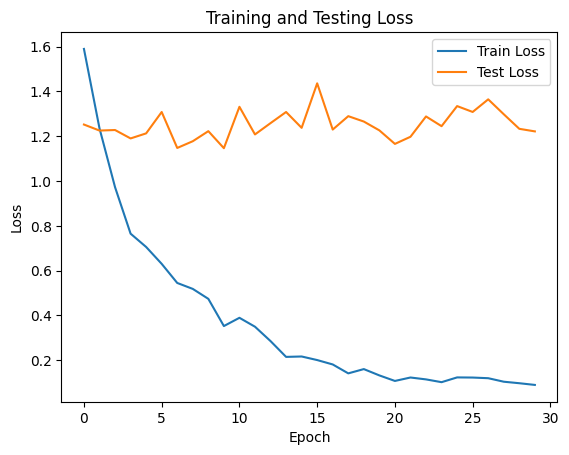

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_scores, label='Train Loss')
plt.plot(test_scores, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

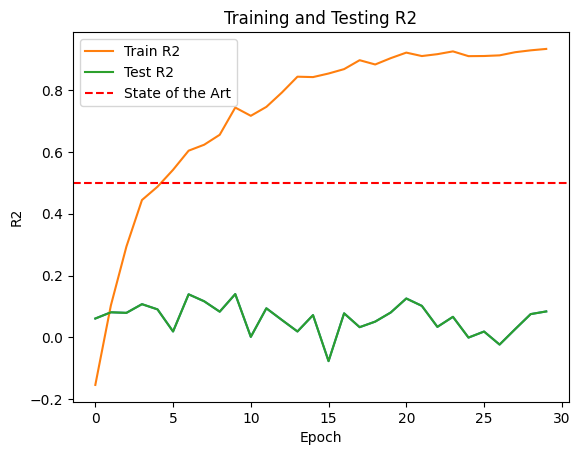

In [ ]:
plt.plot(test_r2_score)

plt.plot(train_r2_score, label='Train R2')
plt.plot(test_r2_score, label='Test R2')
plt.axhline(y=0.5, color='r', linestyle='--', label='State of the Art')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.title('Training and Testing R2')
plt.legend()
plt.show()

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

263553